# Ross Sea synthetic gravity inversion

Here we try to recover the true bathymetry of the Ross Sea from a synthetic airborne gravity survey. See notebook `Ross_Sea_synthetic_model.ipynb` for the creation of this synthetic gravity data and the low-resolution starting model of bathymetry. 

import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import os
import pathlib
import pickle
import string

import geopandas as gpd
import numpy as np
import scipy as sp
import shapely
import verde as vd
import xarray as xr
from polartoolkit import fetch, maps, profiles
from polartoolkit import utils as polar_utils

import RIS_gravity_inversion.plotting as RIS_plotting
import RIS_gravity_inversion.synthetic as RIS_synth

os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, regional, uncertainty, utils

# Get synthetic model data

INFO:root:converting to be reference to the WGS84 ellipsoid
INFO:root:spacing larger than original, filtering and resampling
grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.
grdsample [WARNING]: Output sampling interval in y exceeds input interval and may lead to aliasing.


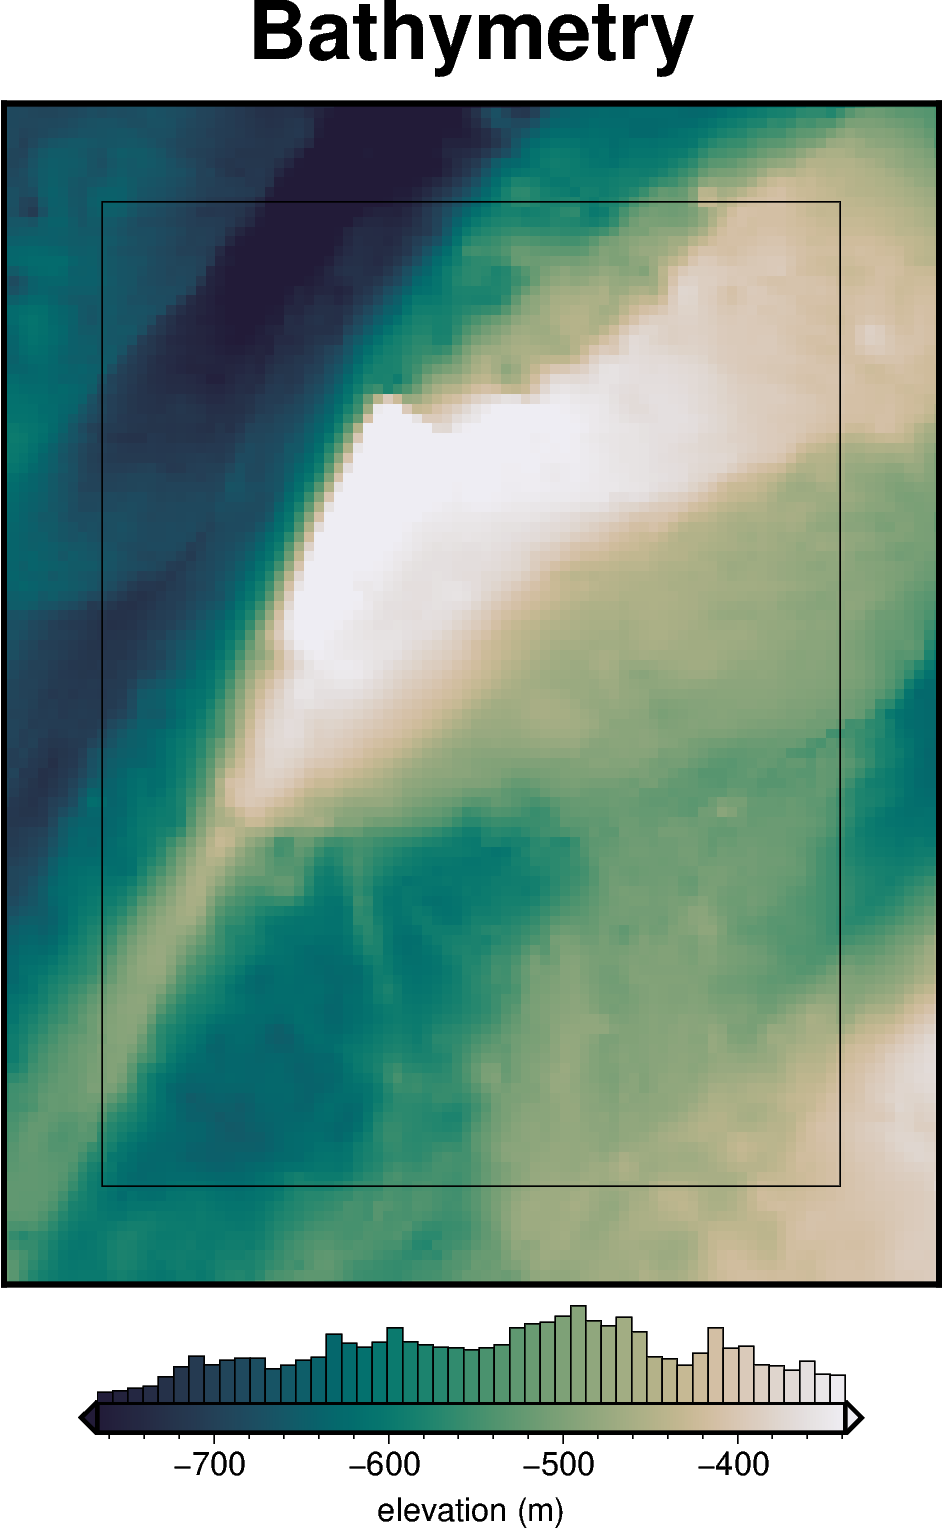

  0%|          | 0/7676 [00:00<?, ?it/s]

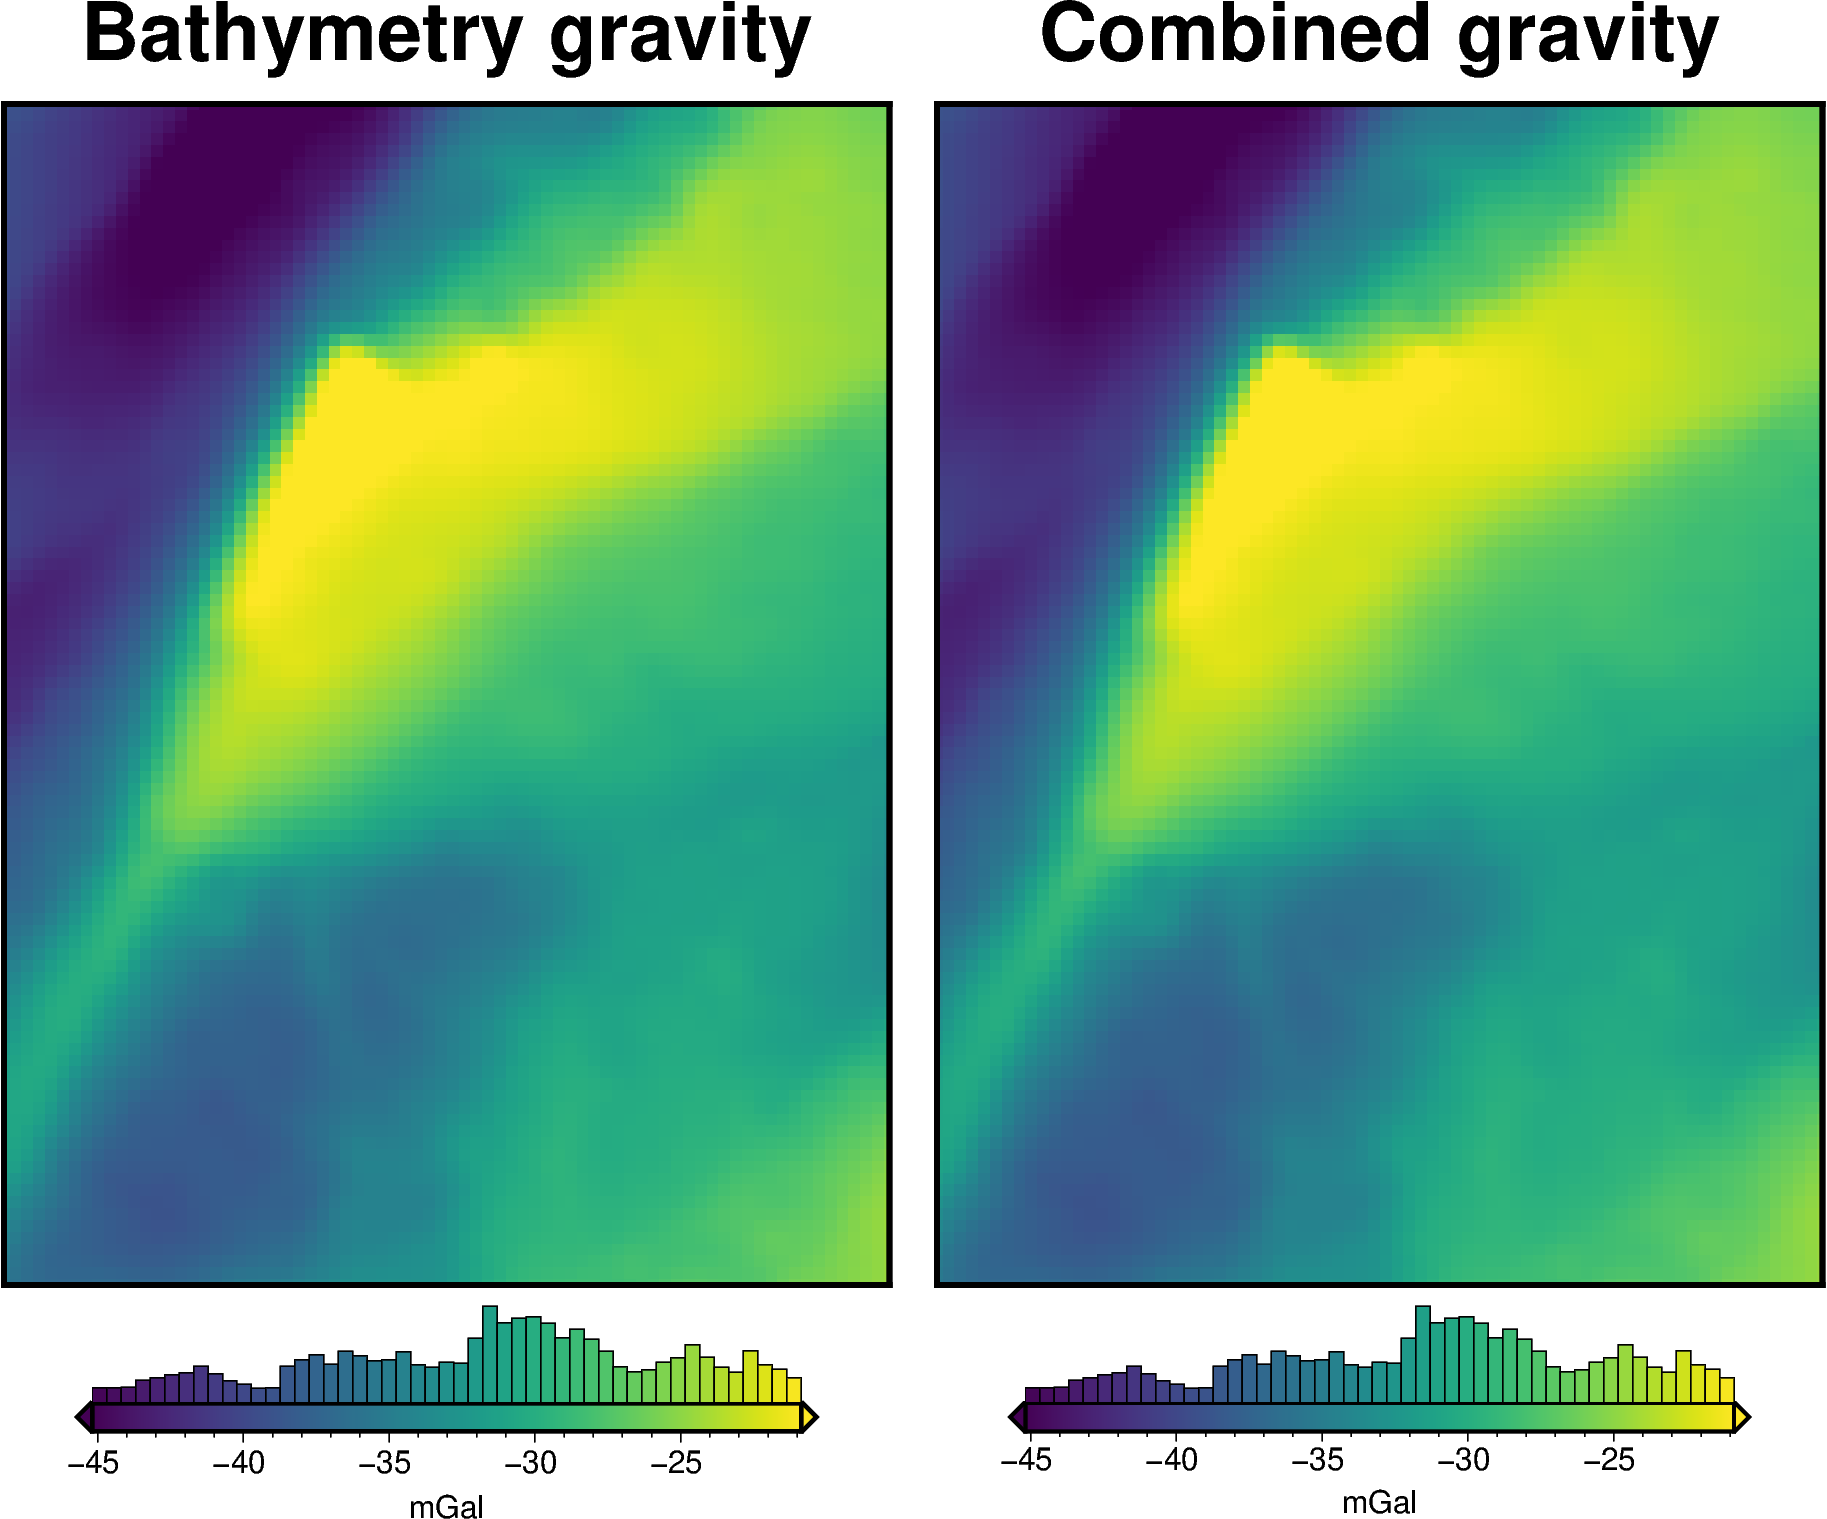

In [2]:
# set grid parameters
spacing = 2e3
inversion_region = (-40e3, 110e3, -1600e3, -1400e3)

true_density_contrast = 1476

bathymetry, basement, grav_df = RIS_synth.load_synthetic_model(
    spacing=spacing,
    inversion_region=inversion_region,
    buffer=spacing * 10,
    zref=0,
    bathymetry_density_contrast=true_density_contrast,
)
buffer_region = polar_utils.get_grid_info(bathymetry)[1]

In [3]:
grav_df.head()

northing  easting  upward  bathymetry_grav  basement_grav  disturbance  \
0 -1600000.0 -40000.0  1000.0       -35.551041              0   -35.551041   
1 -1600000.0 -38000.0  1000.0       -36.054652              0   -36.054652   
2 -1600000.0 -36000.0  1000.0       -36.473148              0   -36.473148   
3 -1600000.0 -34000.0  1000.0       -36.755612              0   -36.755612   
4 -1600000.0 -32000.0  1000.0       -36.951032              0   -36.951032   

   gravity_anomaly  
0       -35.551041  
1       -36.054652  
2       -36.473148  
3       -36.755612  
4       -36.951032

# Make starting bathymetry model

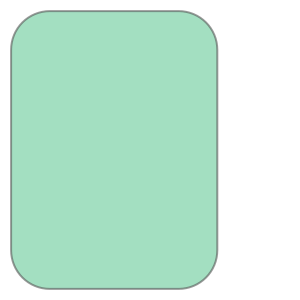

In [130]:
df = polar_utils.region_to_df(inversion_region)
gdf = gpd.GeoDataFrame(
    index=[0],
    geometry=[shapely.geometry.Polygon(zip(df.x, df.y))],
)
polygon = gdf.geometry.envelope.buffer(-30e3).buffer(27e3)
polygon.to_file("../../data/Ross_Sea_outline.shp")
polygon.iloc[0]

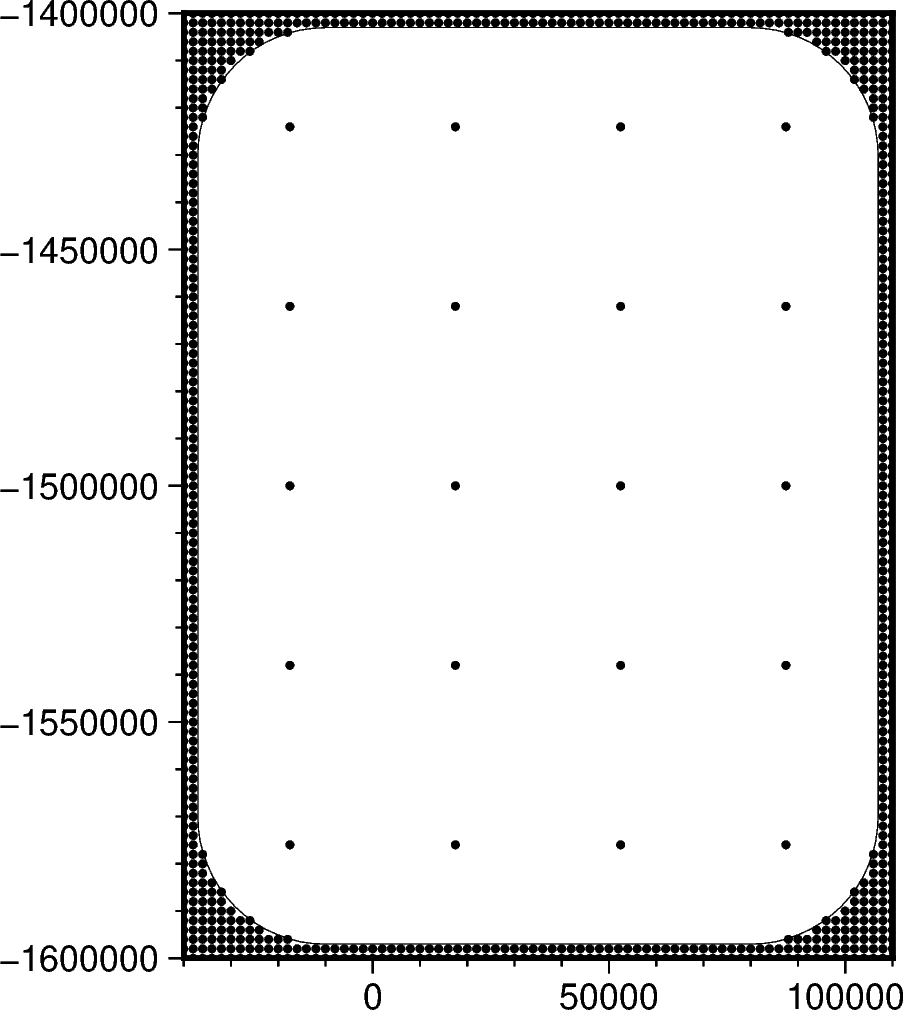

northing  easting  inside  true_upward      upward
0   -1600000.0 -40000.0   False  -601.093811 -601.093811
1   -1600000.0 -38000.0   False  -609.216797 -609.216797
2   -1600000.0 -36000.0   False  -616.356018 -616.356018
3   -1600000.0 -34000.0   False  -621.262207 -621.262207
4   -1600000.0 -32000.0   False  -625.510864 -625.510864
..         ...      ...     ...          ...         ...
859 -1462000.0  87500.0    True  -441.542496 -441.542496
860 -1424000.0 -17500.0    True  -758.042567 -758.042567
861 -1424000.0  17500.0    True  -637.767397 -637.767397
862 -1424000.0  52500.0    True  -454.151180 -454.151180
863 -1424000.0  87500.0    True  -395.632119 -395.632119

[864 rows x 5 columns]

In [4]:
# semi-regularly spaced
constraint_points = RIS_synth.constraint_layout_number(
    shape=(4, 5),
    region=inversion_region,
    padding=-spacing,
    shapefile="../../data/Ross_Sea_outline.shp",
    add_outside_points=True,
    grid_spacing=spacing,
    plot=True,
)

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    bathymetry,
    "true_upward",
    coord_names=("easting", "northing"),
)
constraint_points["upward"] = constraint_points.true_upward
constraint_points

In [5]:
# # calculate average constraint spacing
# constraint_spacing = (
#     np.median(
#         vd.median_distance(
#             (constraint_points.easting, constraint_points.northing),
#             k_nearest=1,
#         )
#     )
#     / 1e3
# )

# inversion_area =  (
#     (inversion_region[1] - inversion_region[0])
#     / 1e3
#     * (inversion_region[3] - inversion_region[2])
#     /1e3
# )

# # calculate number of constraints per 10000 sq km
# constraints_per_10000sq_km = (
#     len(constraint_points) / inversion_area
# ) * 10e3

# # calculate sq km for each constraint
# constraints_density = 1/ (len(constraint_points) / inversion_area)

# print(f"Constraint spacing: {constraint_spacing} km")
# print(f"Constraints per 10,000 sq km: {constraints_per_10000sq_km}")
# print(f"Constraints density: {constraints_density}")

In [6]:
# calculate gravity data median distance
grd = bathymetry.sel(
    easting=slice(*inversion_region[:2]), northing=slice(*inversion_region[2:])
)
grd = fetch.resample_grid(grd, spacing=100, verbose="q").rename(
    {"x": "easting", "y": "northing"}
)

min_dist = utils.dist_nearest_points(
    constraint_points,
    grd,
).min_dist

print(f"median minimum distance: {int(min_dist.median().values)} m")

median minimum distance: 10400 m


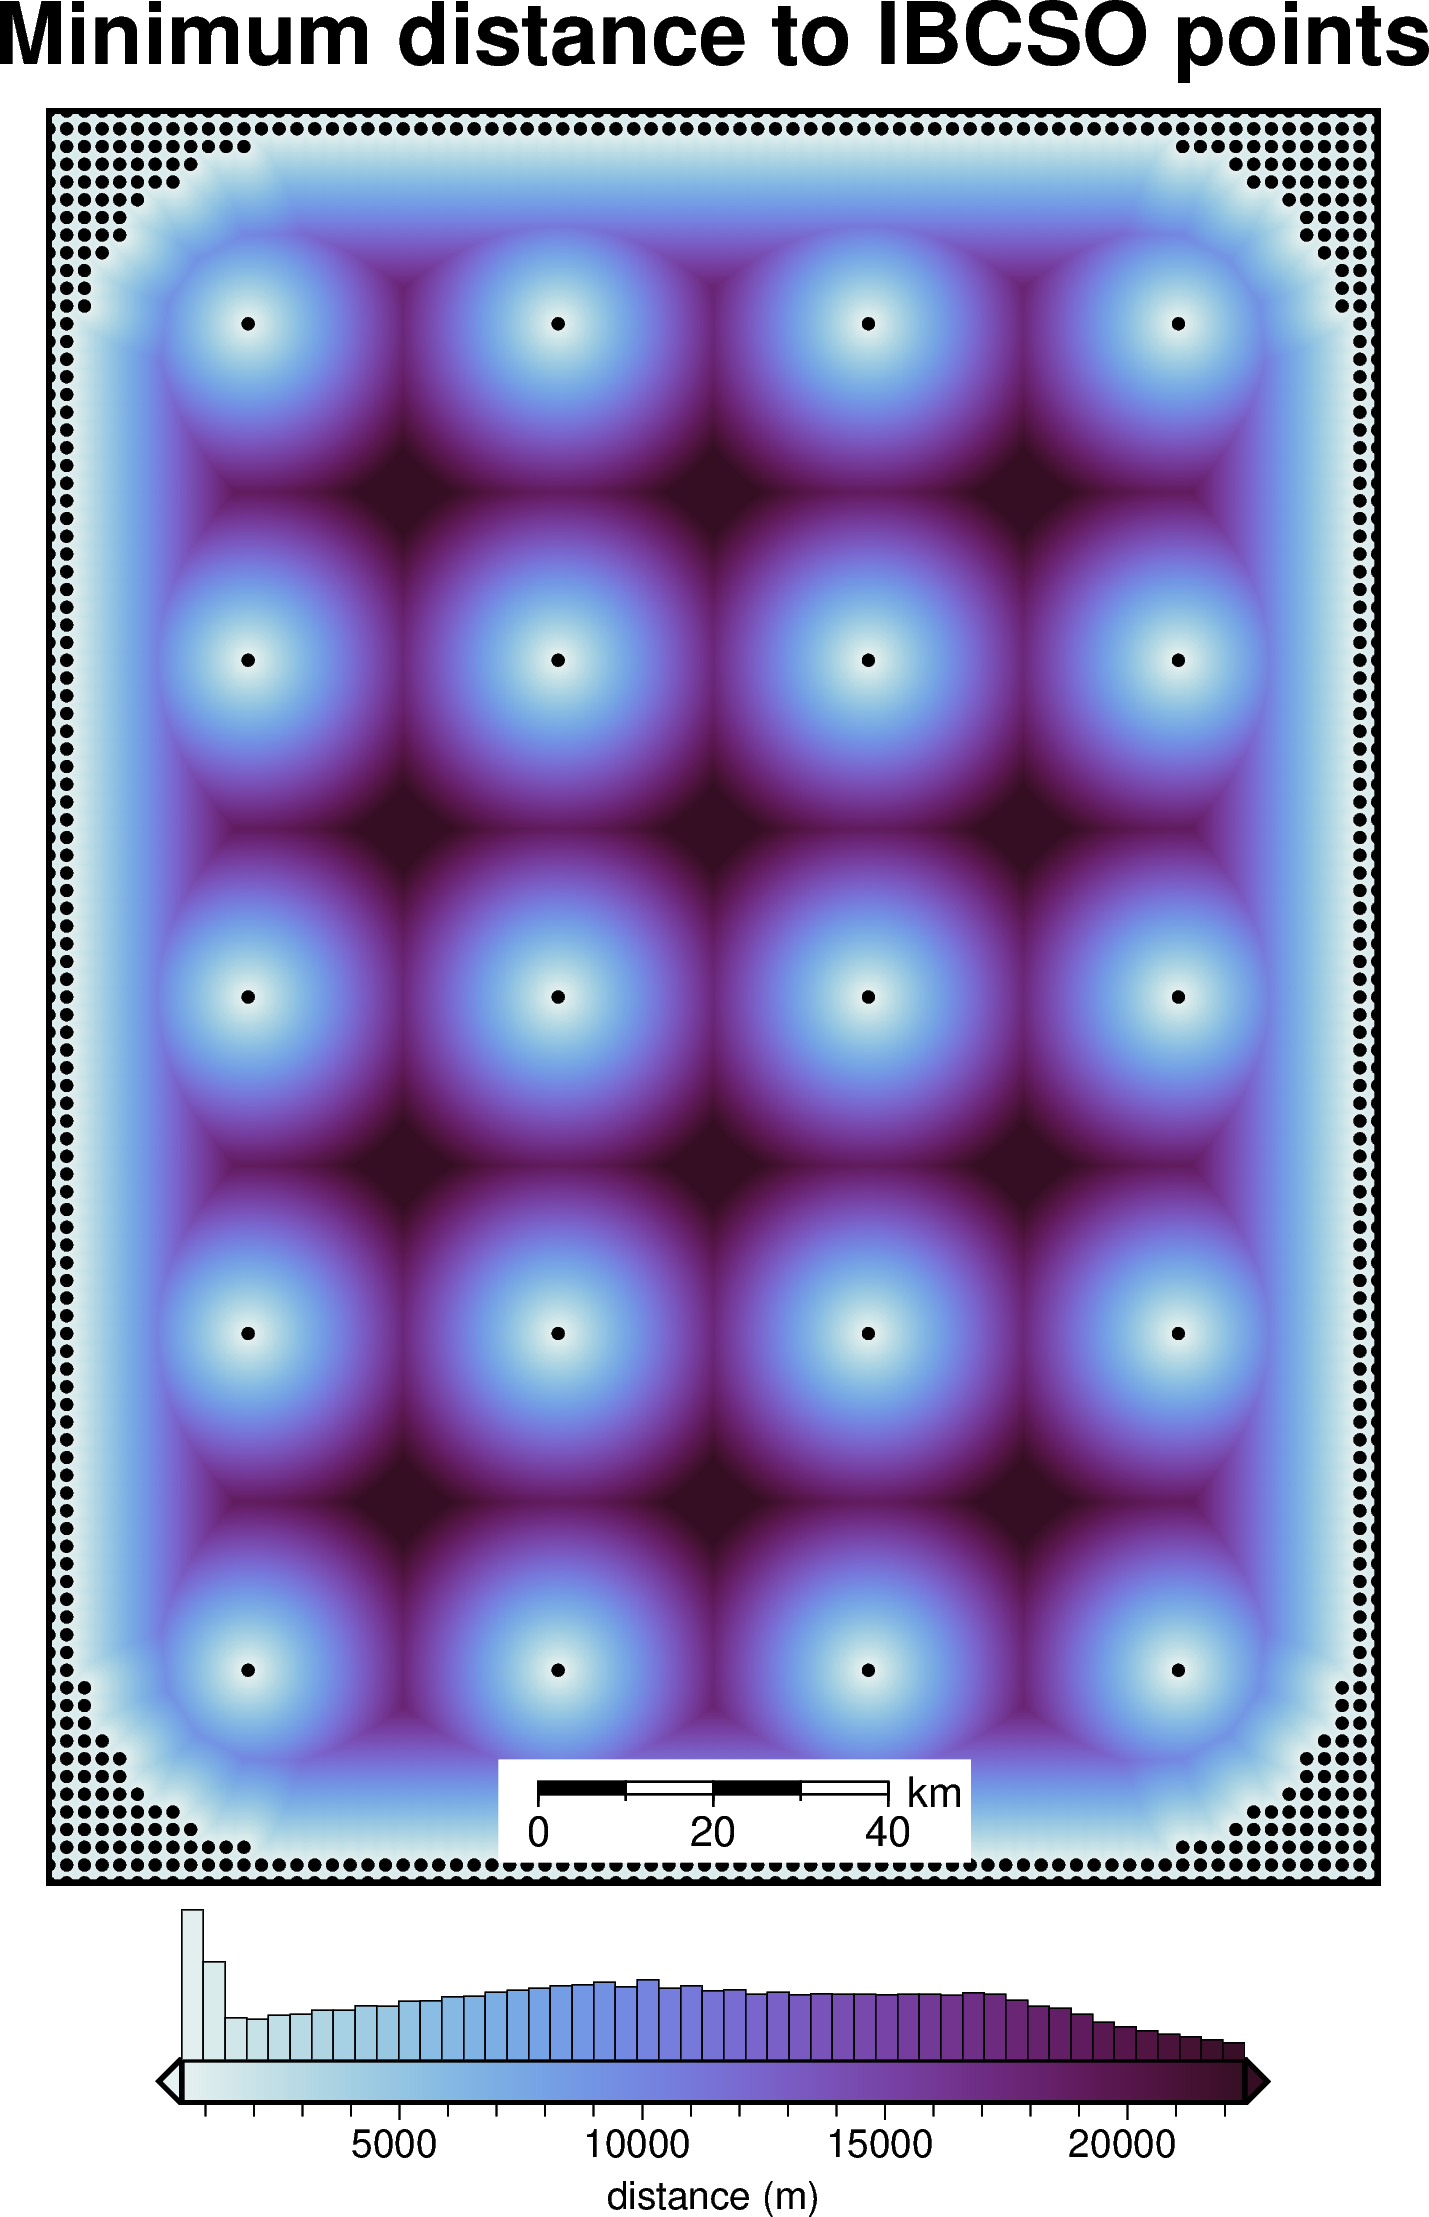

In [7]:
fig = maps.plot_grd(
    min_dist,
    region=inversion_region,
    title="Minimum distance to IBCSO points",
    cbar_label="distance (m)",
    cmap="dense",
    hist=True,
    robust=True,
    points=constraint_points,
    points_style="c2p",
    points_fill="black",
    scalebar=True,
)
fig.show()

In [8]:
# grid the sampled values using verde
starting_topography_kwargs = dict(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=None,
)
starting_bathymetry = utils.create_topography(**starting_topography_kwargs)

starting_bathymetry

<xarray.DataArray 'scalars' (northing: 121, easting: 96)> Size: 93kB
array([[-540.85324708, -544.21519109, -547.59855677, ..., -359.77829766,
        -356.84097116, -353.9671395 ],
       [-542.96903012, -546.47710941, -550.04617896, ..., -362.70499047,
        -359.76544554, -356.90451862],
       [-544.69488138, -548.33638995, -552.08554336, ..., -365.48679147,
        -362.55156299, -359.71215141],
       ...,
       [-591.97428035, -595.54194913, -599.09350427, ..., -440.93897354,
        -440.74704981, -440.46522382],
       [-590.54905826, -594.11158059, -597.66425625, ..., -440.7362303 ,
        -440.47619558, -440.129527  ],
       [-589.18119782, -592.75387759, -596.32448457, ..., -440.56111512,
        -440.22075739, -439.79986662]])
Coordinates:
  * easting   (easting) float64 768B -6e+04 -5.8e+04 ... 1.28e+05 1.3e+05
  * northing  (northing) float64 968B -1.62e+06 -1.618e+06 ... -1.38e+06
Attributes:
    metadata:  Generated by SplineCV(cv=KFold(n_splits=5, random_state=0, shu...
    damping:   None

In [9]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    starting_bathymetry,
    "starting_bathymetry",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.starting_bathymetry)
print(f"RMSE: {rmse:.2f} m")

RMSE: 0.01 m


In [10]:
constraint_points

northing  easting  inside  true_upward      upward  starting_bathymetry
0   -1600000.0 -40000.0   False  -601.093811 -601.093811          -601.093811
1   -1600000.0 -38000.0   False  -609.216797 -609.216797          -609.216797
2   -1600000.0 -36000.0   False  -616.356018 -616.356018          -616.356018
3   -1600000.0 -34000.0   False  -621.262207 -621.262207          -621.262207
4   -1600000.0 -32000.0   False  -625.510864 -625.510864          -625.510864
..         ...      ...     ...          ...         ...                  ...
859 -1462000.0  87500.0    True  -441.542496 -441.542496          -441.518766
860 -1424000.0 -17500.0    True  -758.042567 -758.042567          -757.951472
861 -1424000.0  17500.0    True  -637.767397 -637.767397          -637.714910
862 -1424000.0  52500.0    True  -454.151180 -454.151180          -454.191936
863 -1424000.0  87500.0    True  -395.632119 -395.632119          -395.663304

[864 rows x 6 columns]

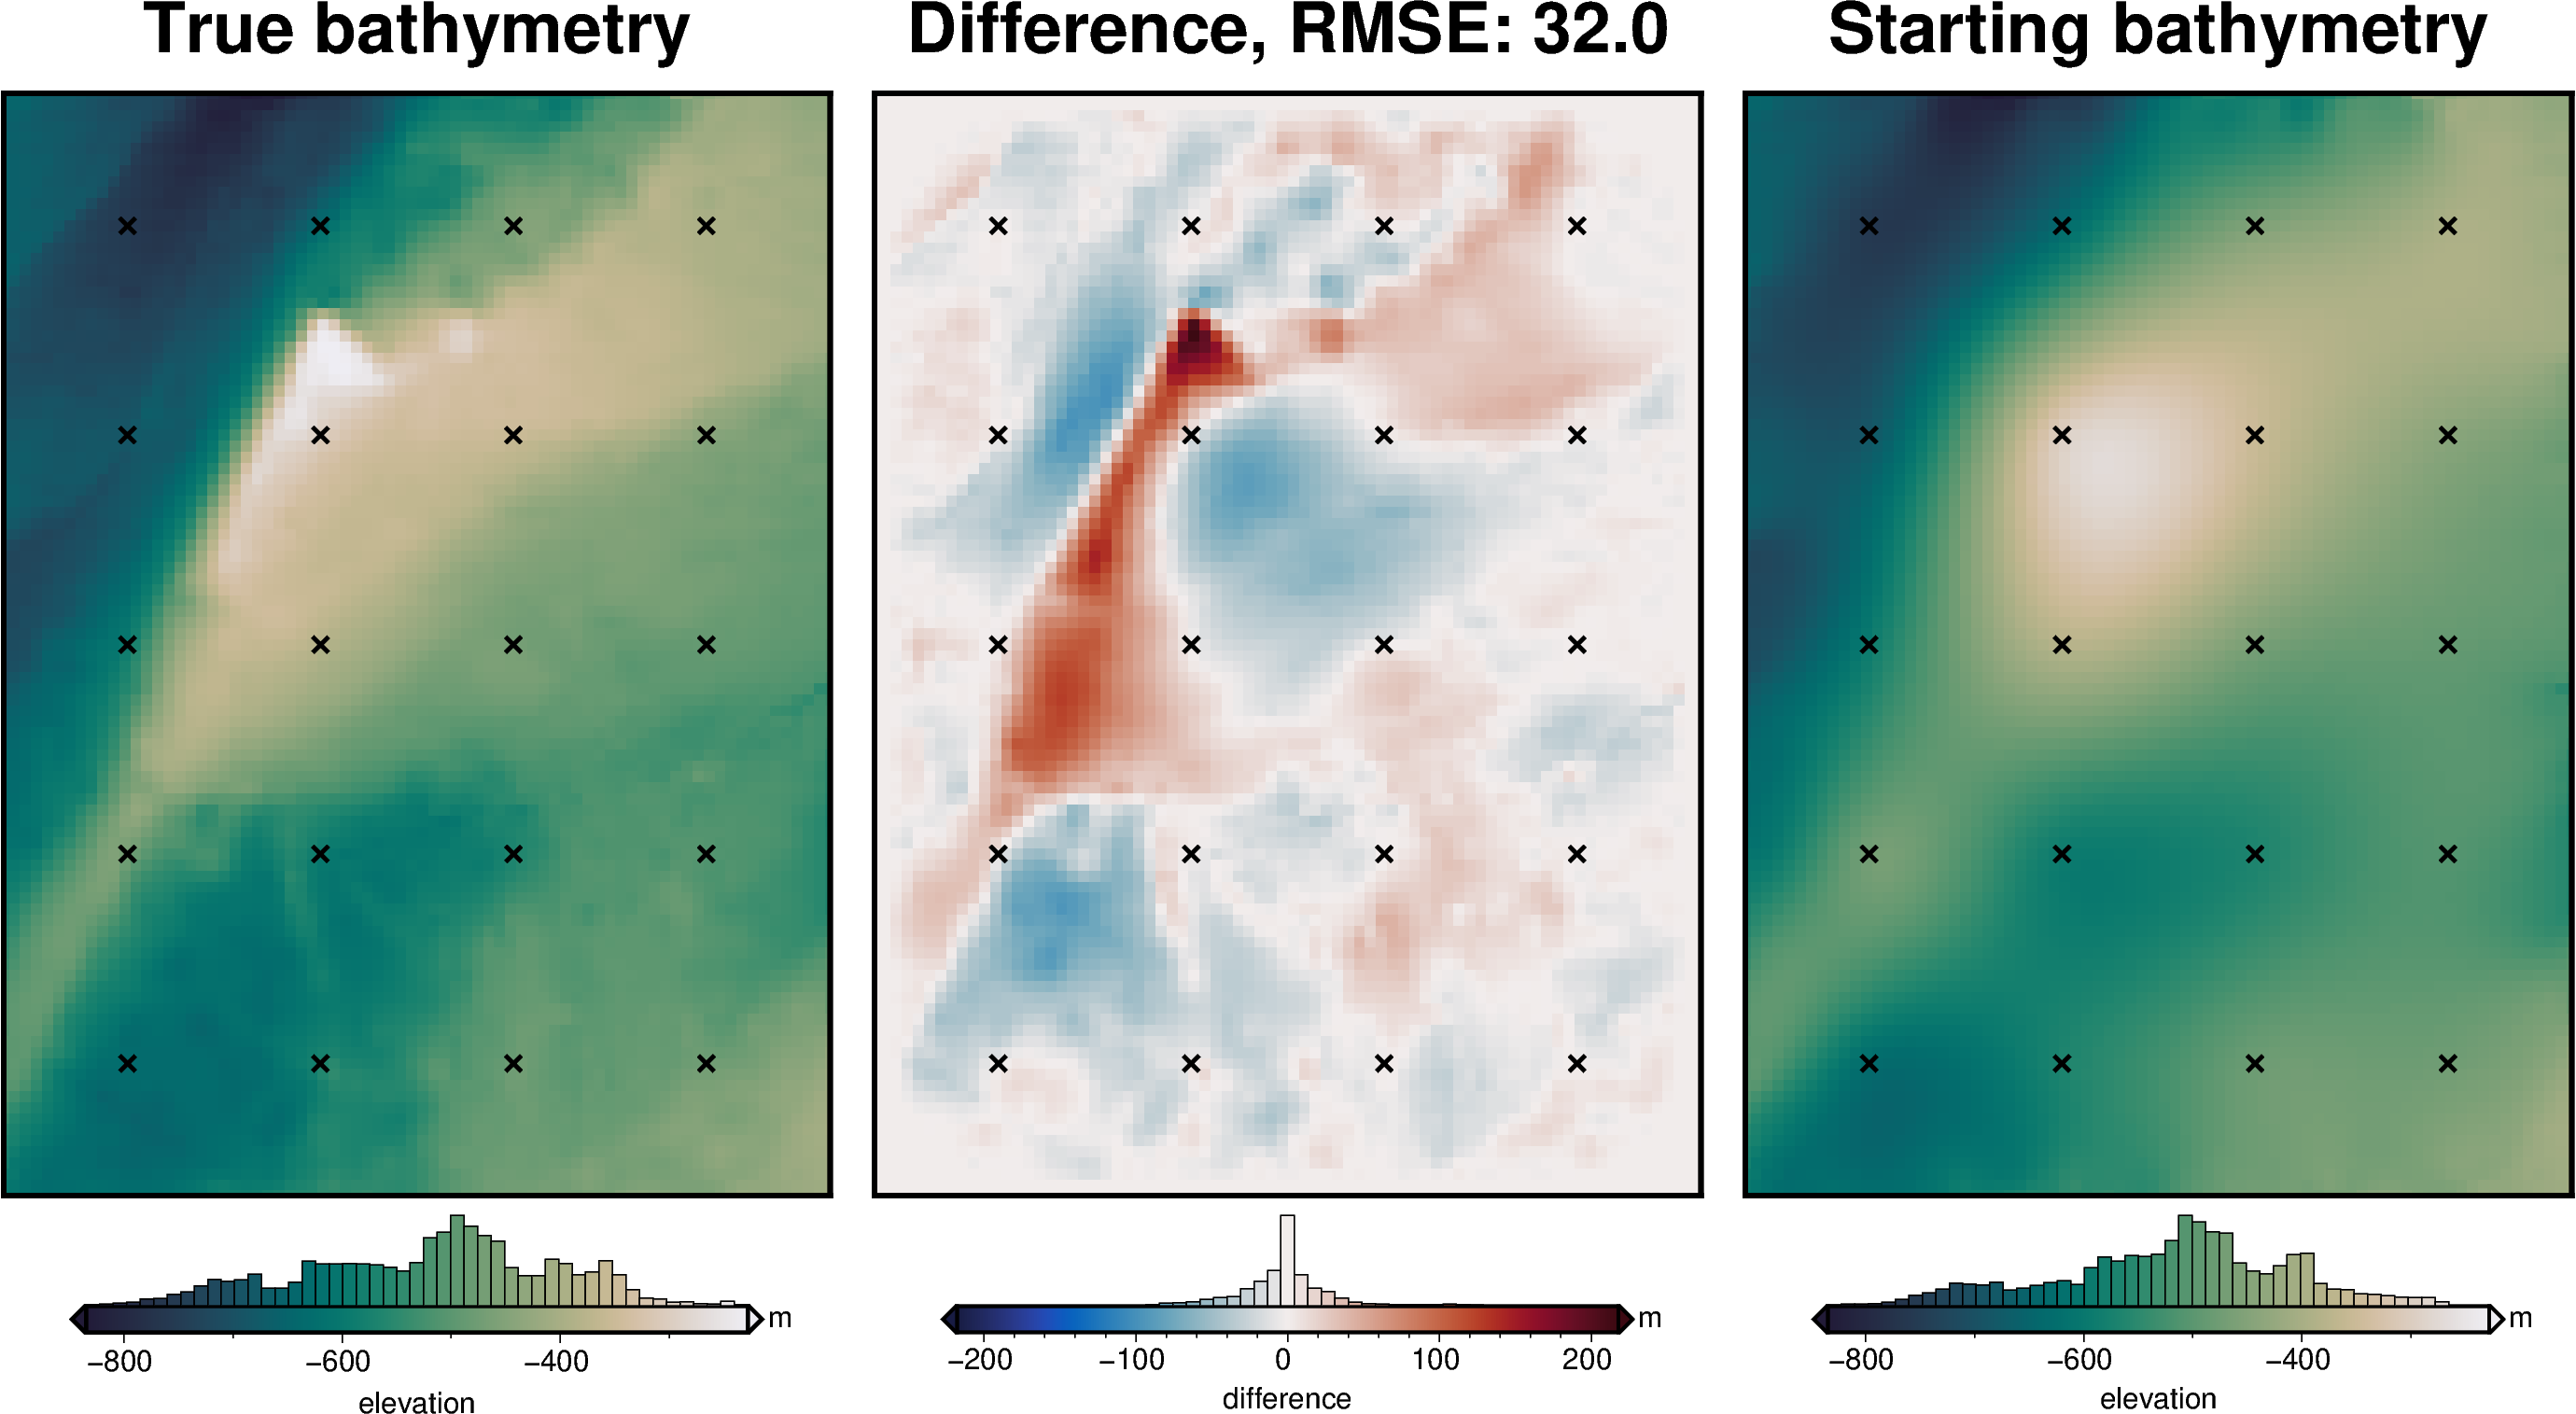

In [11]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    fig_height=10,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True bathymetry",
    grid2_name="Starting bathymetry",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1,
    label_font="16p,Helvetica,black",
    points=constraint_points[constraint_points.inside],
    points_style="x.2c",
)

In [12]:
# the true density contrast is 1476 kg/m3
density_contrast = 1350

# set the reference level from the prisms to 0
zref = 0

density_grid = xr.where(
    starting_bathymetry >= zref,
    density_contrast,
    -density_contrast,
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)

grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df

  0%|          | 0/7676 [00:00<?, ?it/s]

northing   easting  upward  bathymetry_grav  basement_grav  \
0    -1600000.0  -40000.0  1000.0       -35.551041              0   
1    -1600000.0  -38000.0  1000.0       -36.054652              0   
2    -1600000.0  -36000.0  1000.0       -36.473148              0   
3    -1600000.0  -34000.0  1000.0       -36.755612              0   
4    -1600000.0  -32000.0  1000.0       -36.951032              0   
...         ...       ...     ...              ...            ...   
7671 -1400000.0  102000.0  1000.0       -25.760380              0   
7672 -1400000.0  104000.0  1000.0       -25.911731              0   
7673 -1400000.0  106000.0  1000.0       -26.033127              0   
7674 -1400000.0  108000.0  1000.0       -26.122232              0   
7675 -1400000.0  110000.0  1000.0       -26.206510              0   

      disturbance  gravity_anomaly  starting_gravity  
0      -35.551041       -35.551041        -32.531726  
1      -36.054652       -36.054652        -32.955392  
2      -36.473148       -36.473148        -33.336163  
3      -36.755612       -36.755612        -33.631767  
4      -36.951032       -36.951032        -33.825918  
...           ...              ...               ...  
7671   -25.760380       -25.760380        -23.326855  
7672   -25.911731       -25.911731        -23.487013  
7673   -26.033127       -26.033127        -23.610099  
7674   -26.122232       -26.122232        -23.697322  
7675   -26.206510       -26.206510        -23.767655  

[7676 rows x 8 columns]

In [13]:
regional_grav_kwargs = dict(
    method="constant",
    # constant=0,
    constraints_df=constraint_points,
)
grav_df = regional.regional_separation(
    grav_df=grav_df,
    **regional_grav_kwargs,
)

grav_df

INFO:invert4geom:using median gravity misfit of constraint points for regional field: -2.9441845417022705 mGal


northing   easting  upward  bathymetry_grav  basement_grav  \
0    -1600000.0  -40000.0  1000.0       -35.551041              0   
1    -1600000.0  -38000.0  1000.0       -36.054652              0   
2    -1600000.0  -36000.0  1000.0       -36.473148              0   
3    -1600000.0  -34000.0  1000.0       -36.755612              0   
4    -1600000.0  -32000.0  1000.0       -36.951032              0   
...         ...       ...     ...              ...            ...   
7671 -1400000.0  102000.0  1000.0       -25.760380              0   
7672 -1400000.0  104000.0  1000.0       -25.911731              0   
7673 -1400000.0  106000.0  1000.0       -26.033127              0   
7674 -1400000.0  108000.0  1000.0       -26.122232              0   
7675 -1400000.0  110000.0  1000.0       -26.206510              0   

      disturbance  gravity_anomaly  starting_gravity    misfit       reg  \
0      -35.551041       -35.551041        -32.531726 -3.019316 -2.944185   
1      -36.054652       -36.054652        -32.955392 -3.099260 -2.944185   
2      -36.473148       -36.473148        -33.336163 -3.136985 -2.944185   
3      -36.755612       -36.755612        -33.631767 -3.123845 -2.944185   
4      -36.951032       -36.951032        -33.825918 -3.125114 -2.944185   
...           ...              ...               ...       ...       ...   
7671   -25.760380       -25.760380        -23.326855 -2.433525 -2.944185   
7672   -25.911731       -25.911731        -23.487013 -2.424717 -2.944185   
7673   -26.033127       -26.033127        -23.610099 -2.423028 -2.944185   
7674   -26.122232       -26.122232        -23.697322 -2.424910 -2.944185   
7675   -26.206510       -26.206510        -23.767655 -2.438855 -2.944185   

           res  
0    -0.075131  
1    -0.155075  
2    -0.192801  
3    -0.179660  
4    -0.180930  
...        ...  
7671  0.510660  
7672  0.519467  
7673  0.521157  
7674  0.519275  
7675  0.505330  

[7676 rows x 11 columns]

makecpt [ERROR]: Option T: min >= max


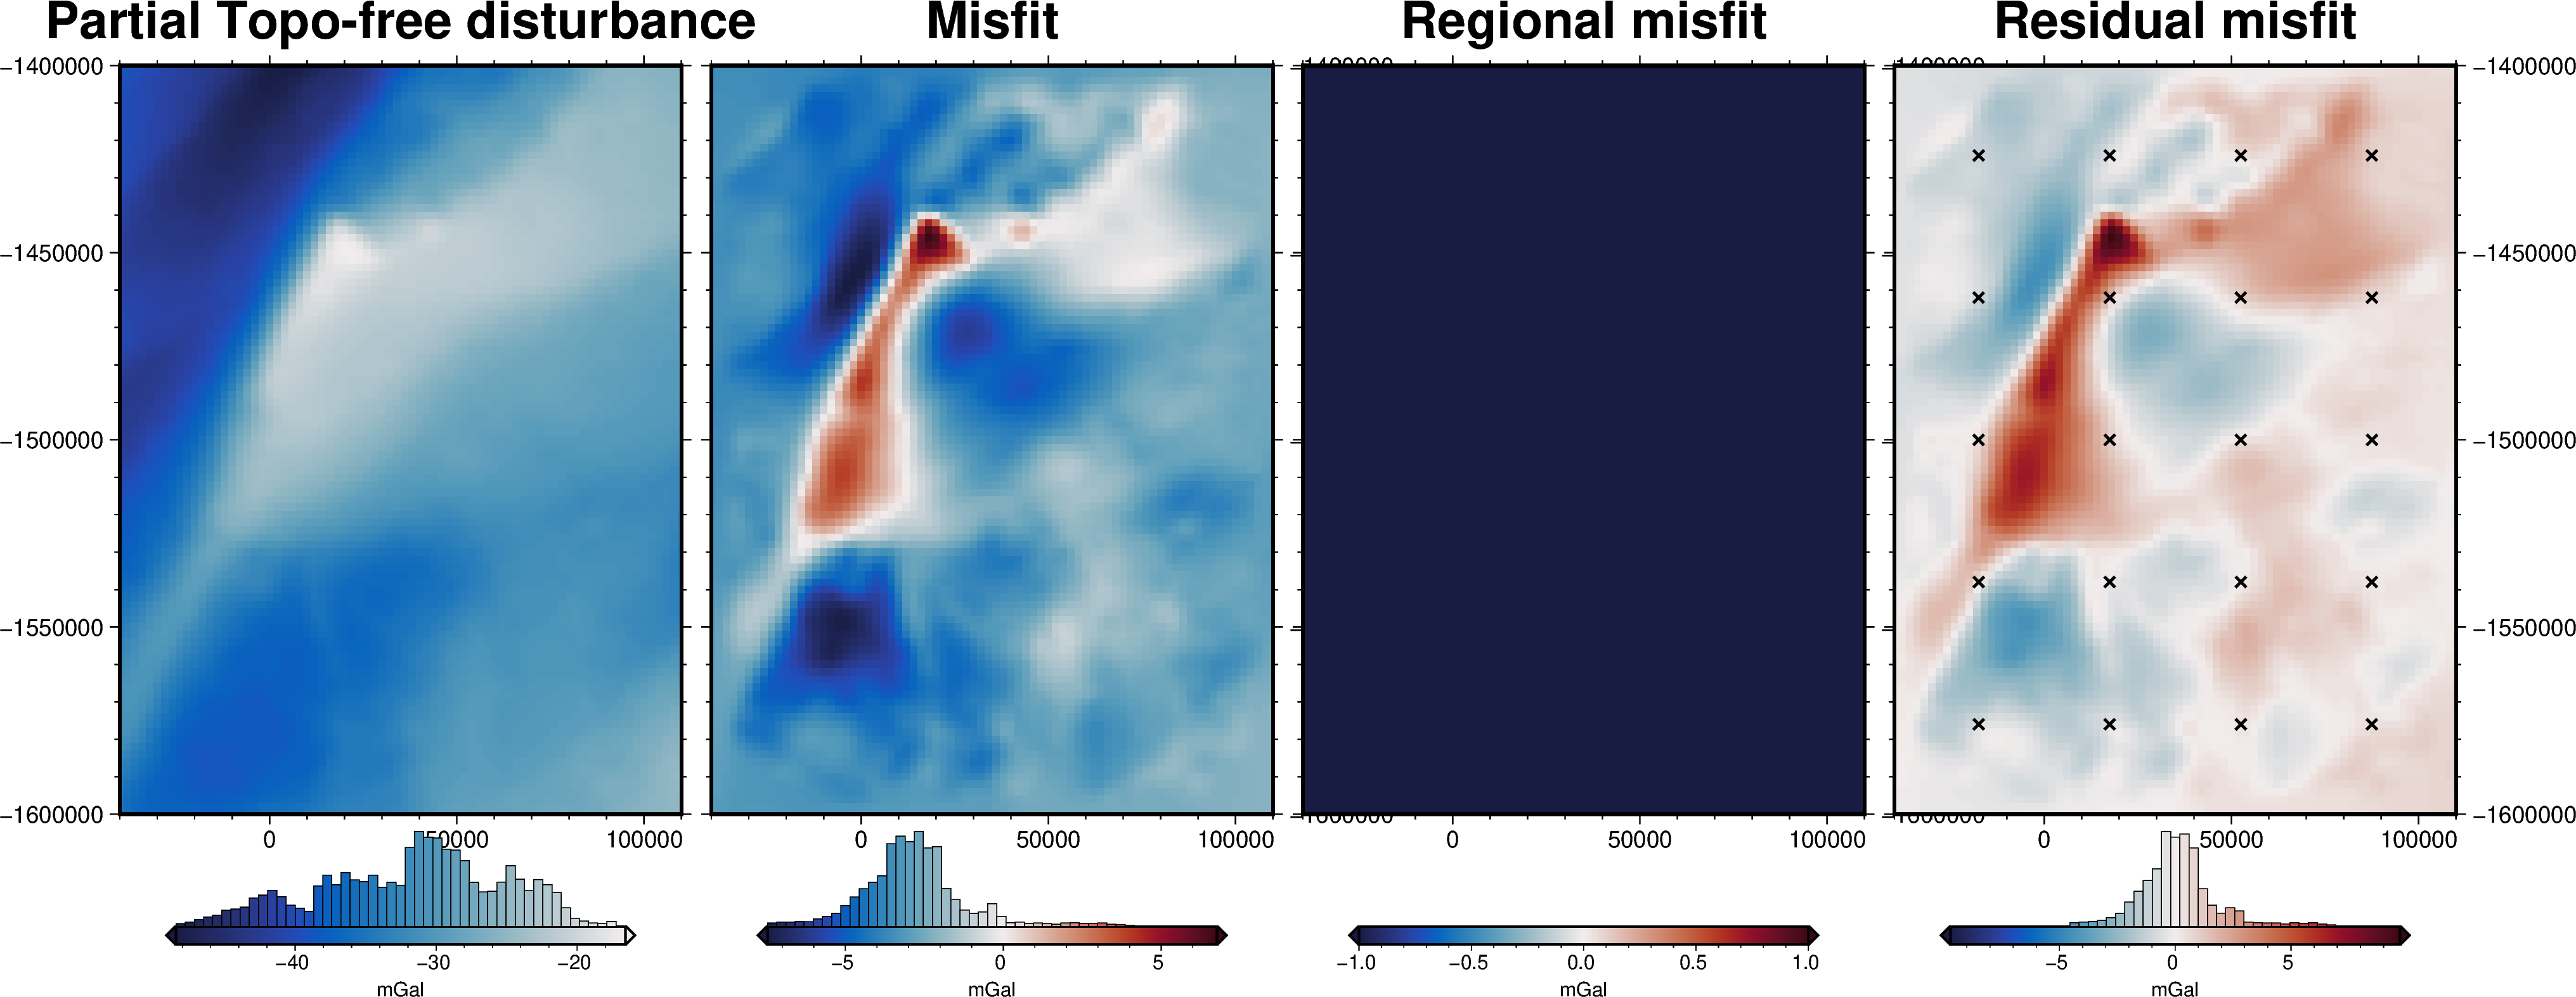

In [14]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Partial Topo-free disturbance",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points[constraint_points.inside],
    points_style="x.2c",
)
fig.show()

In [15]:
# # calculate the distance between each grid cell and the nearest constraint, then
# # normalize those values between 0 and 1
# weighting_grid = utils.normalized_mindist(
#     constraint_points,
#     starting_prisms,
#     low=0,
#     high=1,
# )
# weighting_grid.plot()

In [16]:
# # set kwargs to pass to the inversion
# kwargs = {
#     # set stopping criteria
#     "max_iterations": 200,
#     "l2_norm_tolerance": 0.2**0.5,  # square root of the gravity noise
#     "delta_l2_norm_tolerance": 1.02,
#     "apply_weighting_grid": True,
#     "weighting_grid": weighting_grid,
# }

# logging.getLogger().setLevel(logging.INFO)

# # run the inversion workflow, including a cross validation for the damping parameter
# results = inversion.run_inversion_workflow(
#     grav_df=grav_df,
#     starting_prisms=starting_prisms,
#     plot_dynamic_convergence=True,
#     **kwargs,
# )

# # collect the results
# topo_results, grav_results, parameters, elapsed_time = results

In [17]:
# plotting.plot_inversion_results(
#     grav_results,
#     topo_results,
#     parameters,
#     inversion_region,
#     iters_to_plot=2,
#     plot_iter_results=True,
#     plot_topo_results=True,
#     plot_grav_results=True,
# )

# final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

# _ = polar_utils.grd_compare(
#     bathymetry,
#     final_topography,
#     region=inversion_region,
#     plot=True,
#     grid1_name="True topography",
#     grid2_name="Inverted topography",
#     robust=True,
#     hist=True,
#     inset=False,
#     verbose="q",
#     title="difference",
#     grounding_line=False,
#     reverse_cpt=True,
#     cmap="rain",
#     points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="x.2c",
# )

In [18]:
# # set kwargs to pass to the inversion
# kwargs = {
#     # set stopping criteria
#     "max_iterations": 200,
#     "l2_norm_tolerance": 0.2**0.5,  # square root of the gravity noise
#     "delta_l2_norm_tolerance": 1.02,
#     # "apply_weighting_grid": True,
#     # "weighting_grid": weighting_grid,
# }

# logging.getLogger().setLevel(logging.INFO)

# # run the inversion workflow, including a cross validation for the damping parameter
# results = inversion.run_inversion_workflow(
#     grav_df=grav_df,
#     starting_prisms=starting_prisms,
#     plot_dynamic_convergence=True,
#     **kwargs,
# )

# # collect the results
# topo_results, grav_results, parameters, elapsed_time = results

# plotting.plot_inversion_results(
#     grav_results,
#     topo_results,
#     parameters,
#     inversion_region,
#     iters_to_plot=2,
#     plot_iter_results=True,
#     plot_topo_results=True,
#     plot_grav_results=True,
# )

# final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

# _ = polar_utils.grd_compare(
#     bathymetry,
#     final_topography,
#     region=inversion_region,
#     plot=True,
#     grid1_name="True topography",
#     grid2_name="Inverted topography",
#     robust=True,
#     hist=True,
#     inset=False,
#     verbose="q",
#     title="difference",
#     grounding_line=False,
#     reverse_cpt=True,
#     cmap="rain",
#     points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="x.2c",
# )

In [19]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": 0.2**0.5,  # square root of the gravity noise
    "delta_l2_norm_tolerance": 1.008,
    # "delta_l2_norm_tolerance": 1.02,
    # "apply_weighting_grid": True,
    # "weighting_grid": weighting_grid,
}

# Damping Cross Validation

In [79]:
logging.getLogger().setLevel(logging.INFO)

# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_prisms=starting_prisms,
    # for creating test/train splits
    grav_spacing=spacing,
    inversion_region=inversion_region,
    run_damping_cv=True,
    damping_limits=(0.001, 0.1),
    damping_cv_trials=8,
    # damping_limits=(1e-20, 1e-5),
    # damping_cv_trials=6,
    # plot_cv=True,
    fname="../../results/Ross_Sea_02_damping_cv",
    **kwargs,
)

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_02_damping_cv'


INFO:invert4geom:running damping cross validation
INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 7
INFO:invert4geom:	parameter: {'damping': 0.013355716290695199}
INFO:invert4geom:	scores: [0.01987706639162434]
INFO:invert4geom:results saved to ../../results/Ross_Sea_02_damping_cv_results.pickle.pickle


In [20]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_02_damping_cv_results.pickle").open(
    "rb"
) as f:
    results = pickle.load(f)

# load study
with pathlib.Path("../../results/Ross_Sea_02_damping_cv_damping_cv_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

In [21]:
best_damping = parameters.get("Solver damping")
kwargs["solver_damping"] = best_damping
best_damping

0.013355716290695199

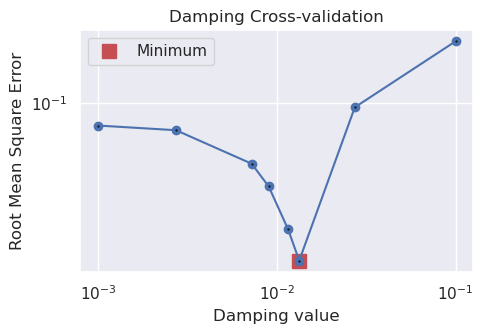

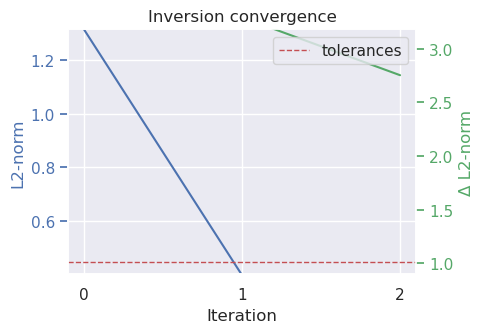

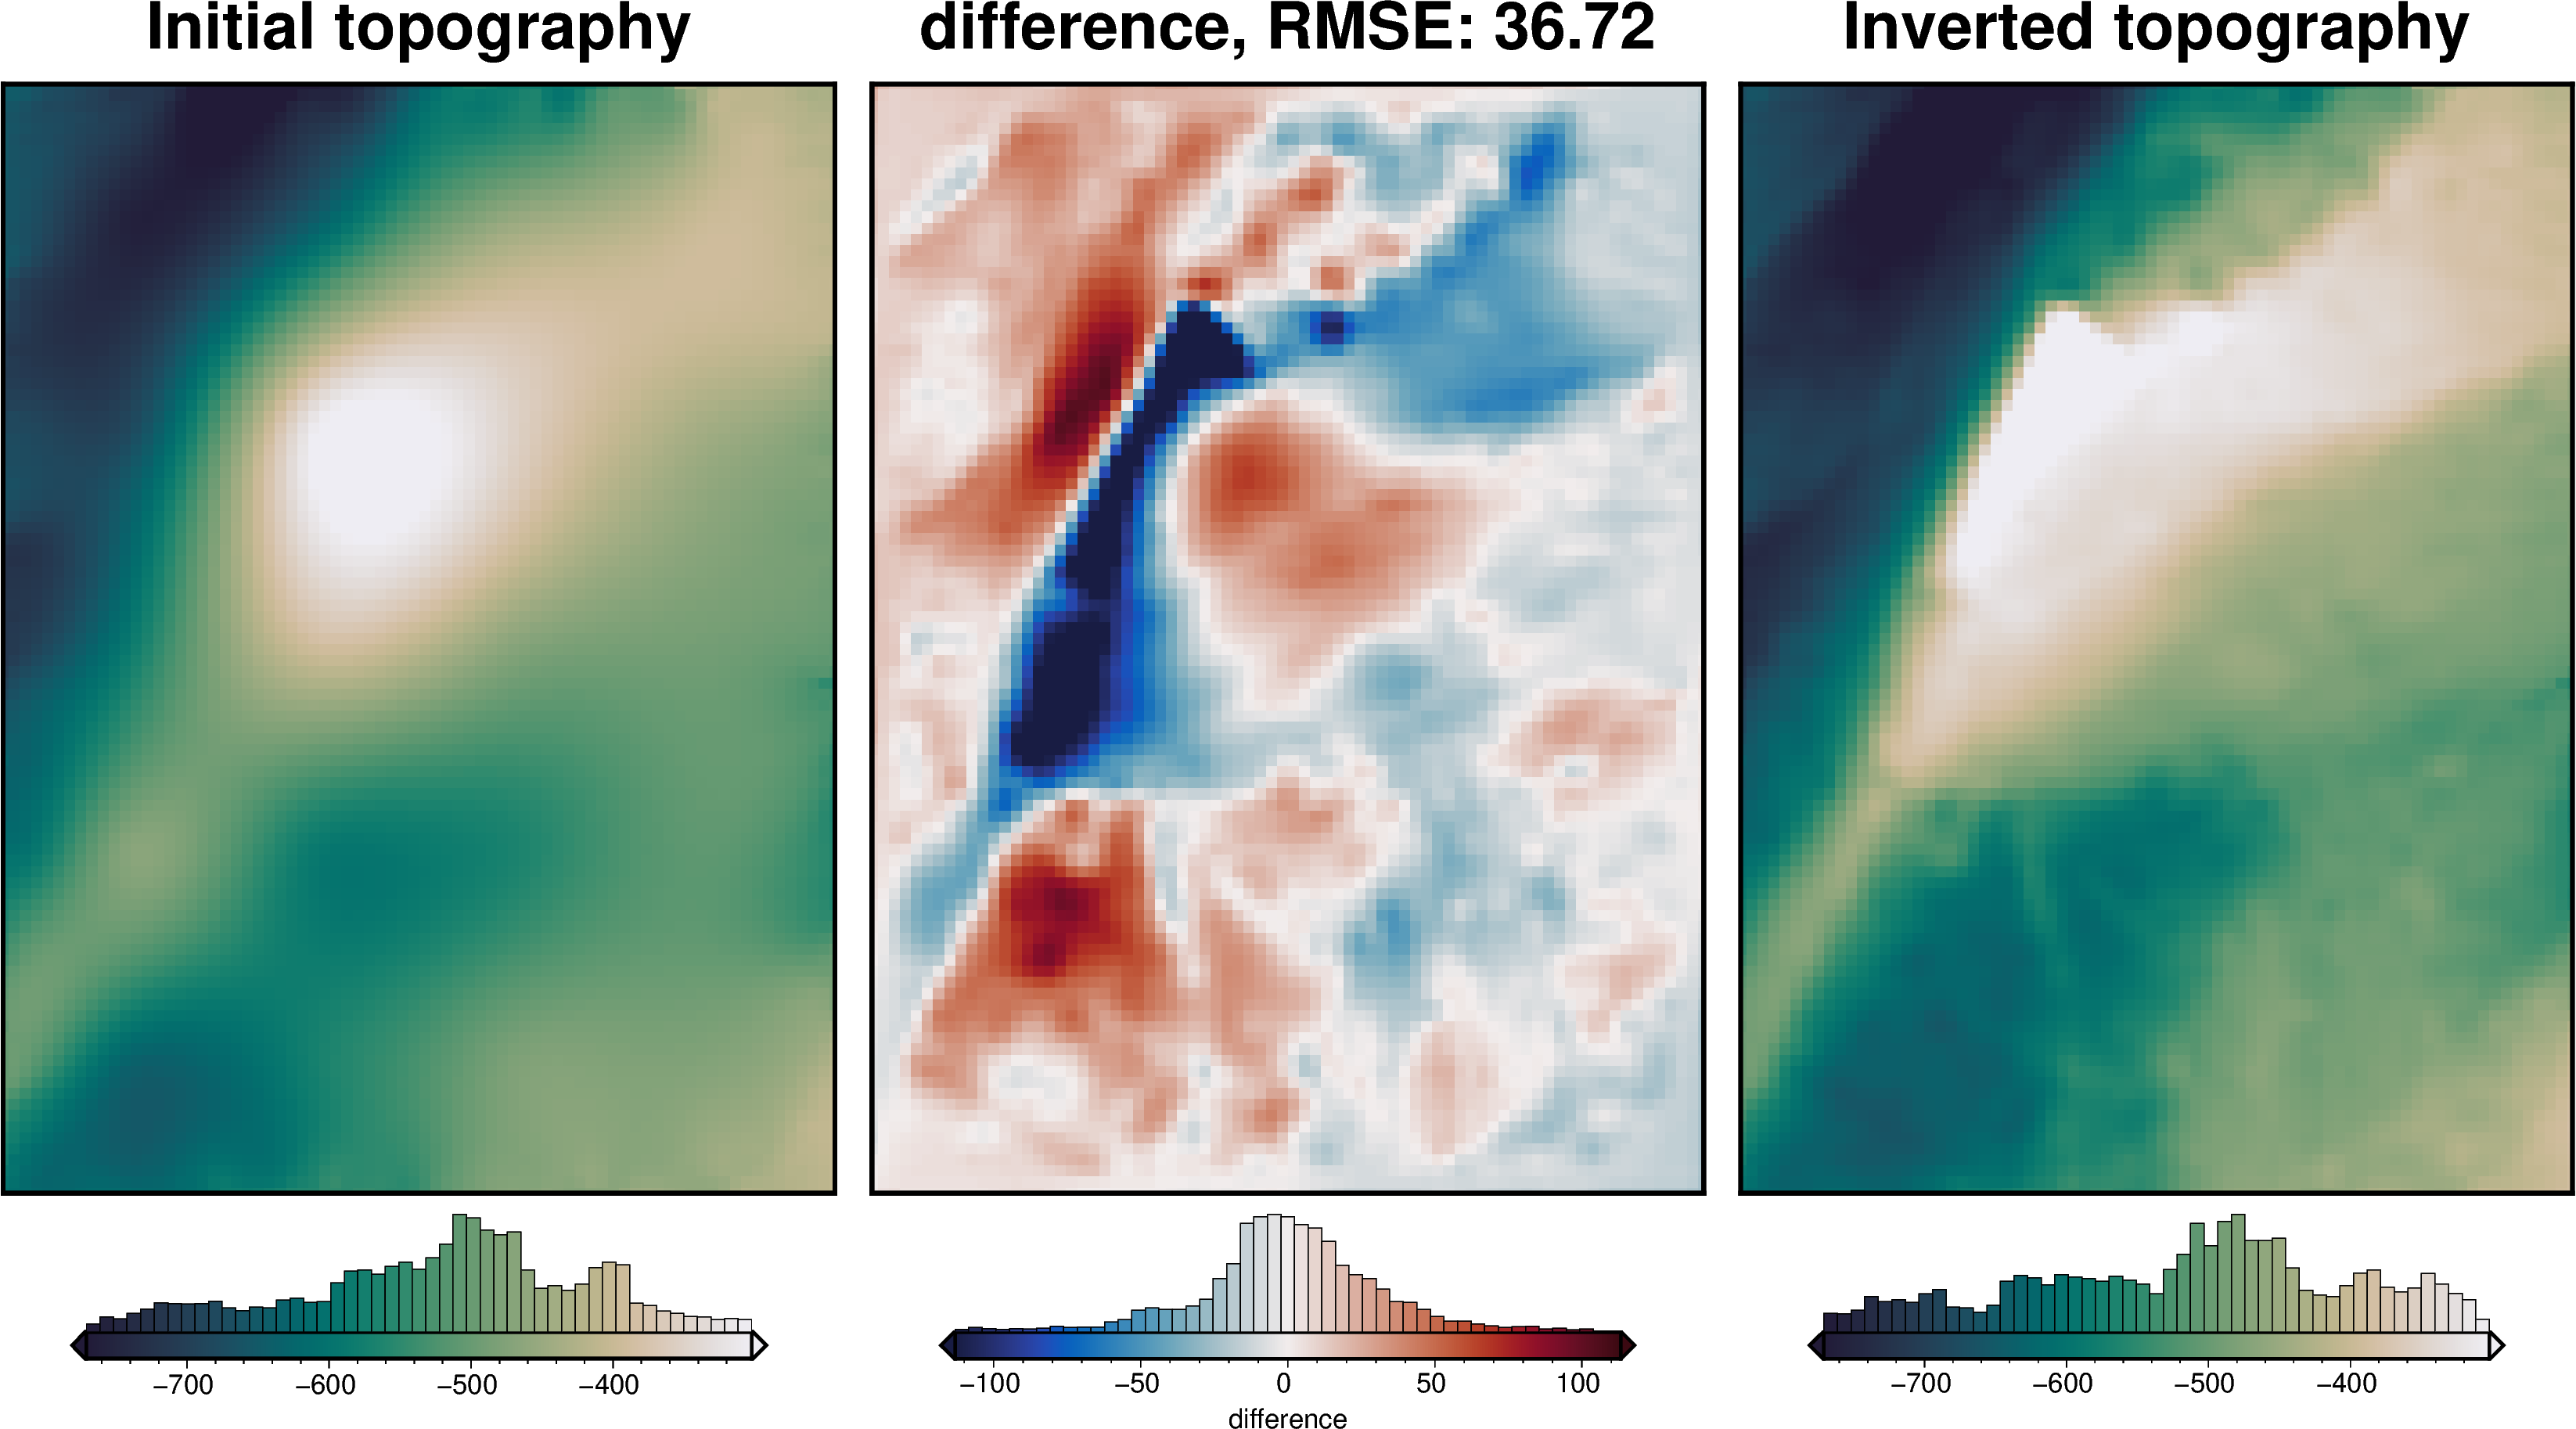

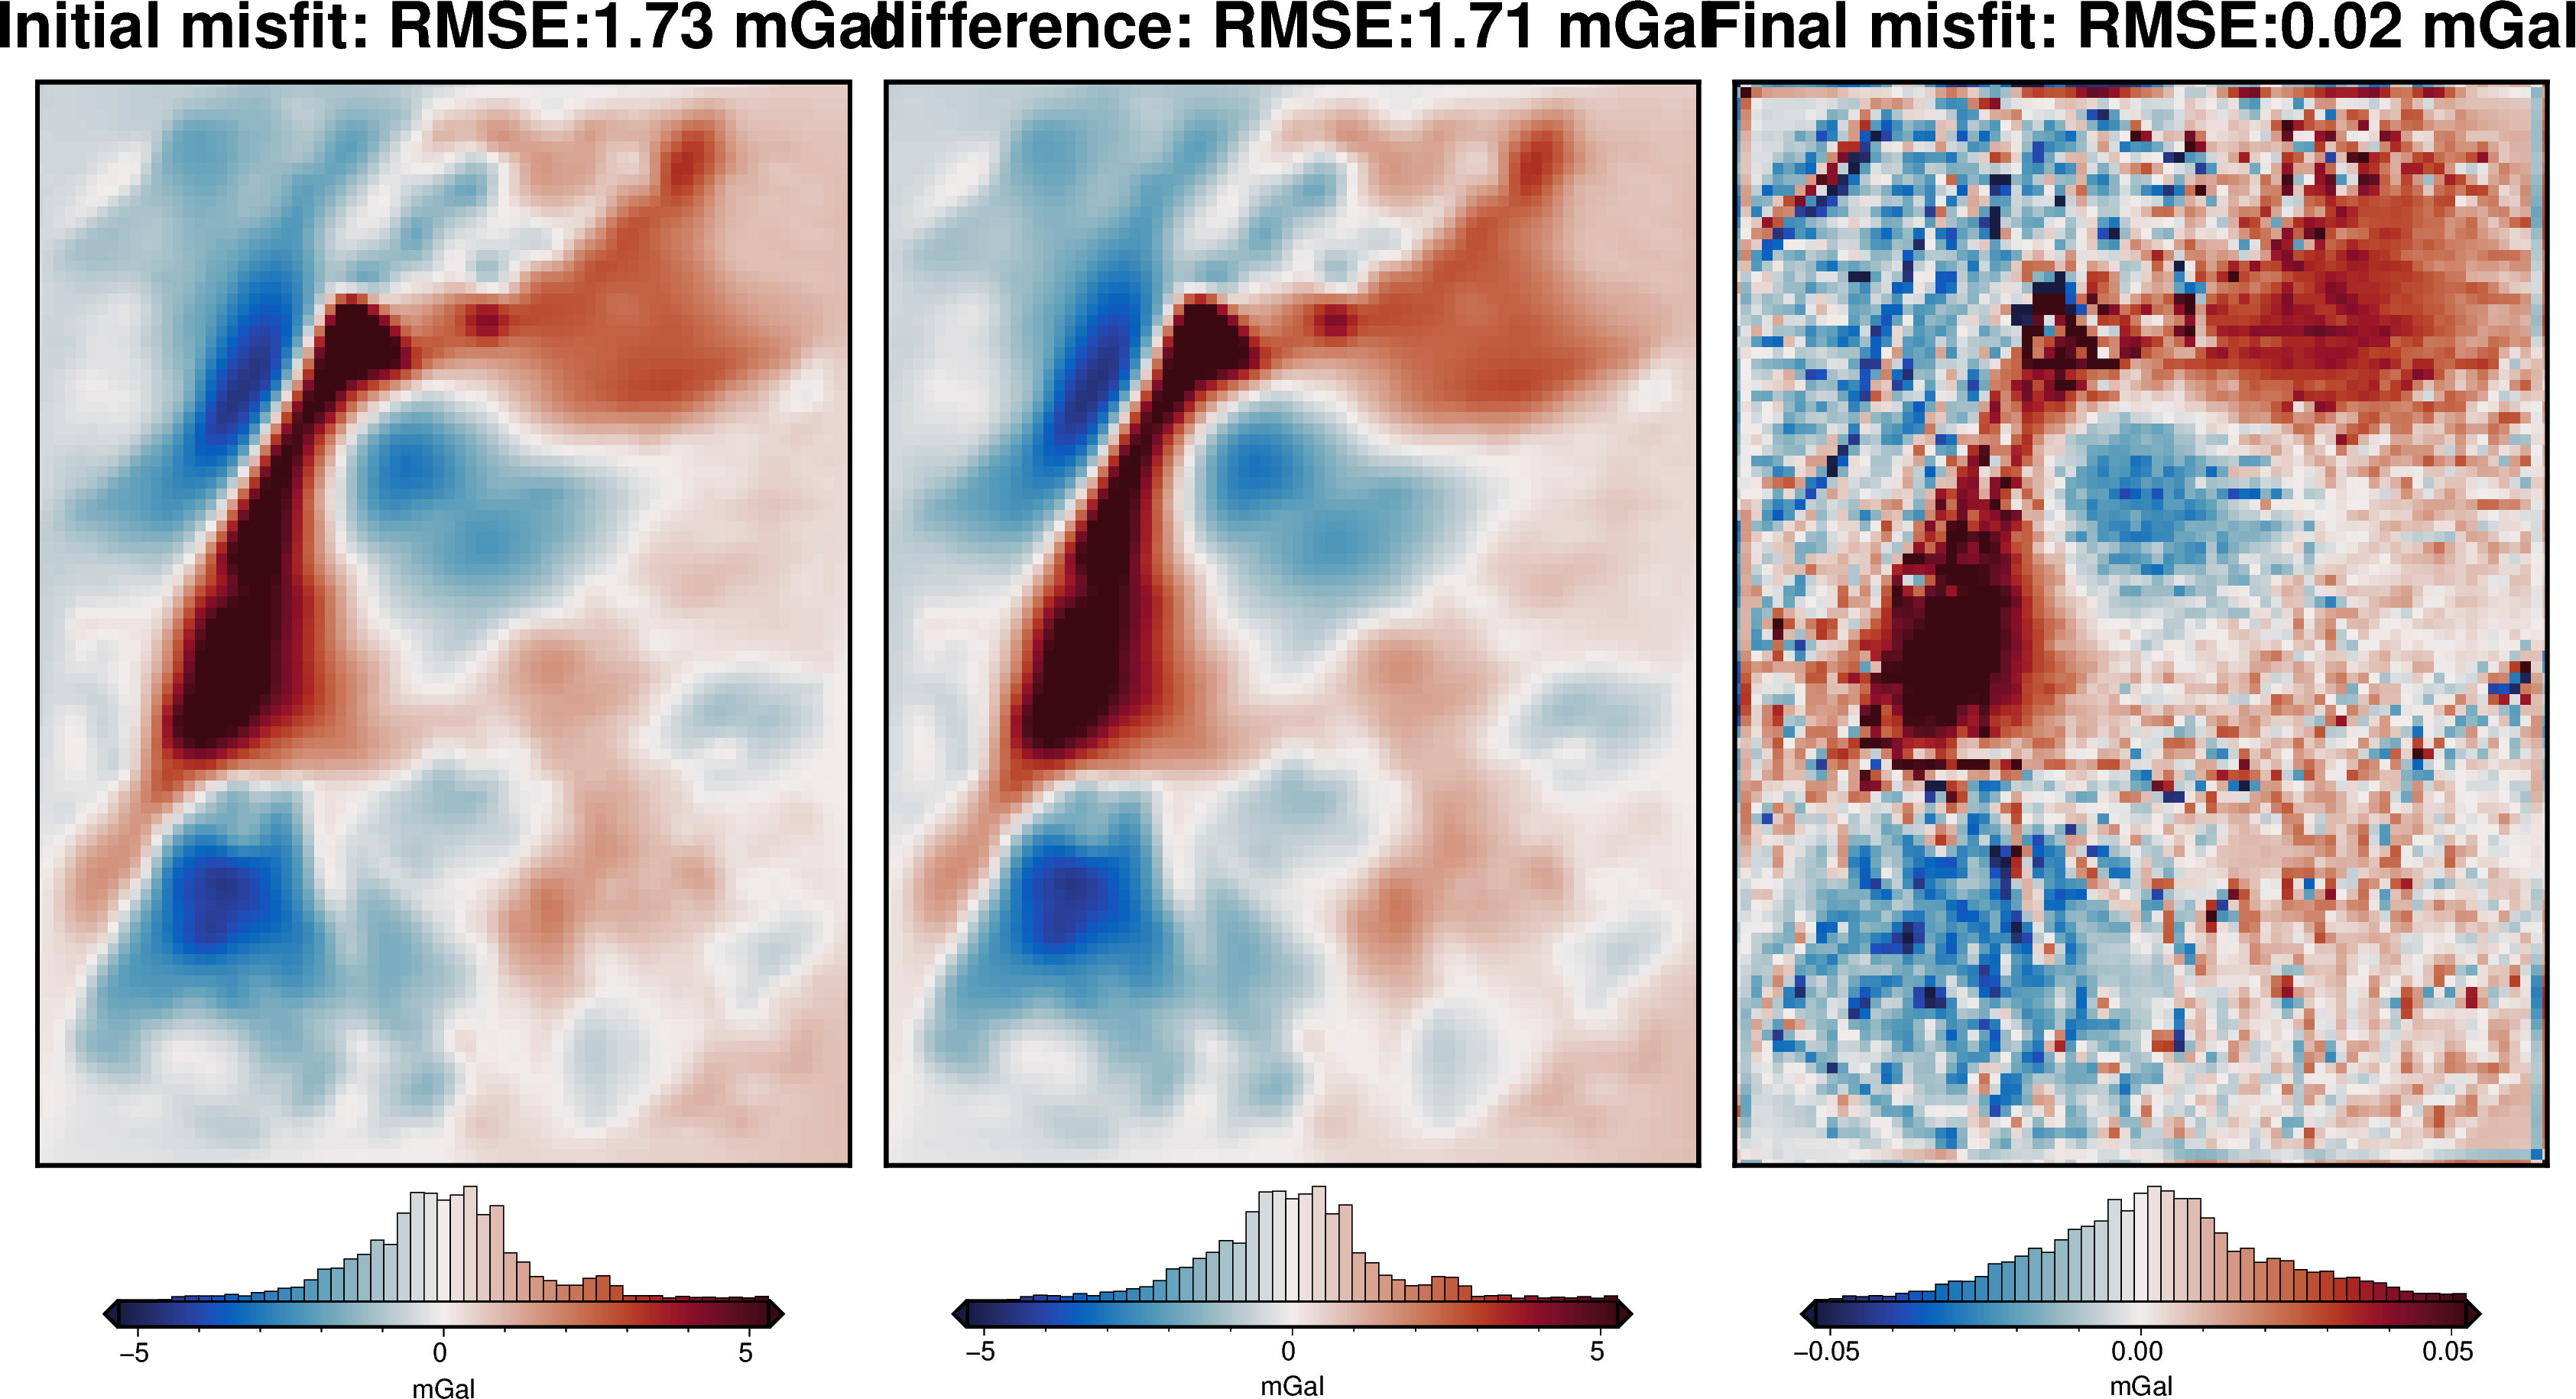

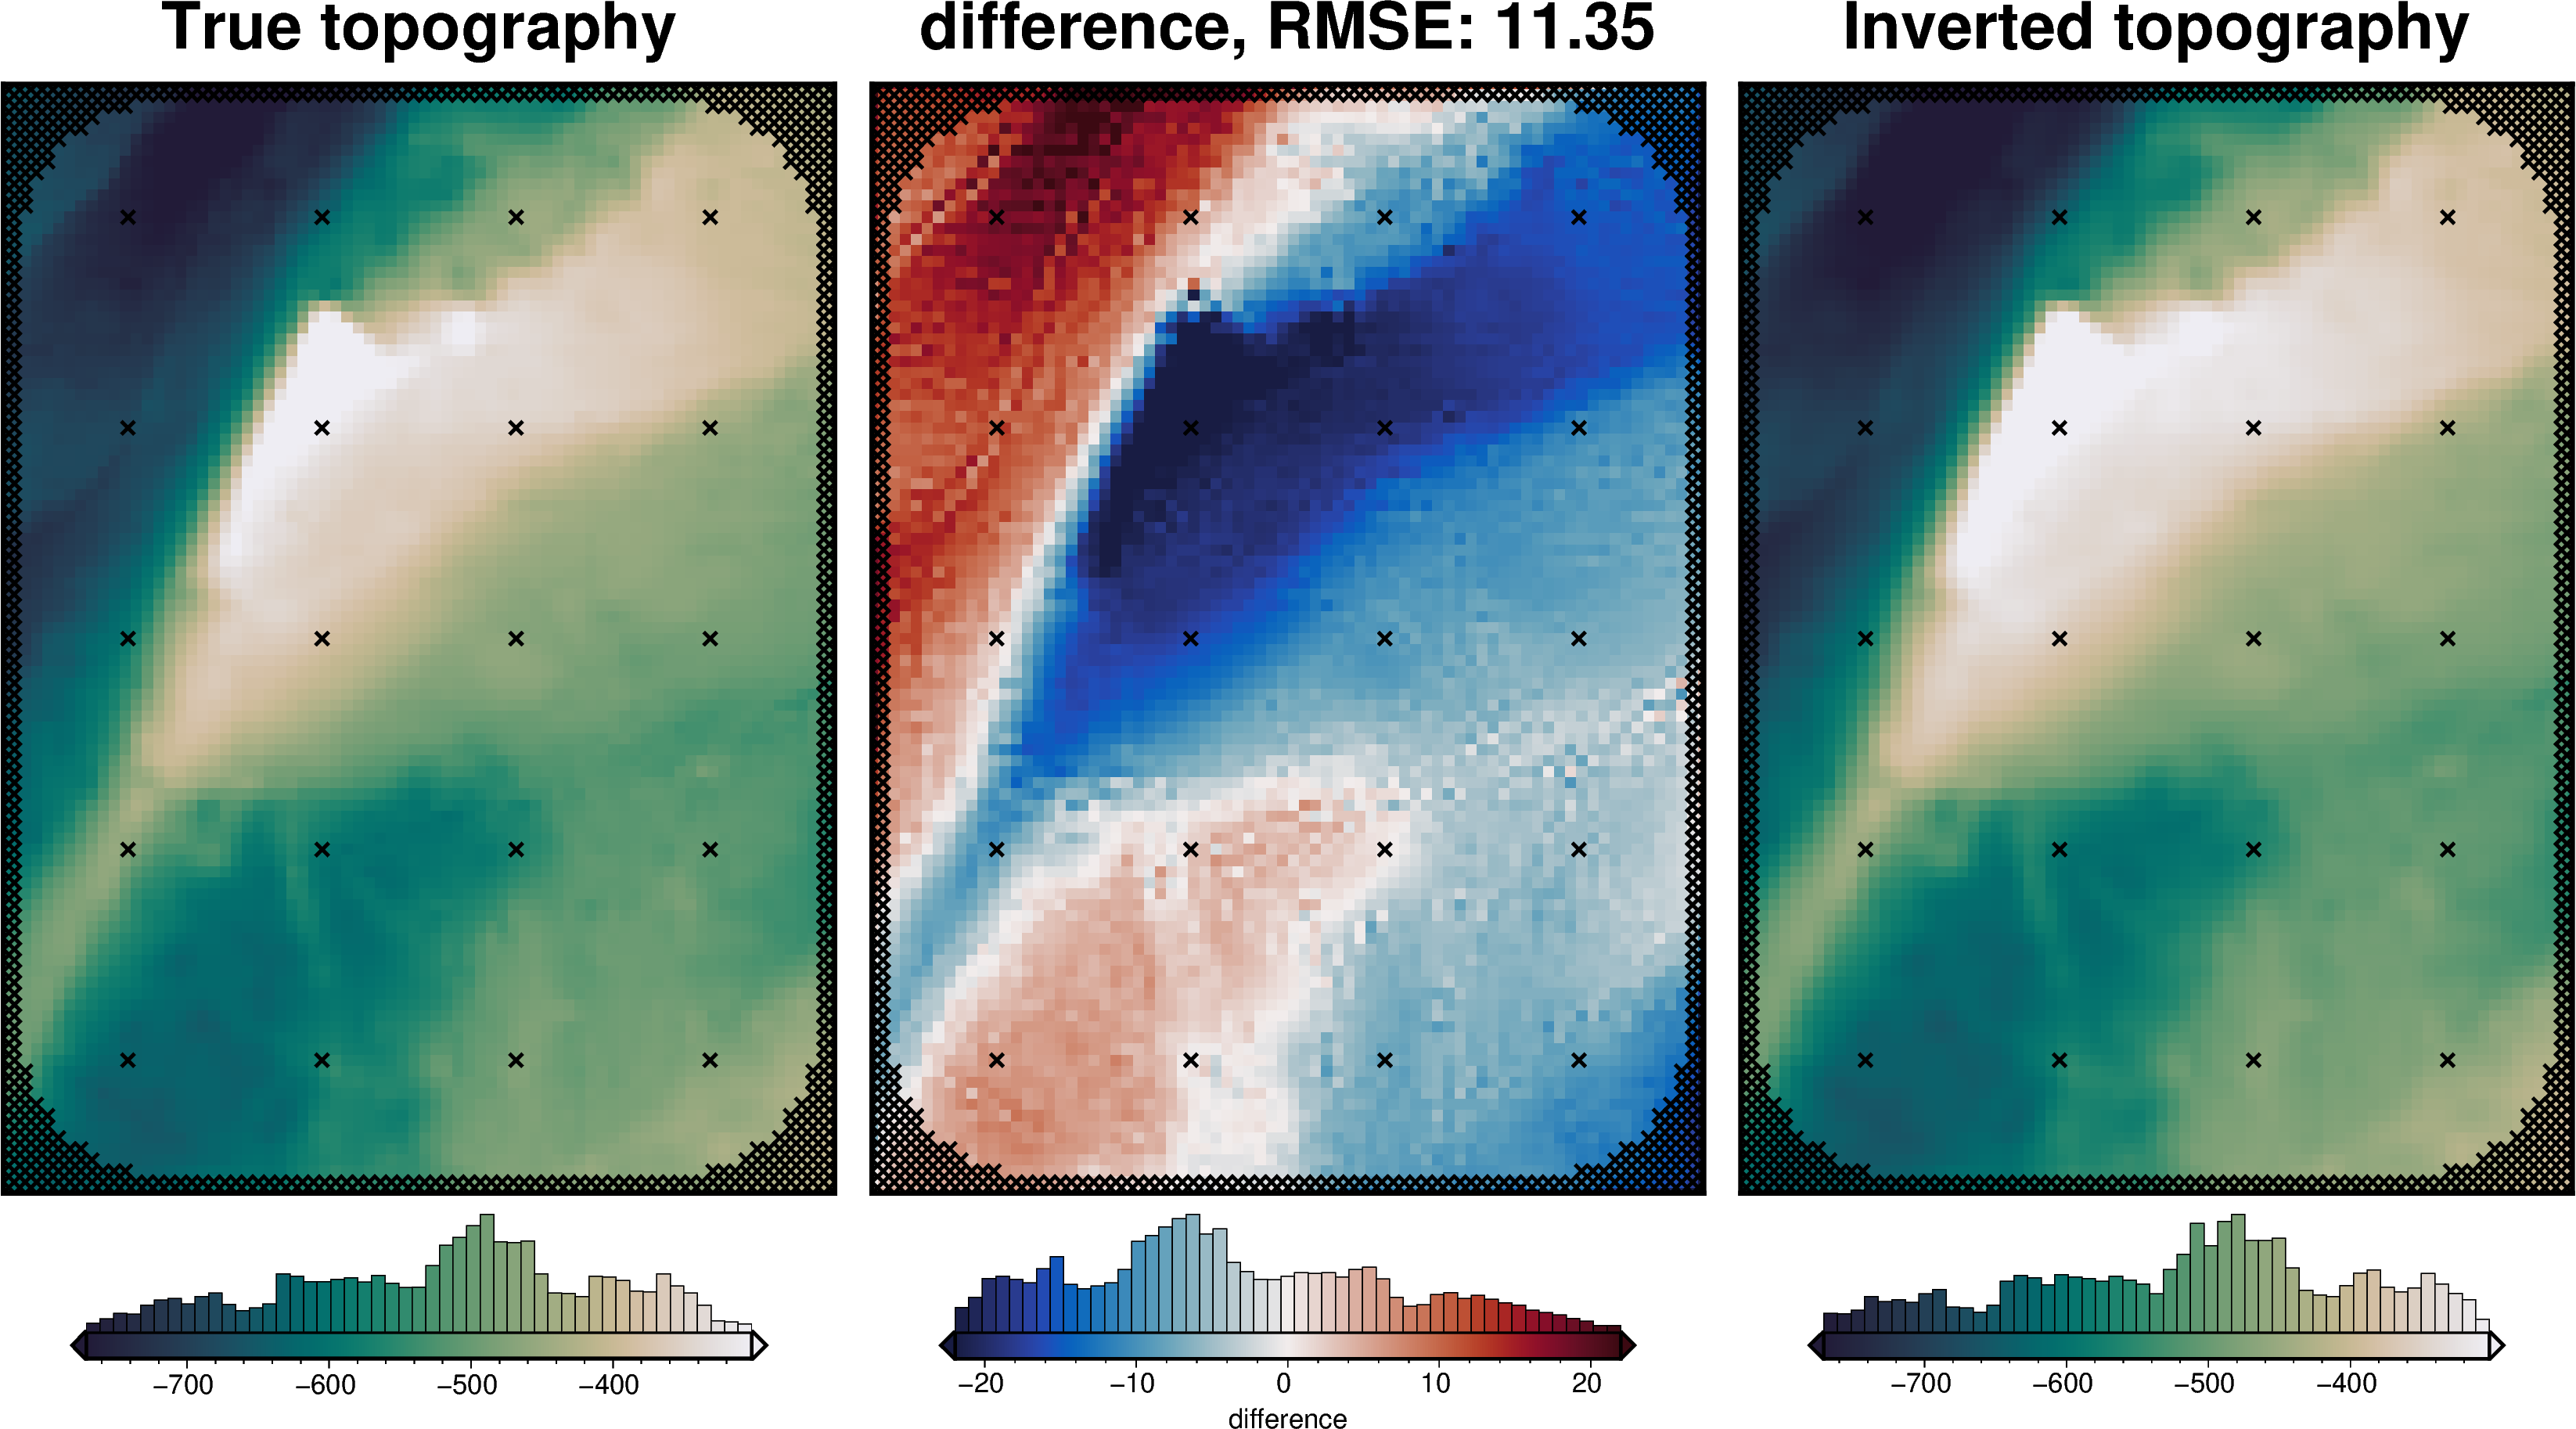

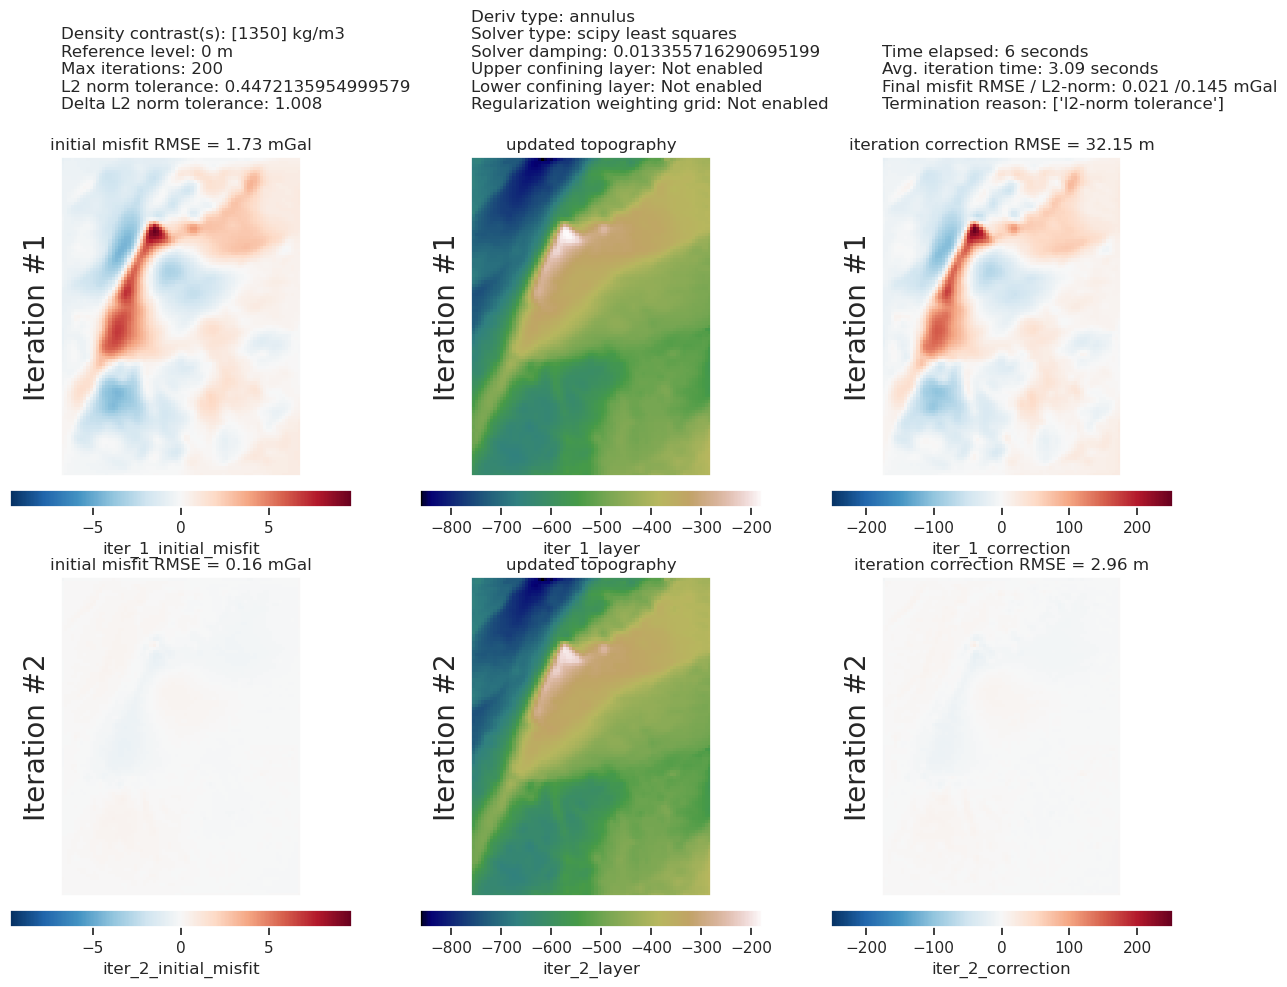

In [22]:
study_df = study.trials_dataframe()

plotting.plot_cv_scores(
    study_df.value,
    study_df.params_damping,
    param_name="Damping",
    logx=True,
    logy=True,
)

plotting.plot_convergence(
    grav_results,
    params=parameters,
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.2c",
)

In [23]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 12.29 m


# Density CV

In [25]:
# kwargs_no_weight = copy.deepcopy(kwargs)
# kwargs_no_weight["apply_weighting_grid"] = False
# kwargs_no_weight["weighting_grid"] = None

In [84]:
logging.getLogger().setLevel(logging.INFO)

# run the inversion workflow, including a cross validation for the damping parameter
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    starting_topography=starting_bathymetry,
    zref=0,
    calculate_regional_misfit=True,
    # regional_grav_kwargs=regional_grav_kwargs,
    regional_grav_kwargs=dict(
        grav_df=grav_df,
        method="constant",
        constant=0,
    ),
    run_zref_or_density_cv=True,
    constraints_df=constraint_points,
    density_contrast_limits=(1300, 1600),
    zref_density_cv_trials=10,
    # plot_cv=True,
    fname="../../results/Ross_Sea_02_density_cv",
    **kwargs,  # _no_weight,
)

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_02_density_cv'
INFO:invert4geom:running zref and/or density contrast cross validation
INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 7
INFO:invert4geom:	parameter: {'density_contrast': 1478}
INFO:invert4geom:	scores: [3.4101909849140135]
INFO:invert4geom:results saved to ../../results/Ross_Sea_02_density_cv_results.pickle


In [24]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_02_density_cv_results.pickle").open(
    "rb"
) as f:
    results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results


# load study
with pathlib.Path(
    "../../results/Ross_Sea_02_density_cv_zref_density_cv_study.pickle"
).open("rb") as f:
    study = pickle.load(f)

In [25]:
best_density_contrast = study.best_params["density_contrast"]
print("optimal determined density contrast", best_density_contrast)
print("real density contrast", true_density_contrast)

optimal determined density contrast 1478
real density contrast 1476


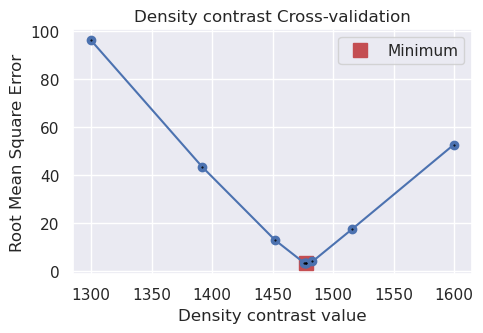

In [26]:
study_df = study.trials_dataframe()

fig = plotting.plot_cv_scores(
    study_df.value,
    study_df.params_density_contrast,
    param_name="Density contrast",
)

### Redo with optimal density contrast
During the density cross-validation to avoid biasing the scores, we had to manually set a regional field. Now, with the optimal density contrast value found, we can rerun the inversion with an automatically determined regional field strength (the average value misfit at the constraints).

In [27]:
density_contrast = best_density_contrast

density_grid = xr.where(
    starting_bathymetry >= zref,
    density_contrast,
    -density_contrast,
)
# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_bathymetry,
    zref,
    density=density_grid,
)
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

grav_df = regional.regional_separation(
    grav_df=grav_df,
    **regional_grav_kwargs,
)

  0%|          | 0/7676 [00:00<?, ?it/s]

INFO:invert4geom:using median gravity misfit of constraint points for regional field: 0.0008630719676148146 mGal


makecpt [ERROR]: Option T: min >= max


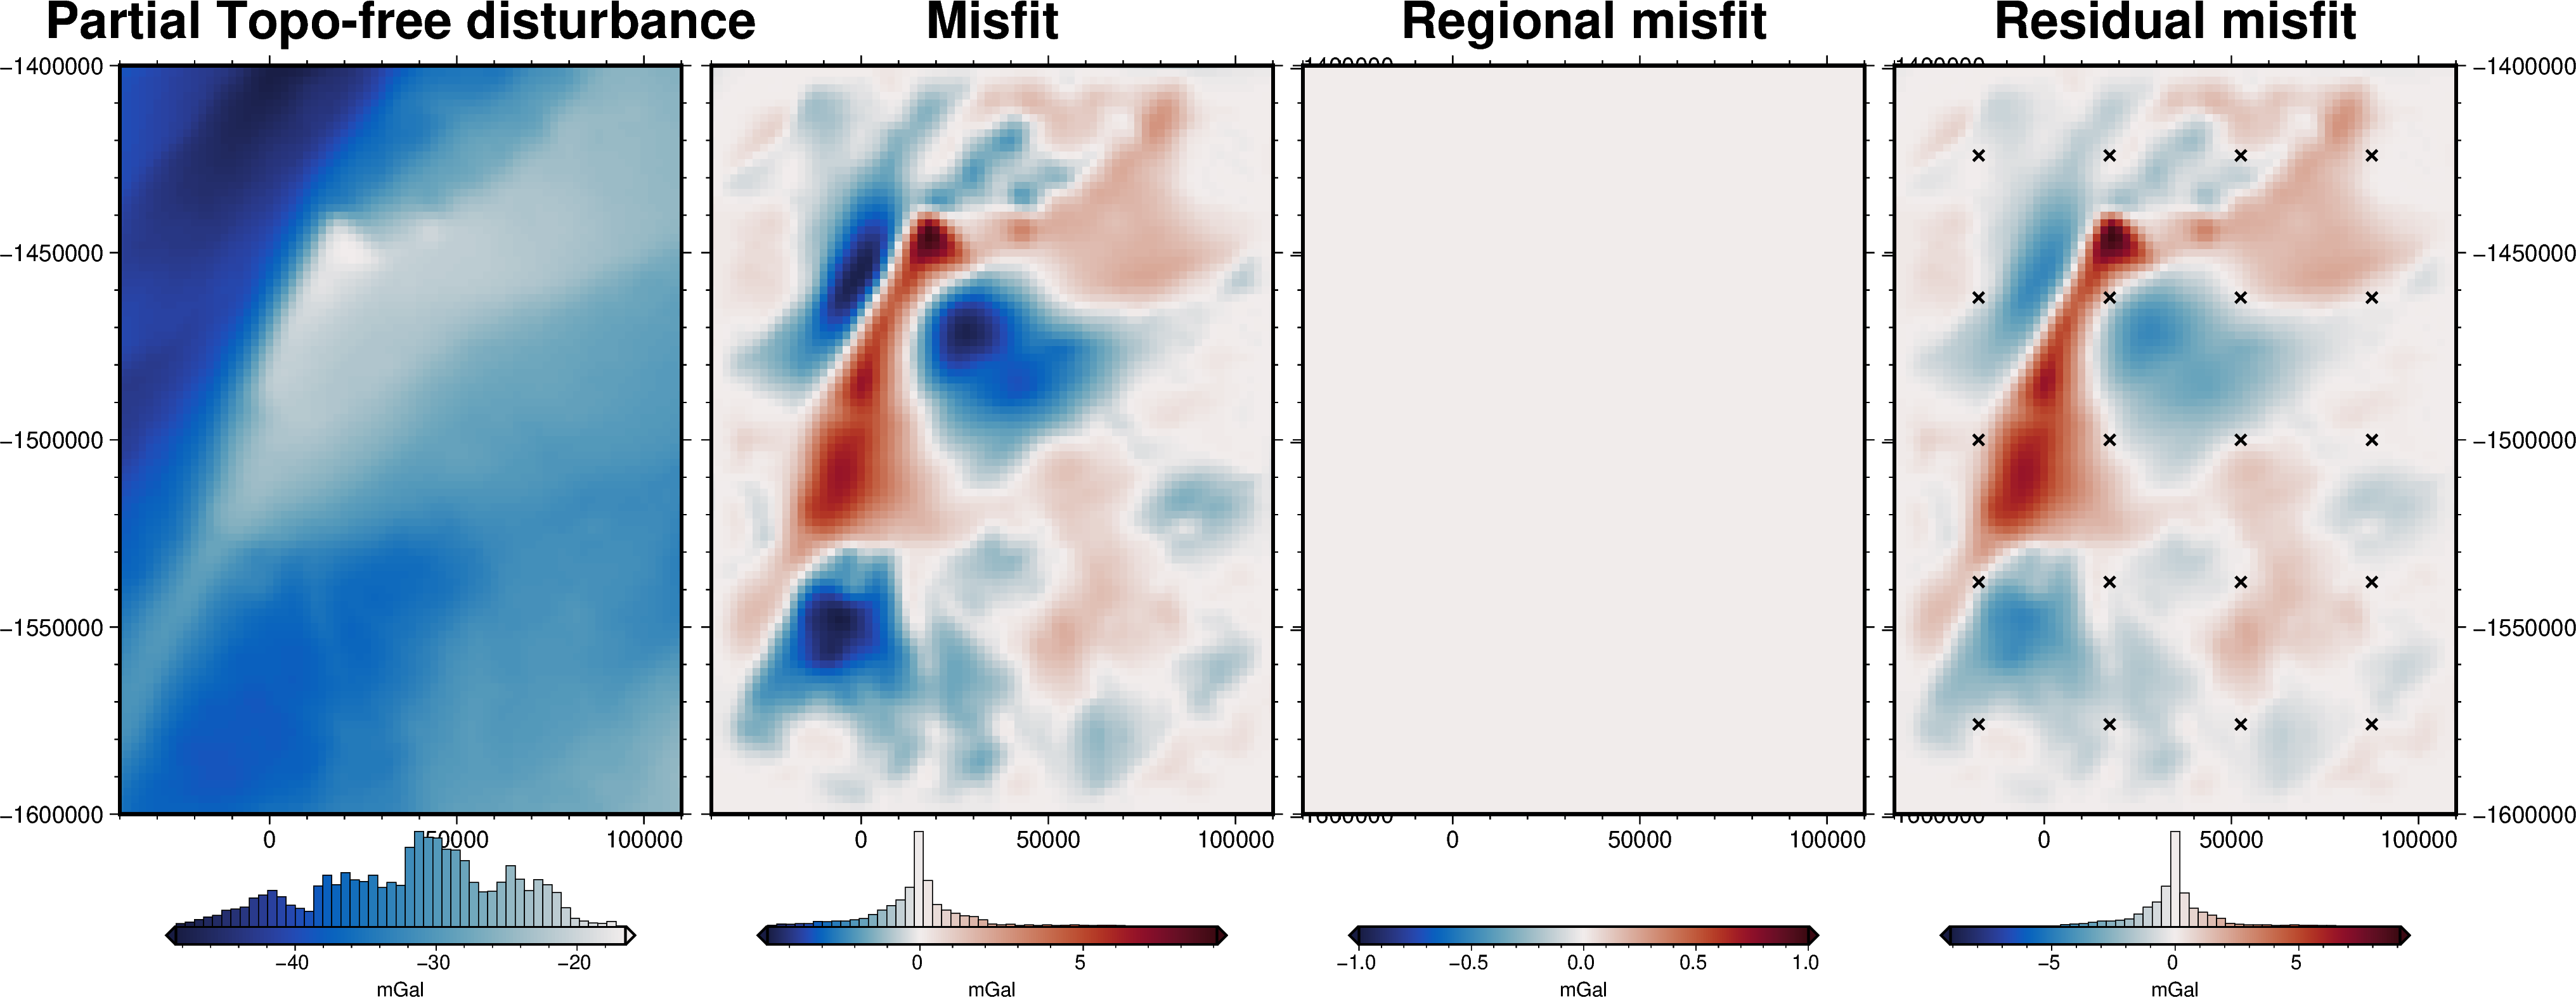

In [28]:
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    region=inversion_region,
    fig_height=10,
    title="Partial Topo-free disturbance",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="balance+h0",
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    hist=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points[constraint_points.inside],
    points_style="x.2c",
)
fig.show()

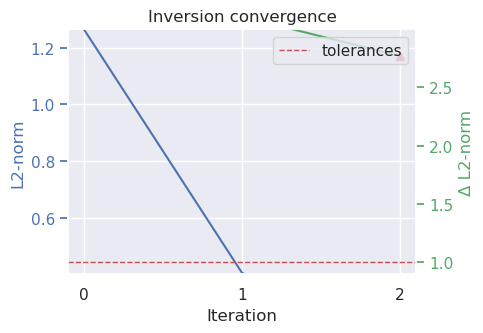

In [91]:
# run the inversion workflow
inversion_results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    fname="../../results/Ross_Sea_02_optimal",
    starting_prisms=starting_prisms,
    plot_dynamic_convergence=True,
    **kwargs,
)

In [29]:
# load saved inversion results
with pathlib.Path("../../results/Ross_Sea_02_optimal_results.pickle").open("rb") as f:
    results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

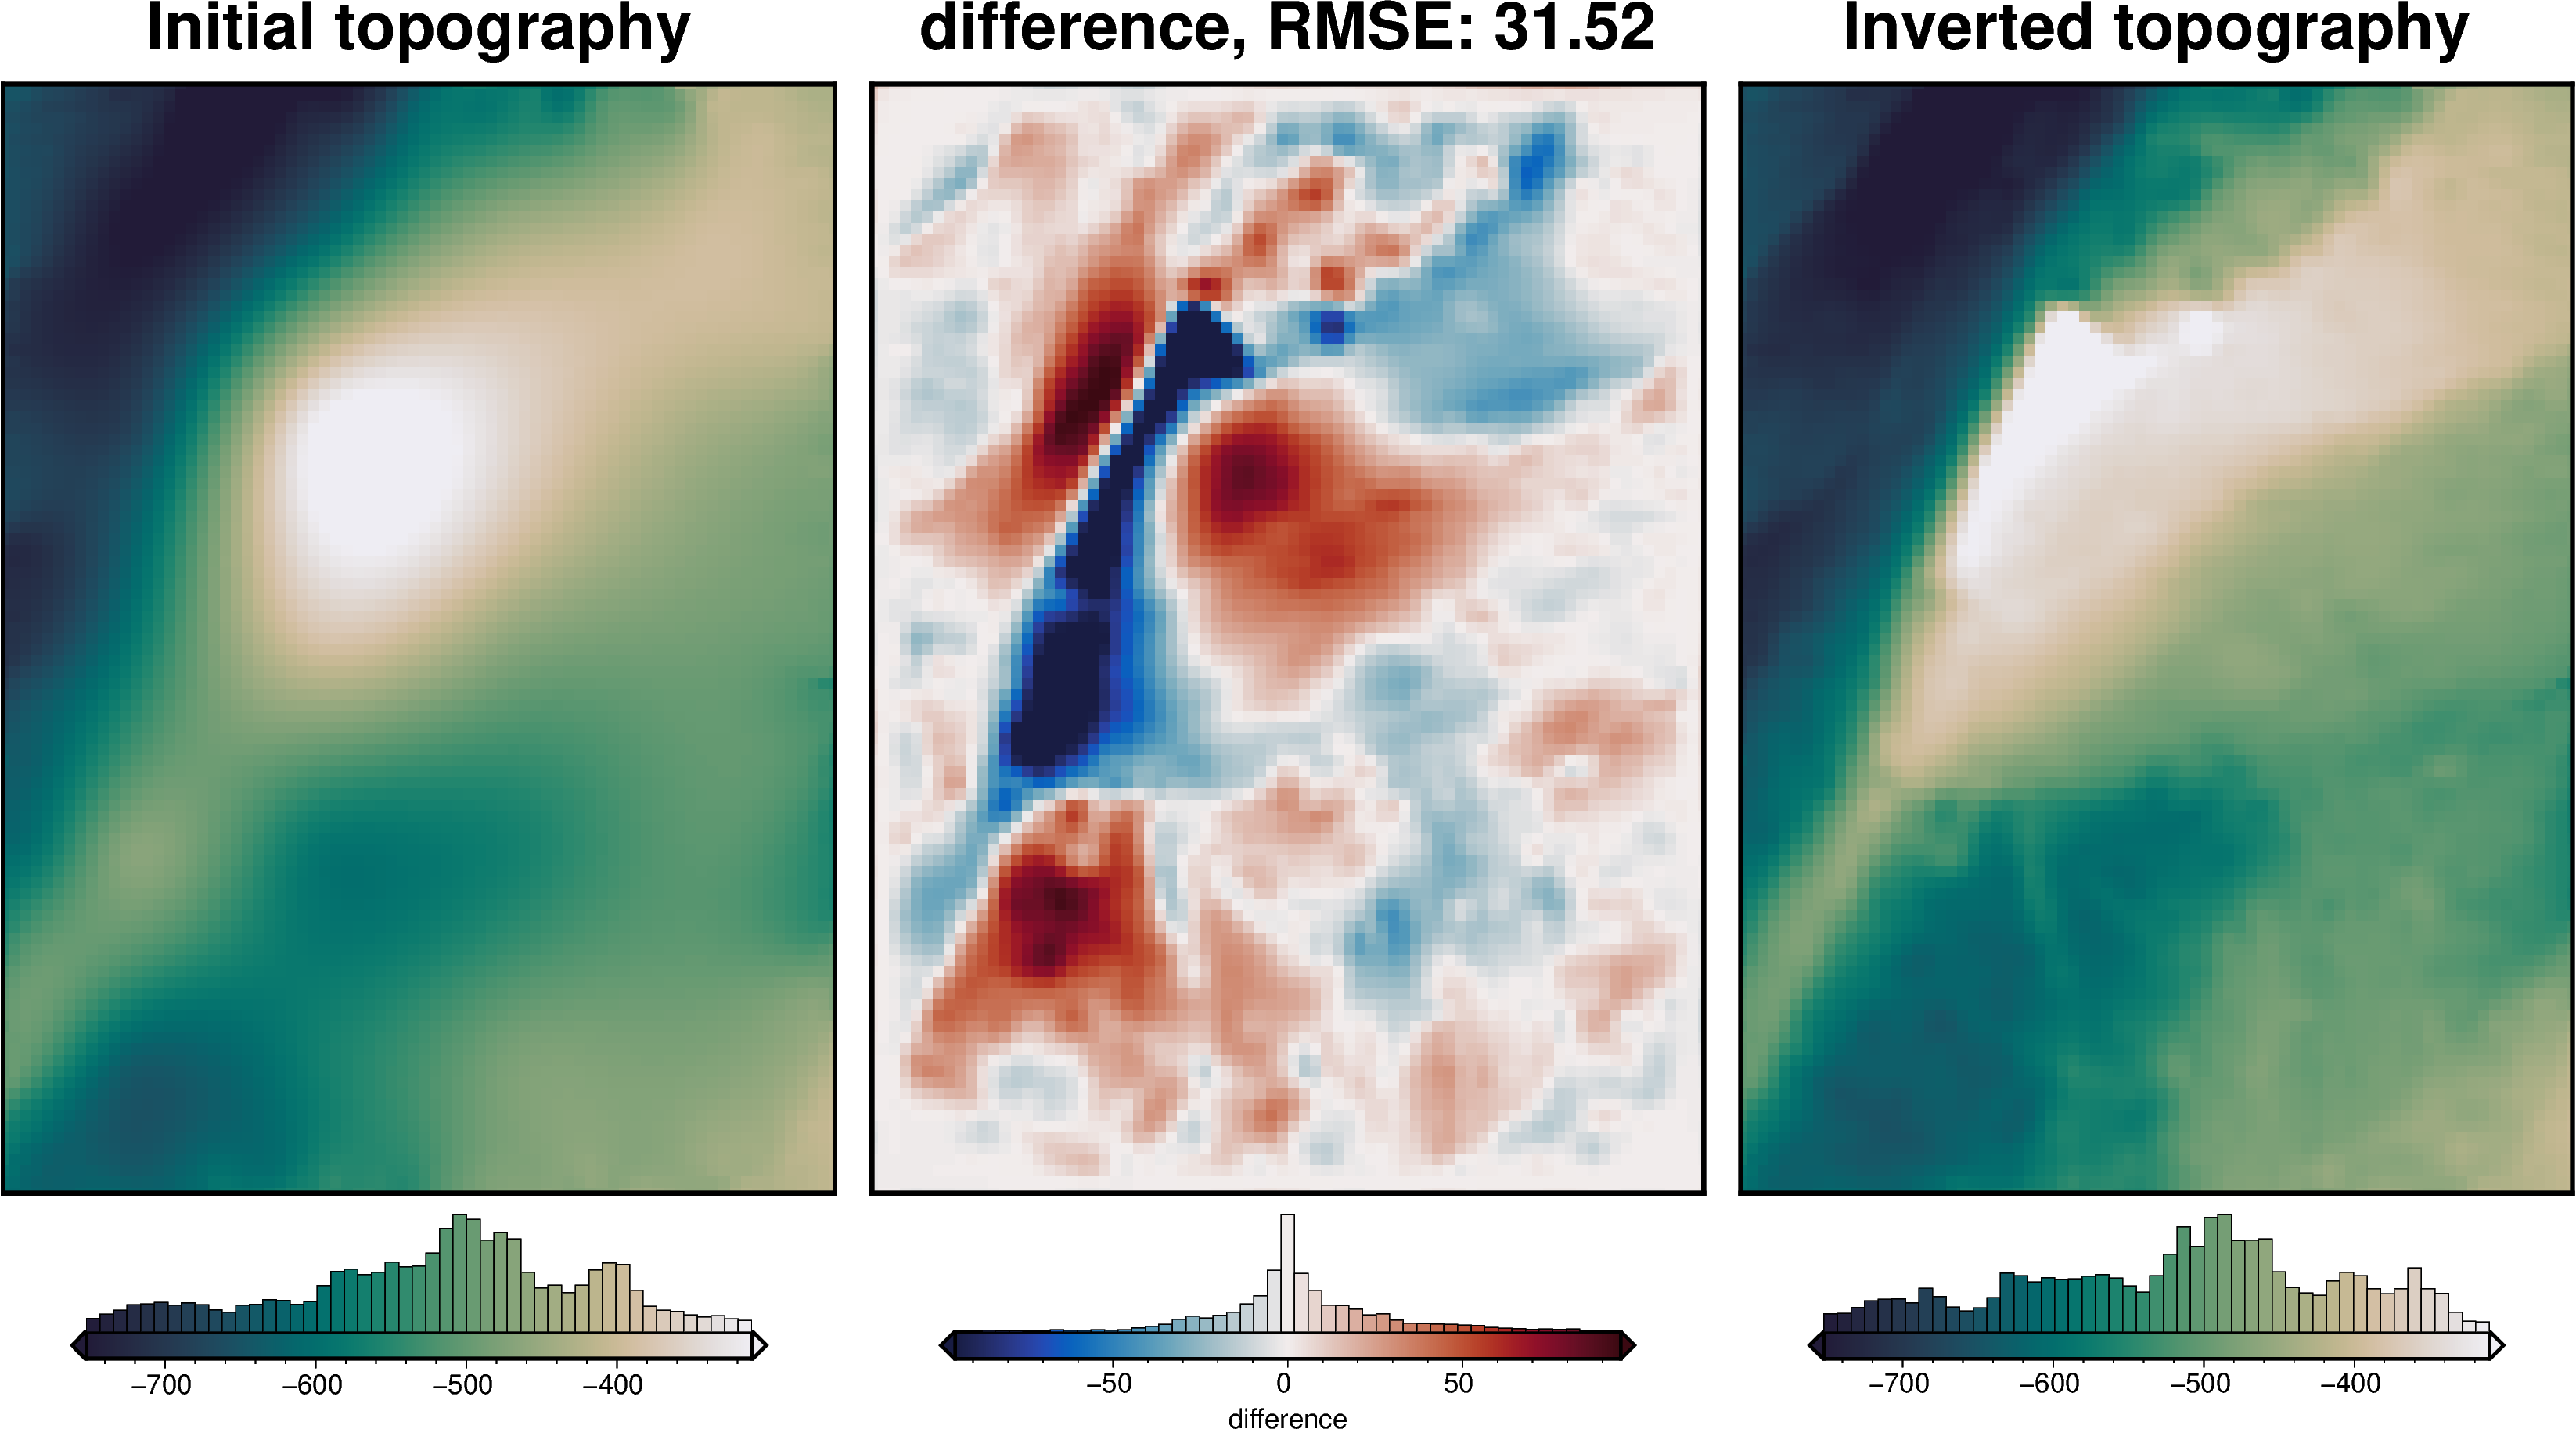

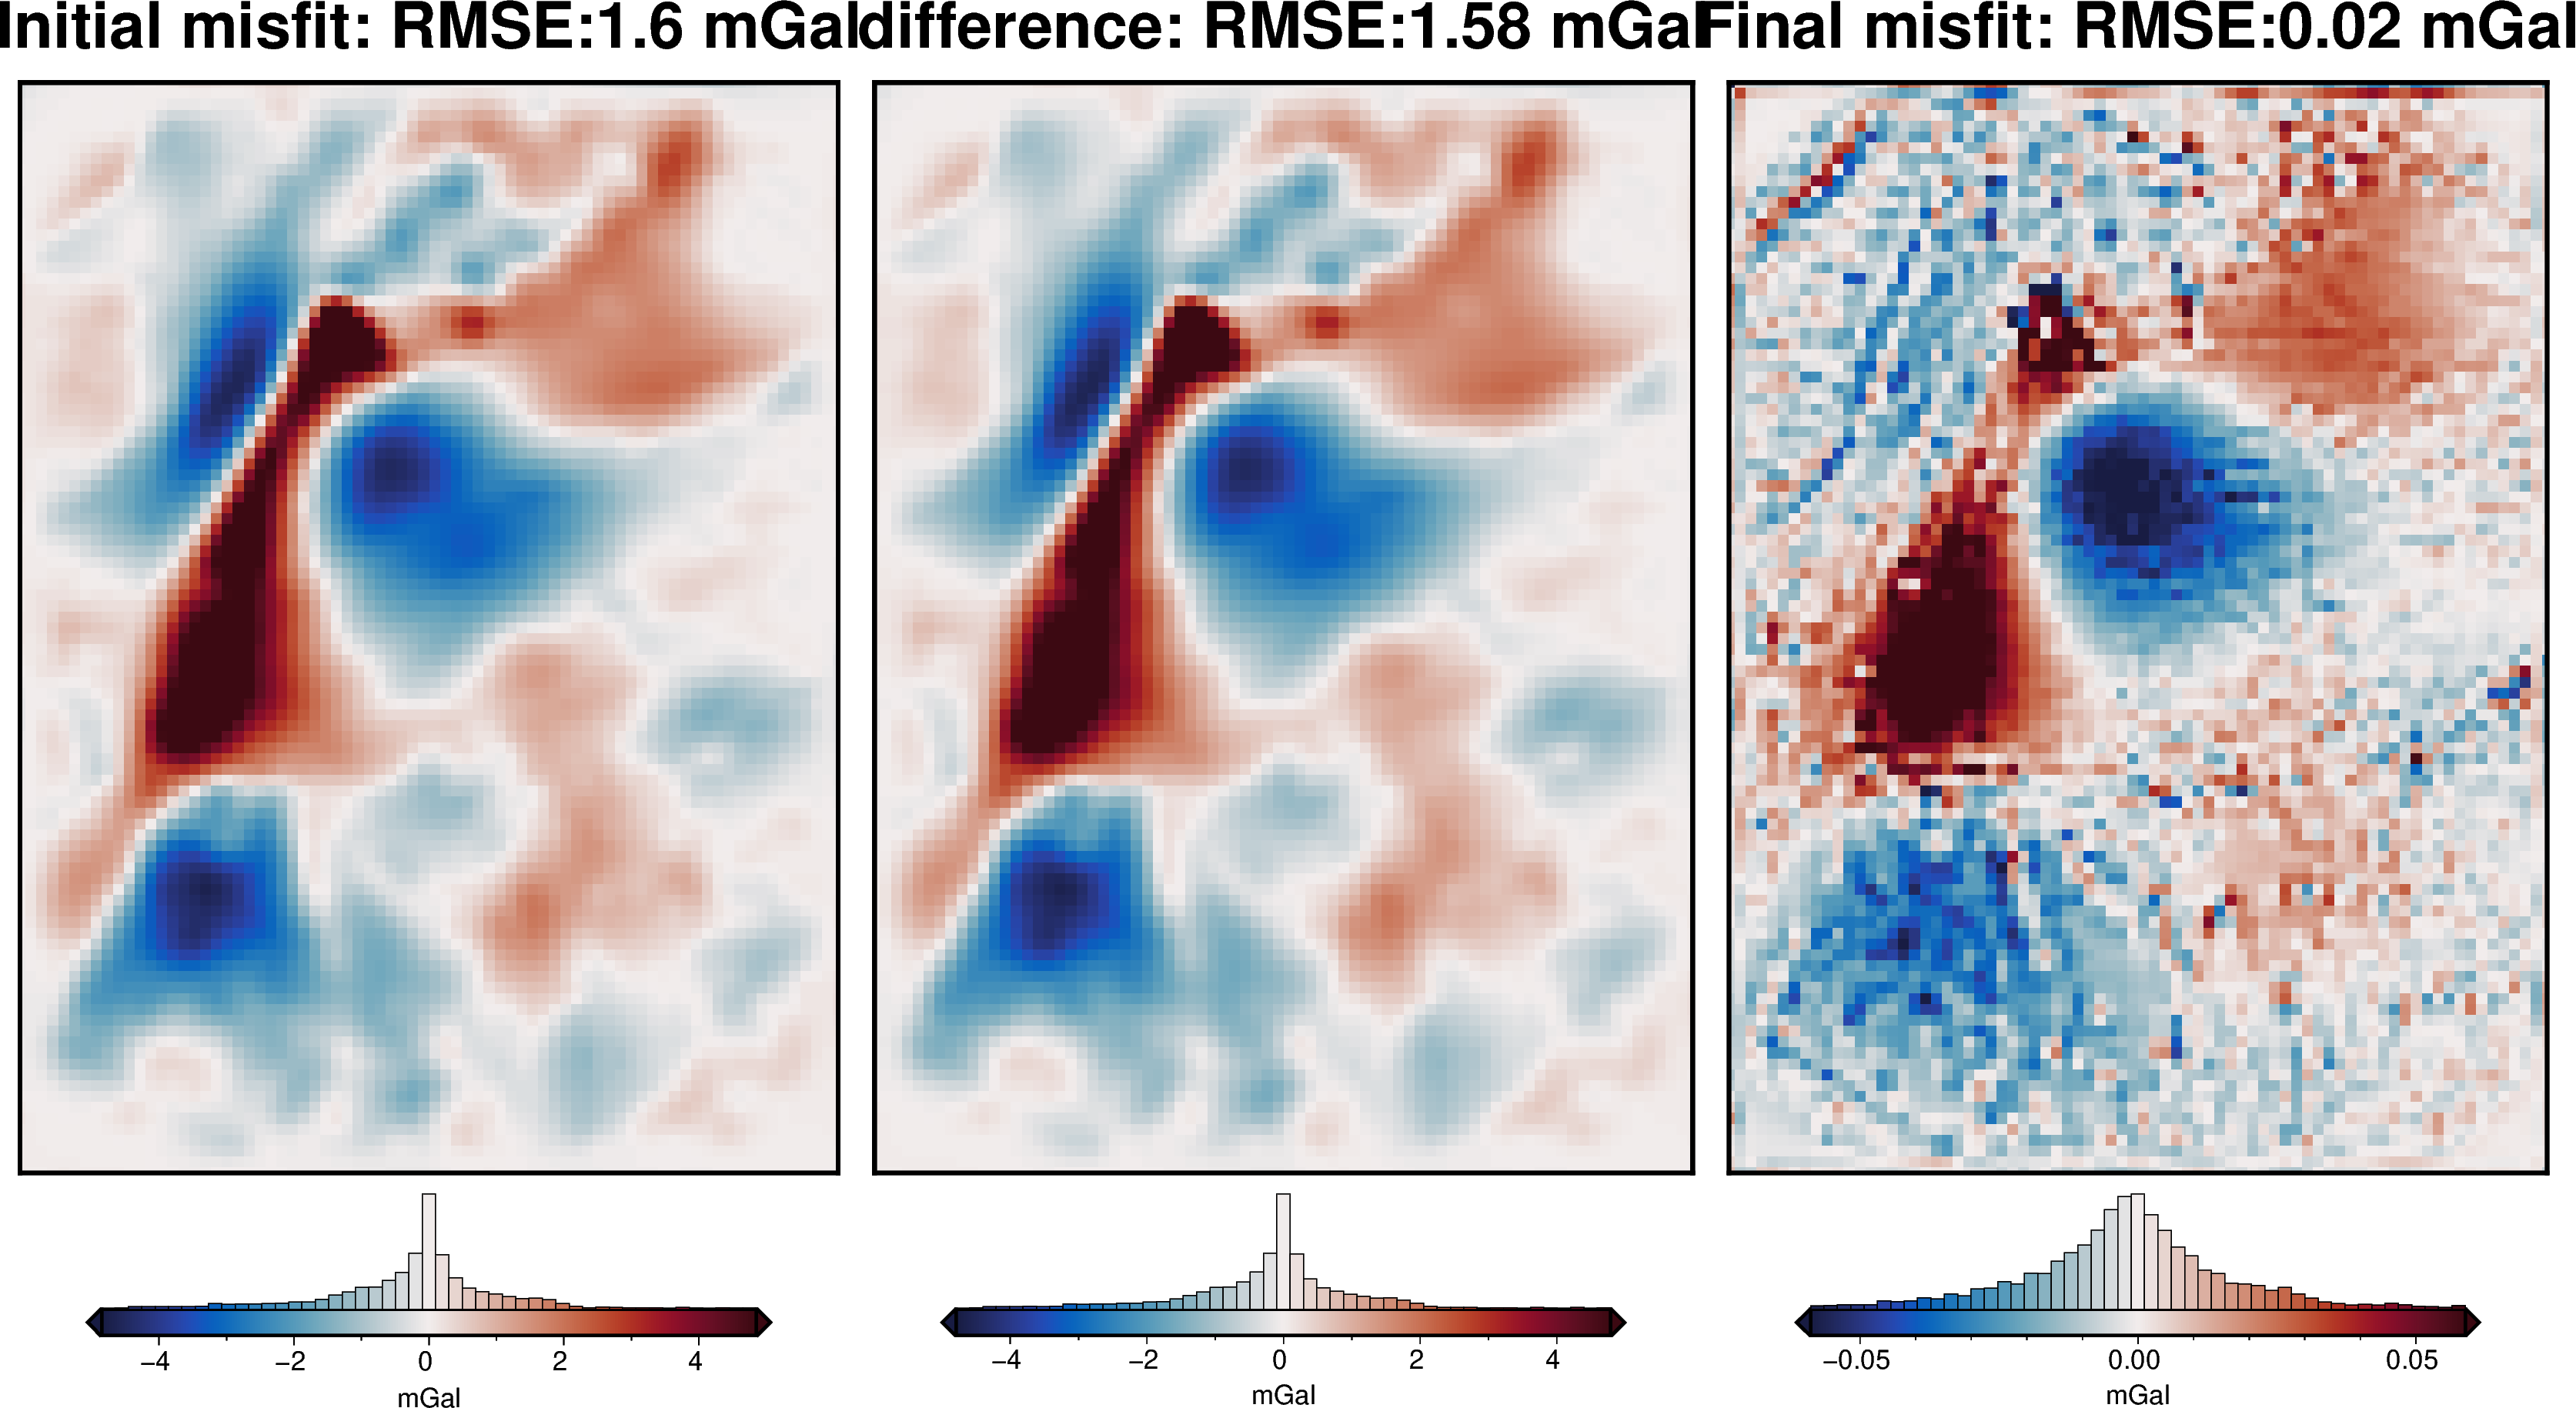

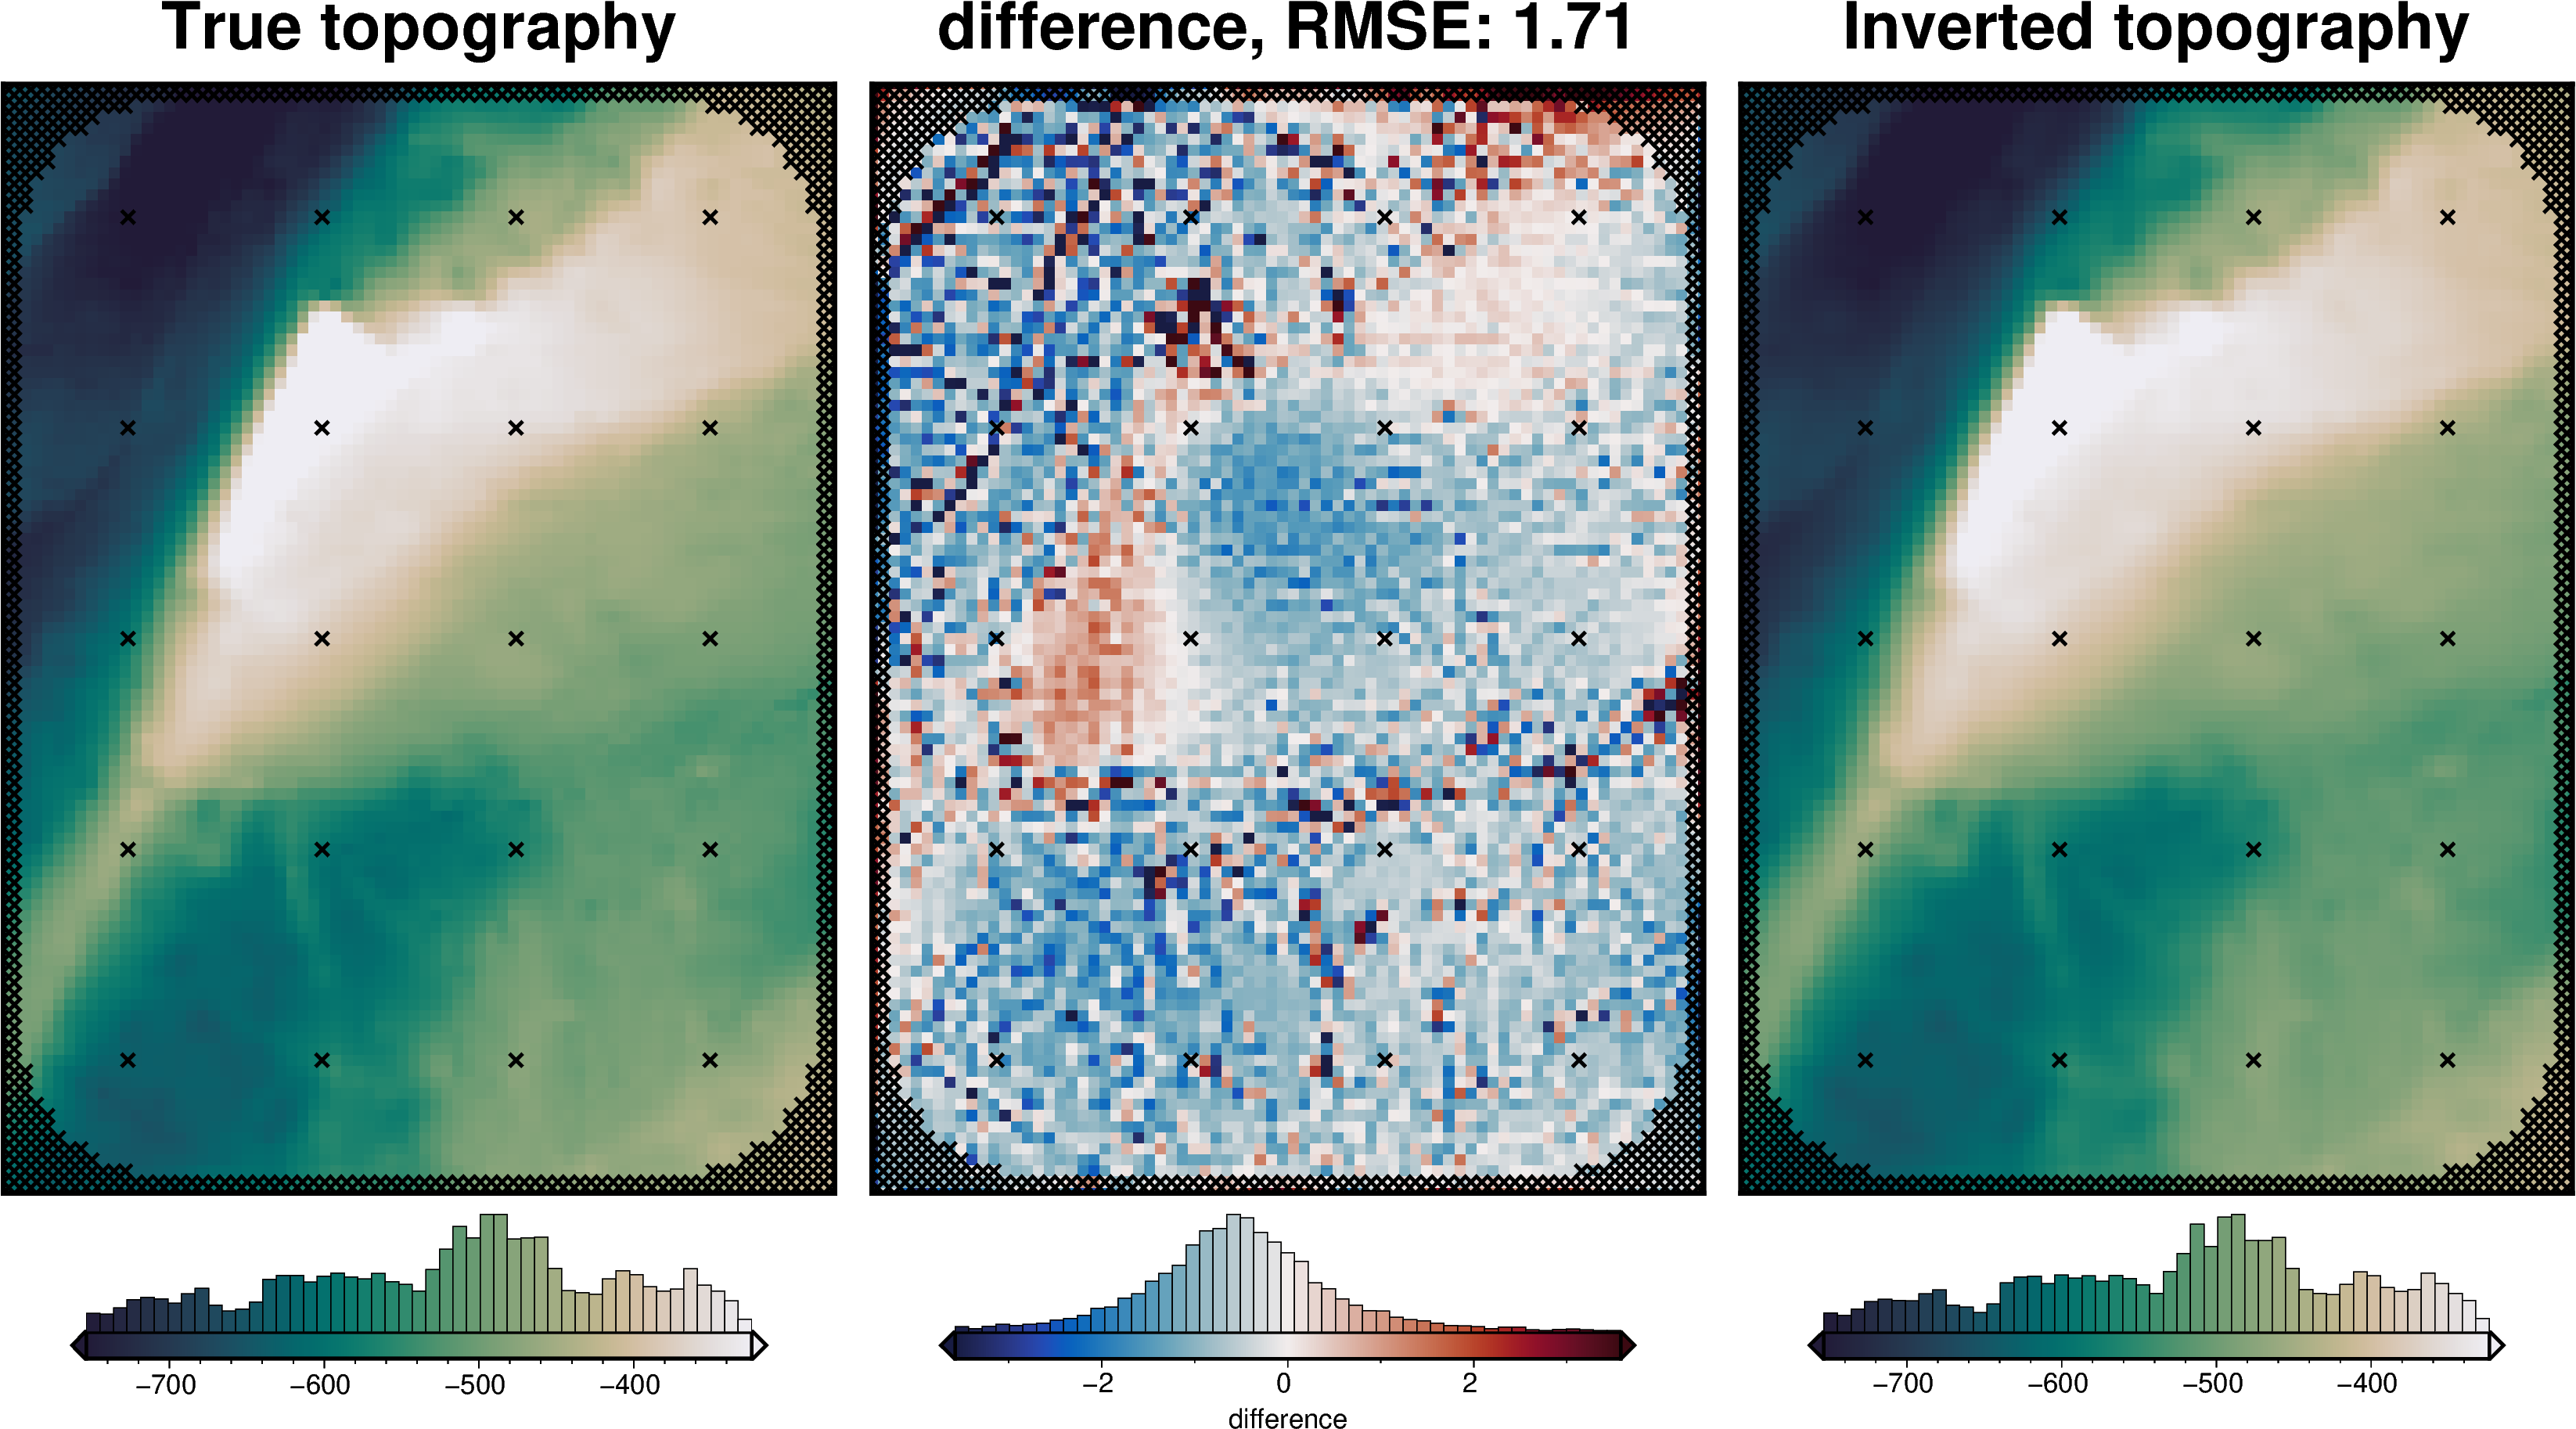

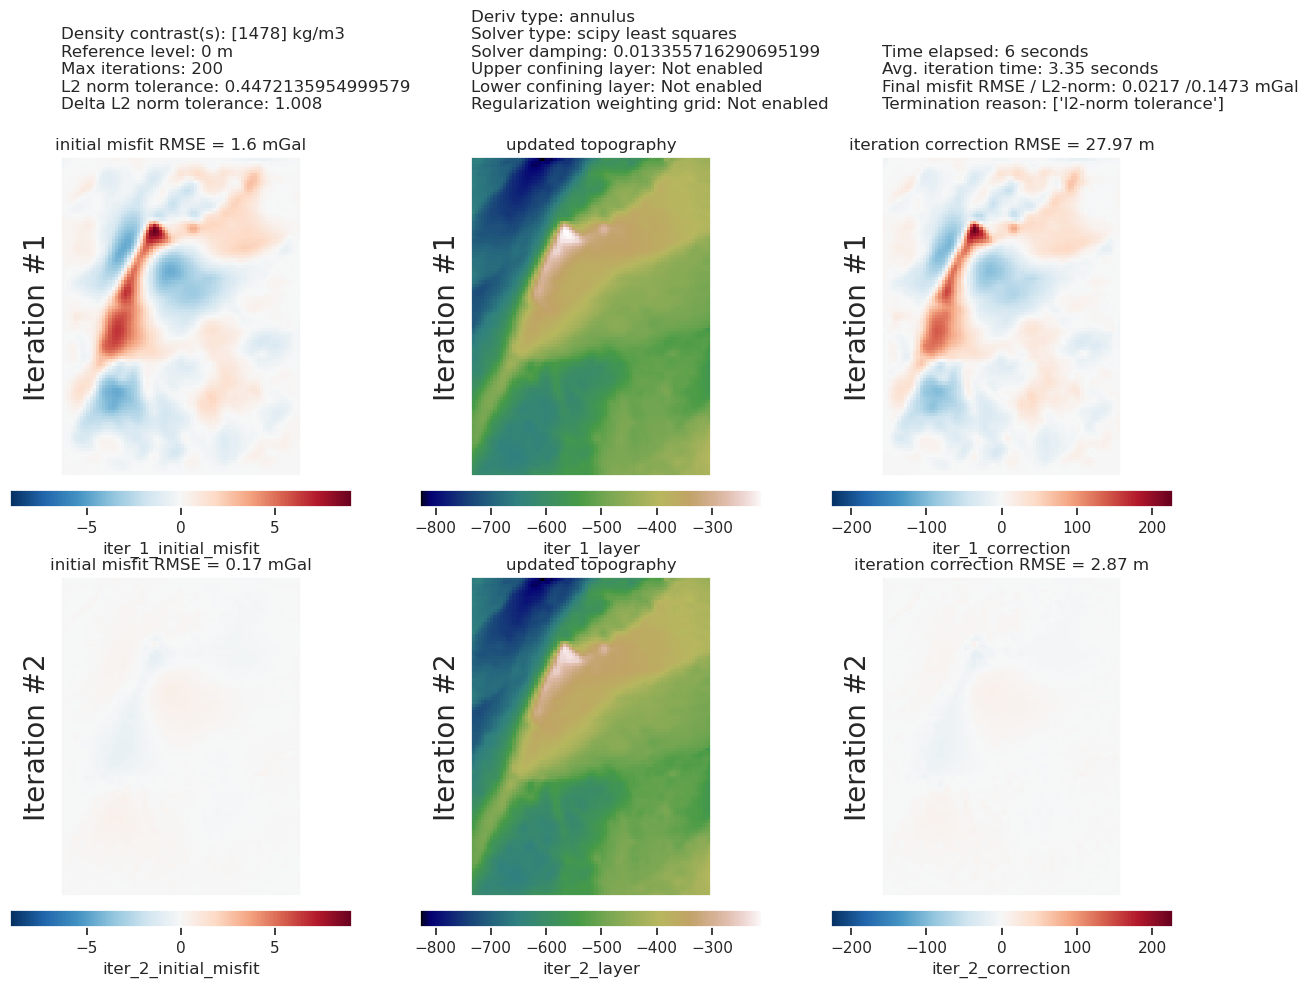

In [30]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    bathymetry,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.2c",
)

In [31]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 3.41 m


In [32]:
# save to csv
constraint_points.to_csv("../../results/Ross_Sea_02_constraint_points.csv", index=False)

# Uncertainty analysis

## Inversion error

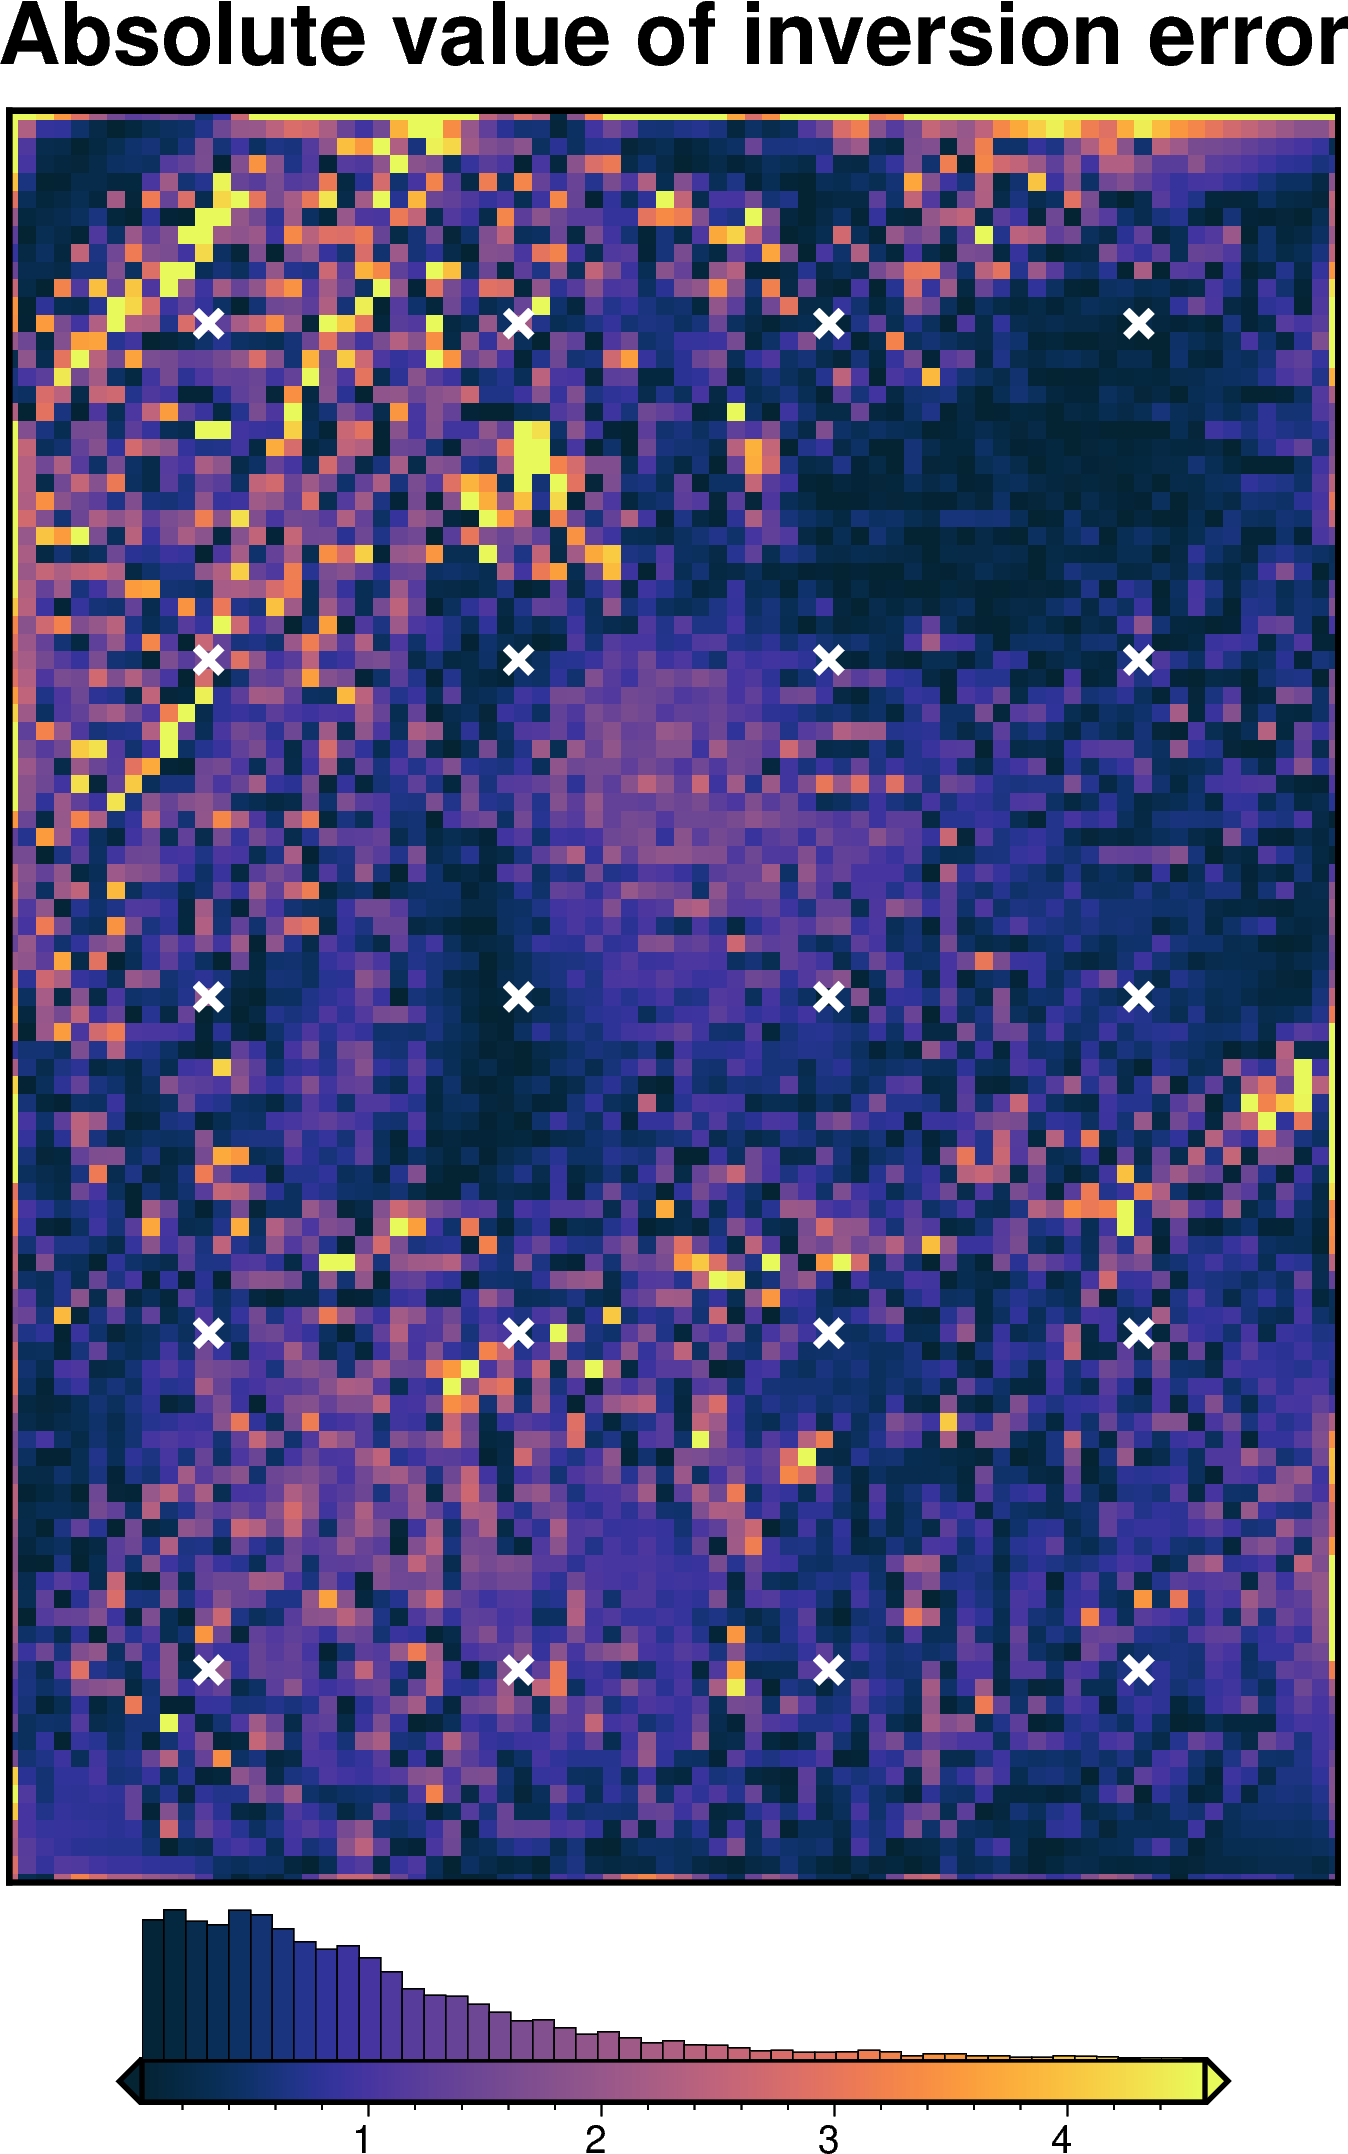

In [33]:
inversion_error = np.abs(bathymetry - final_topography)

fig = maps.plot_grd(
    inversion_error,
    # region=vd.pad_region(inversion_region, -3*spacing),
    region=inversion_region,
    hist=True,
    cmap="thermal",
    title="Absolute value of inversion error",
    robust=True,
    points=constraint_points[constraint_points.inside],
    points_style="x.3c",
    points_fill="white",
    points_pen="2p",
)
fig.show()

In [34]:
# kwargs to reuse for all uncertainty analyses
uncert_kwargs = dict(
    grav_df=grav_df,
    density_contrast=best_density_contrast,
    zref=zref,
    starting_prisms=starting_prisms,
    starting_topography=starting_bathymetry,
    regional_grav_kwargs=regional_grav_kwargs,
    **kwargs,
)

## Solver damping component

In [35]:
# load study
with pathlib.Path("../../results/Ross_Sea_02_damping_cv_damping_cv_study.pickle").open(
    "rb"
) as f:
    study = pickle.load(f)

study_df = study.trials_dataframe().drop(columns=["user_attrs_results"])
study_df = study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

# pick damping standard deviation based on optimization
stdev = np.log10(study_df2.params_damping).std()
print(f"calculated stdev: {stdev}")
stdev = stdev / 4
print(f"using stdev: {stdev}")

calculated stdev: 0.4776299813394695
using stdev: 0.11940749533486737


best: 0.013355716290695199 
std: 0.11940749533486737 
+1std: 0.017582259285253733 
-1std: 0.010145178429210438


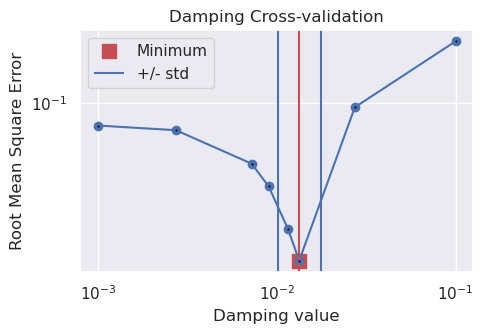

In [36]:
fig = plotting.plot_cv_scores(
    study_df.value,
    study_df.params_damping,
    param_name="Damping",
    logx=True,
    logy=True,
)
ax = fig.axes[0]

best = float(study_df2.params_damping.iloc[0])
upper = float(10 ** (np.log10(best) + stdev))
lower = float(10 ** (np.log10(best) - stdev))

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.013805415031301334, min: 0.00849687703295942, max: 0.02099302566644464
INFO:invert4geom:No pickle files starting with '../../results/Ross_Sea_02_uncertainty_damping' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../../results/Ross_Sea_02_uncertainty_damping'



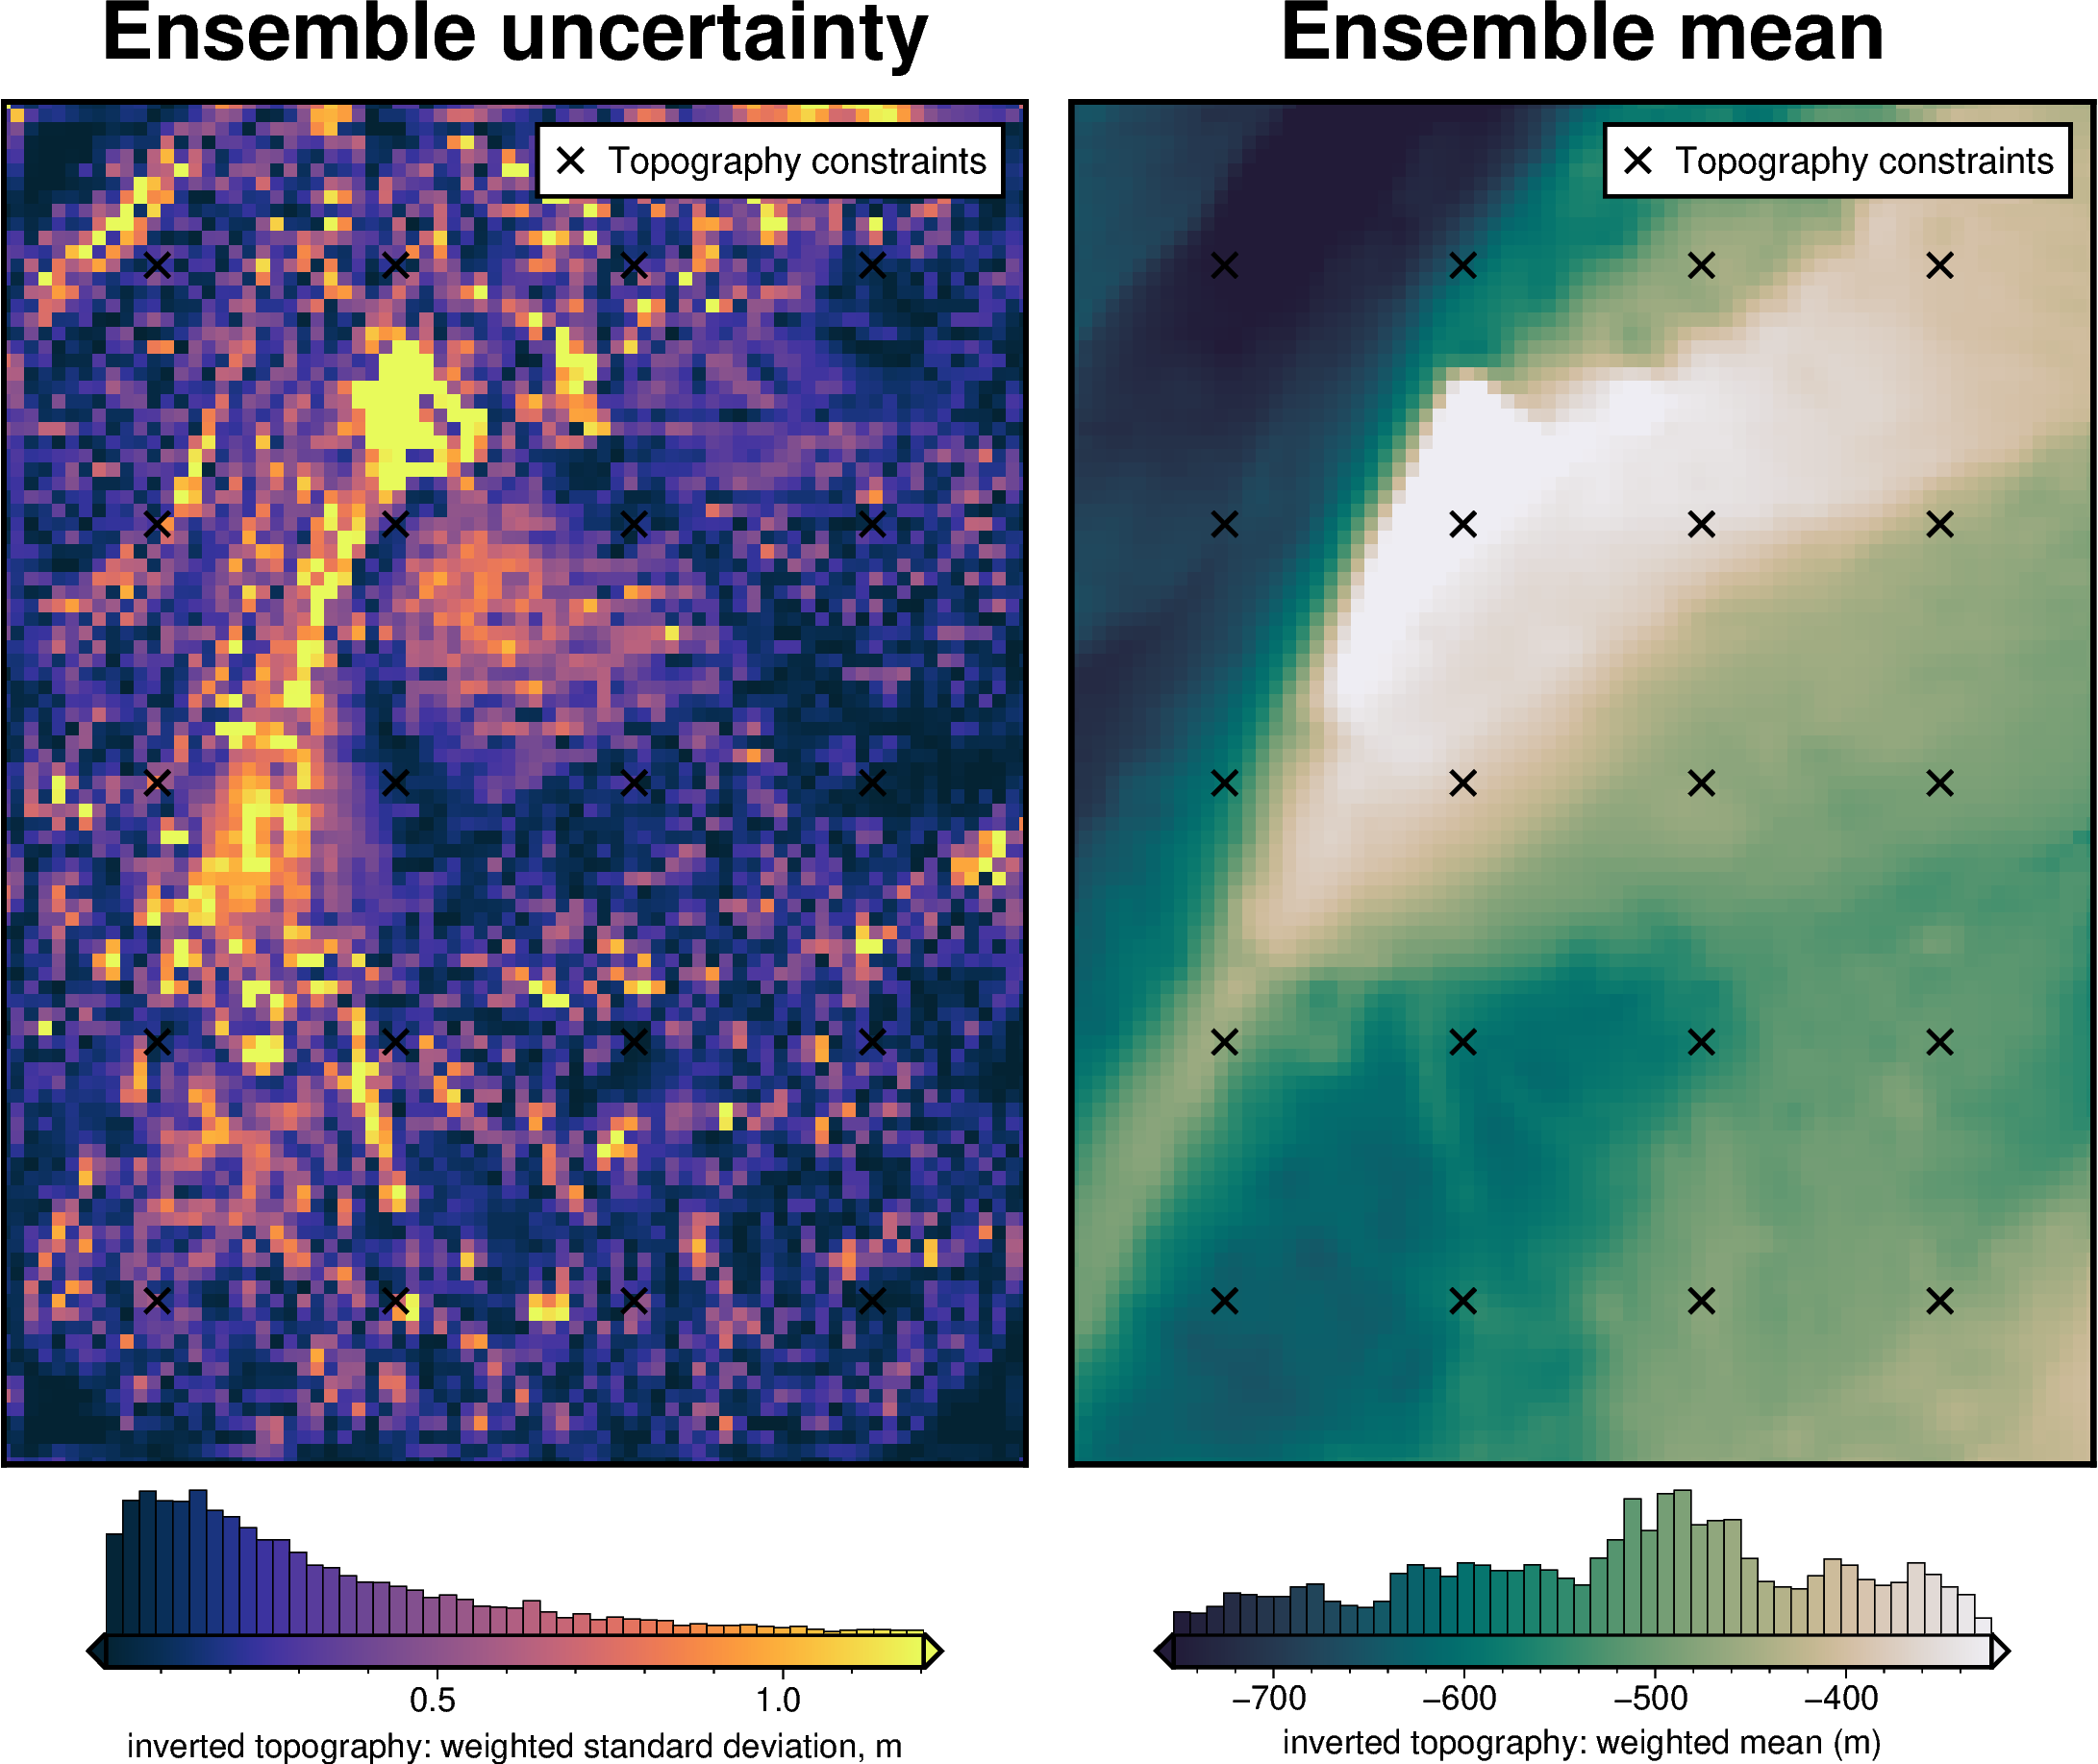

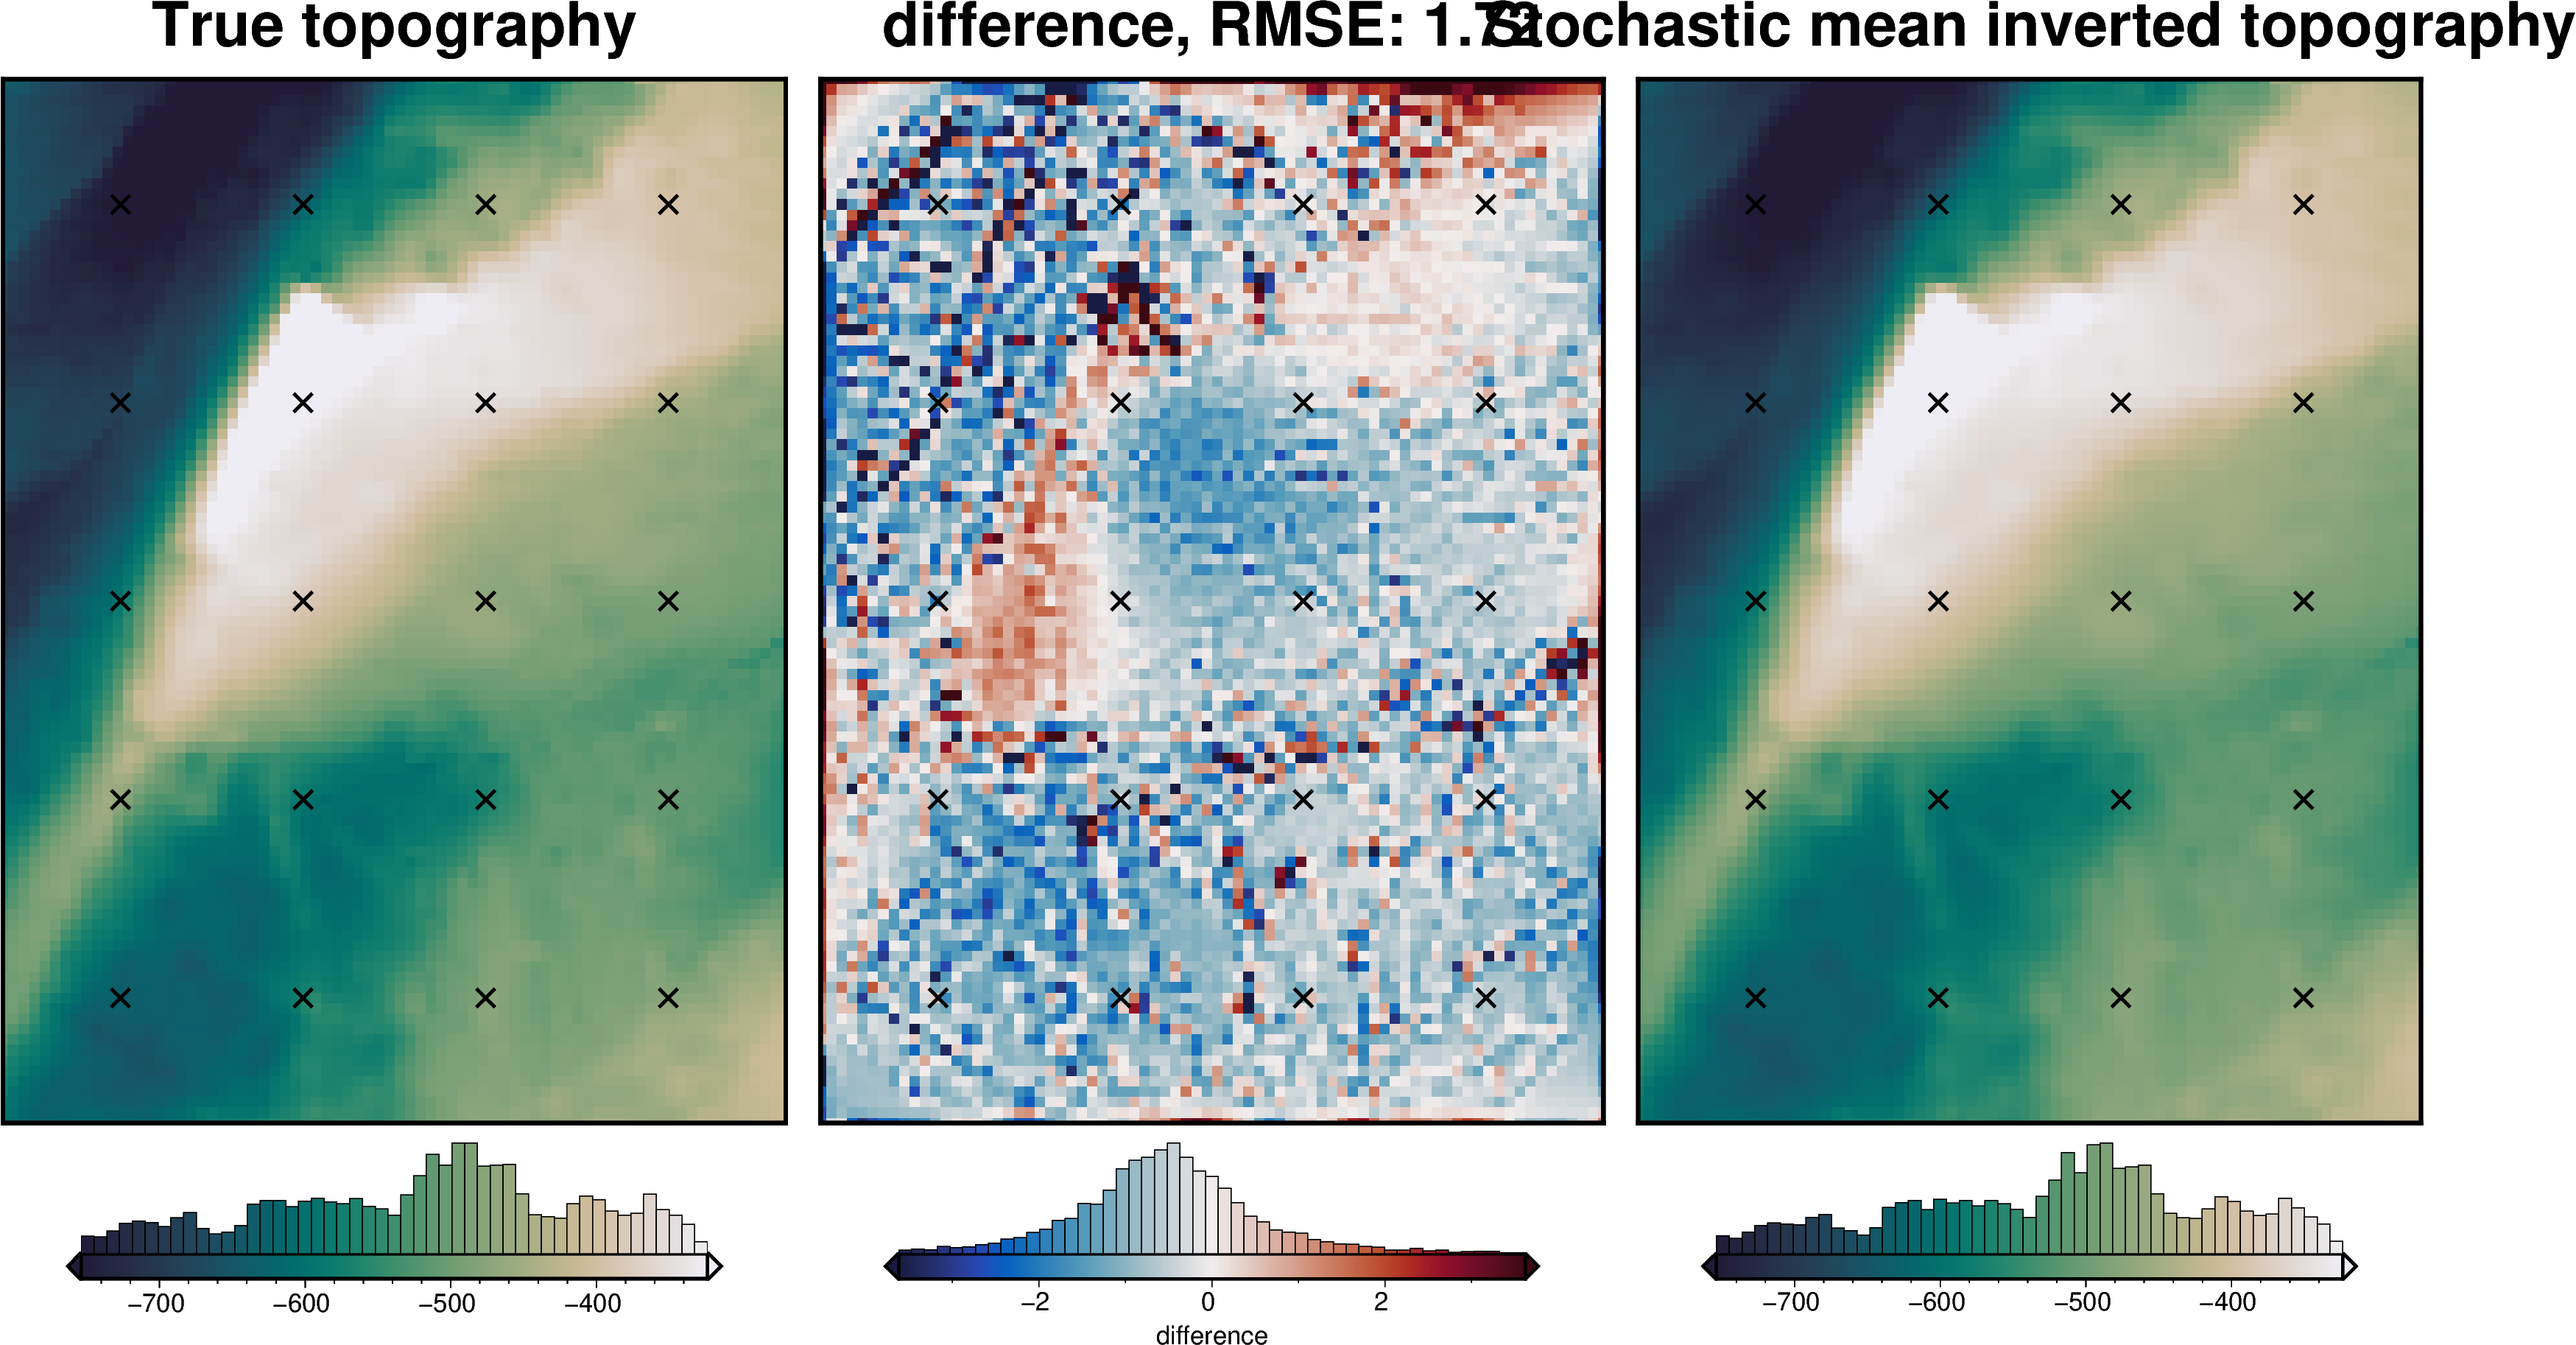

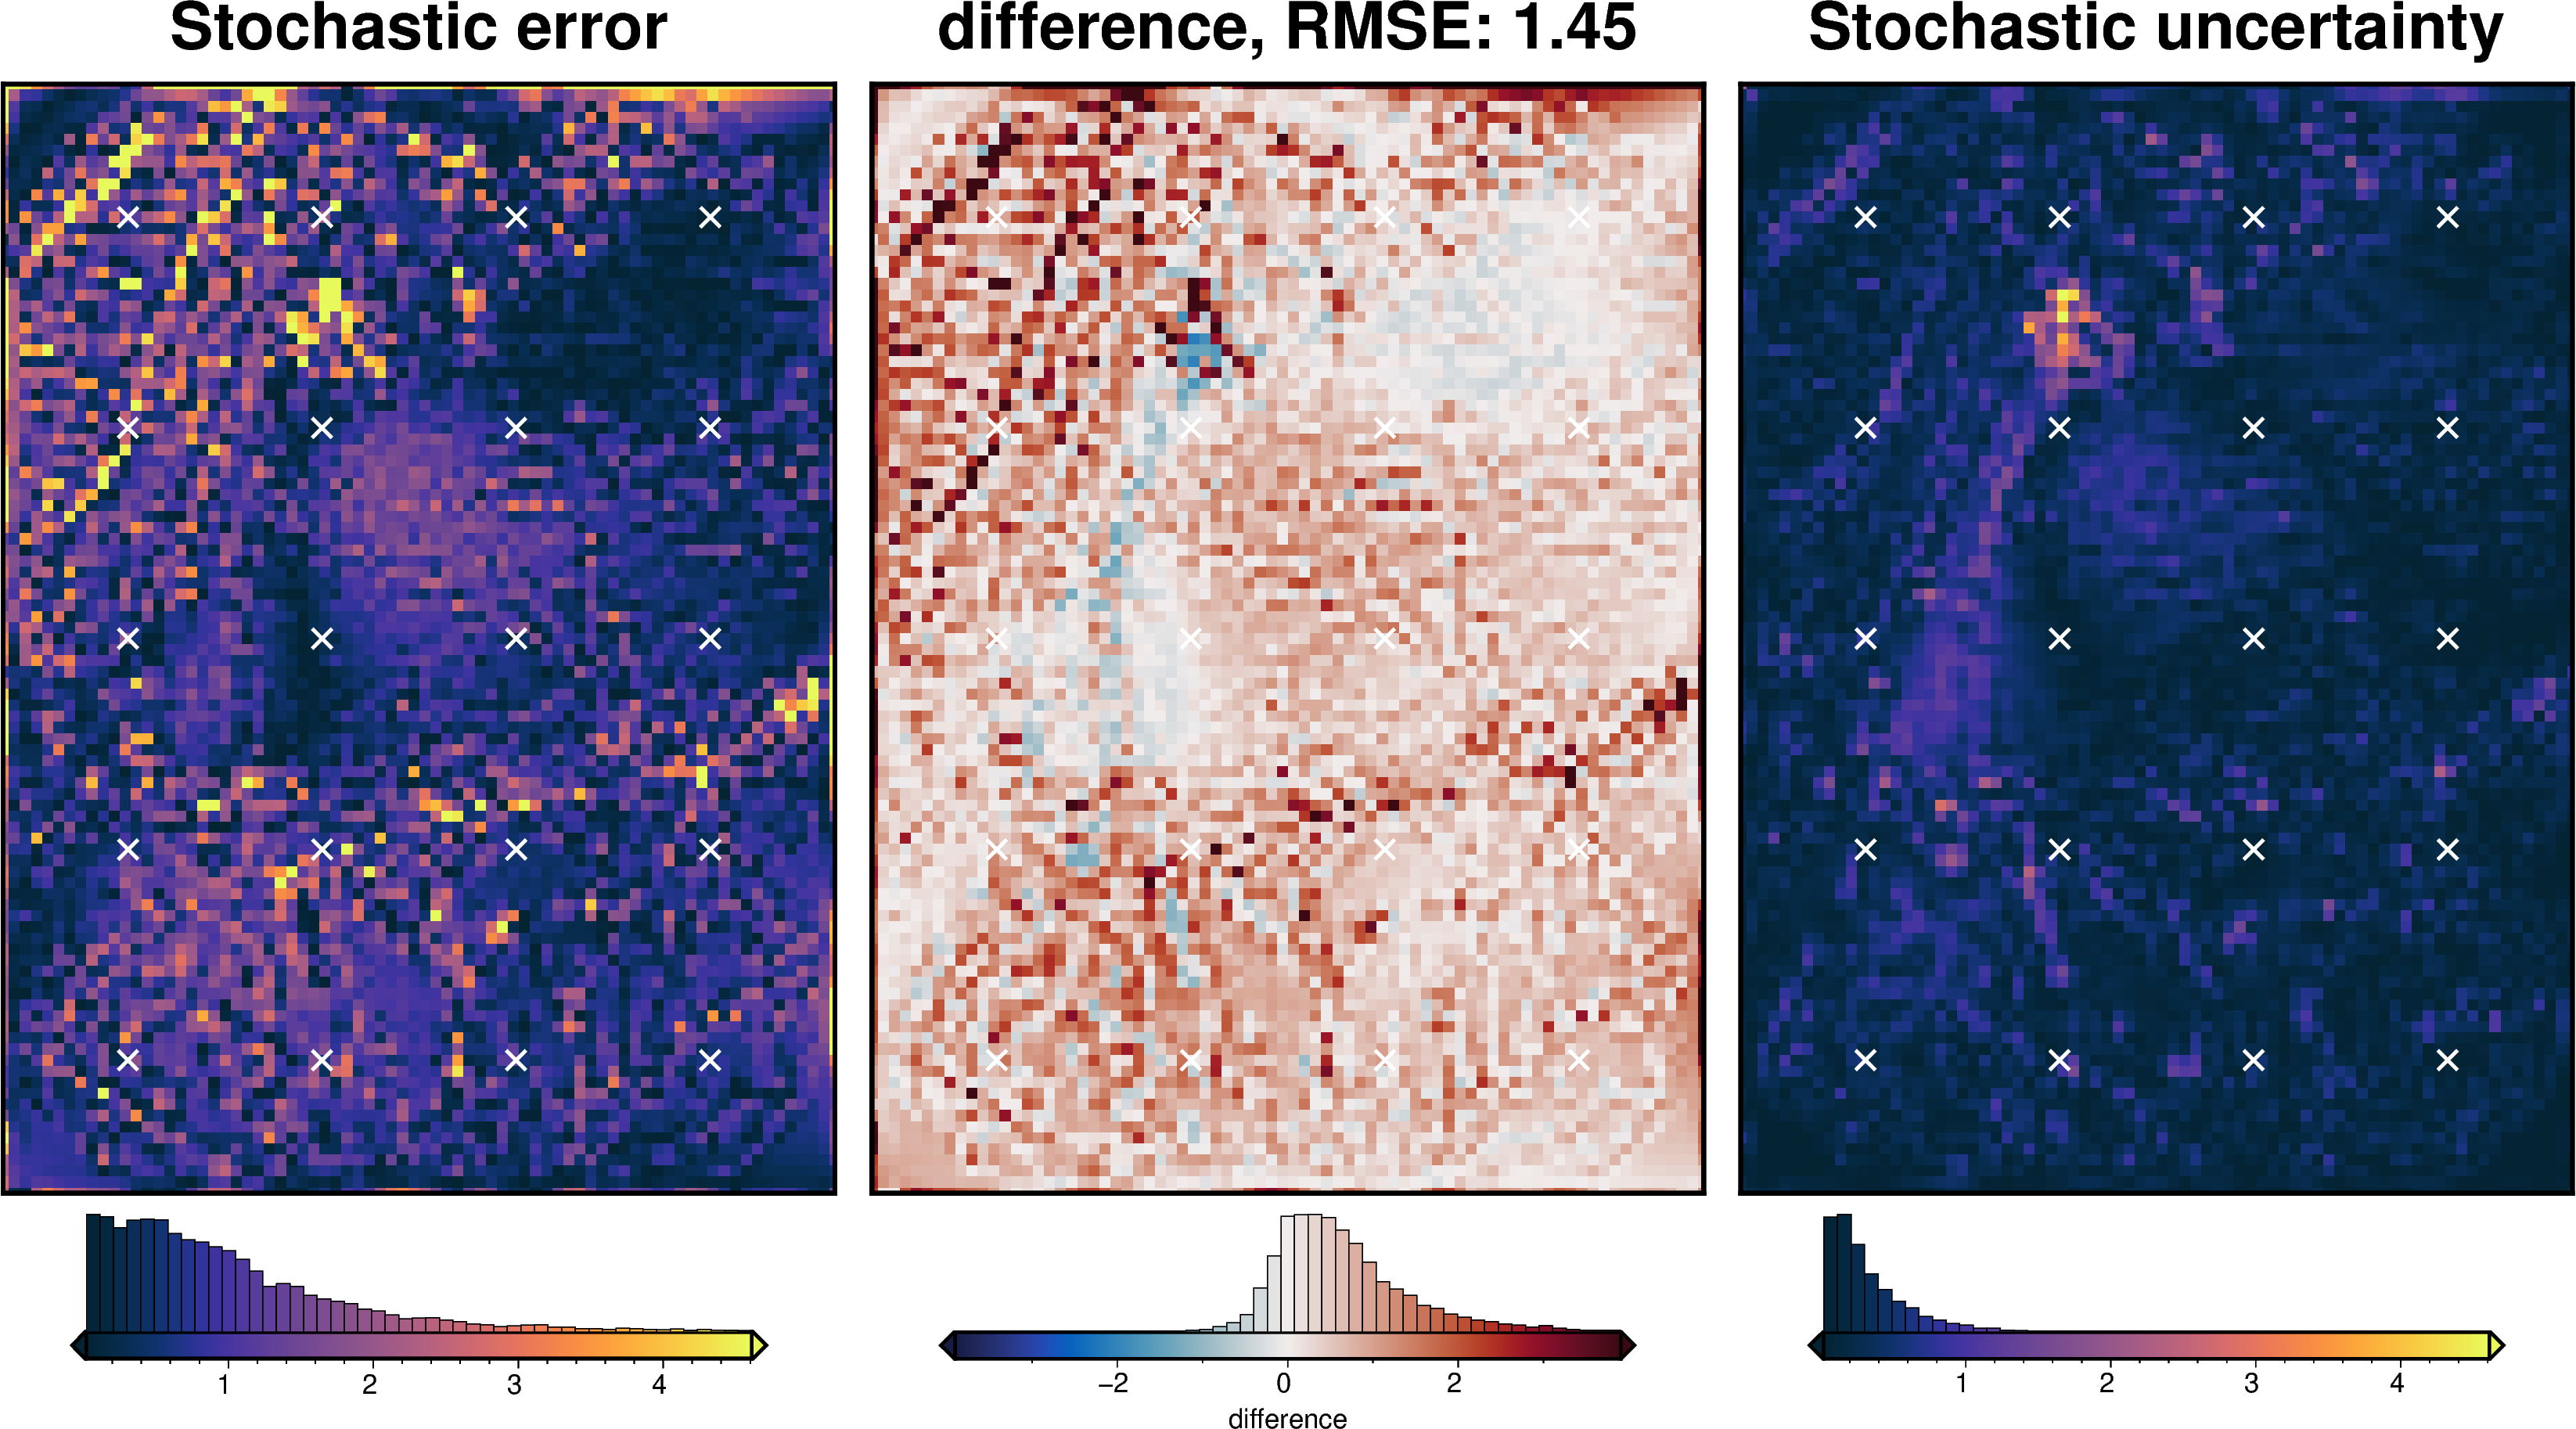

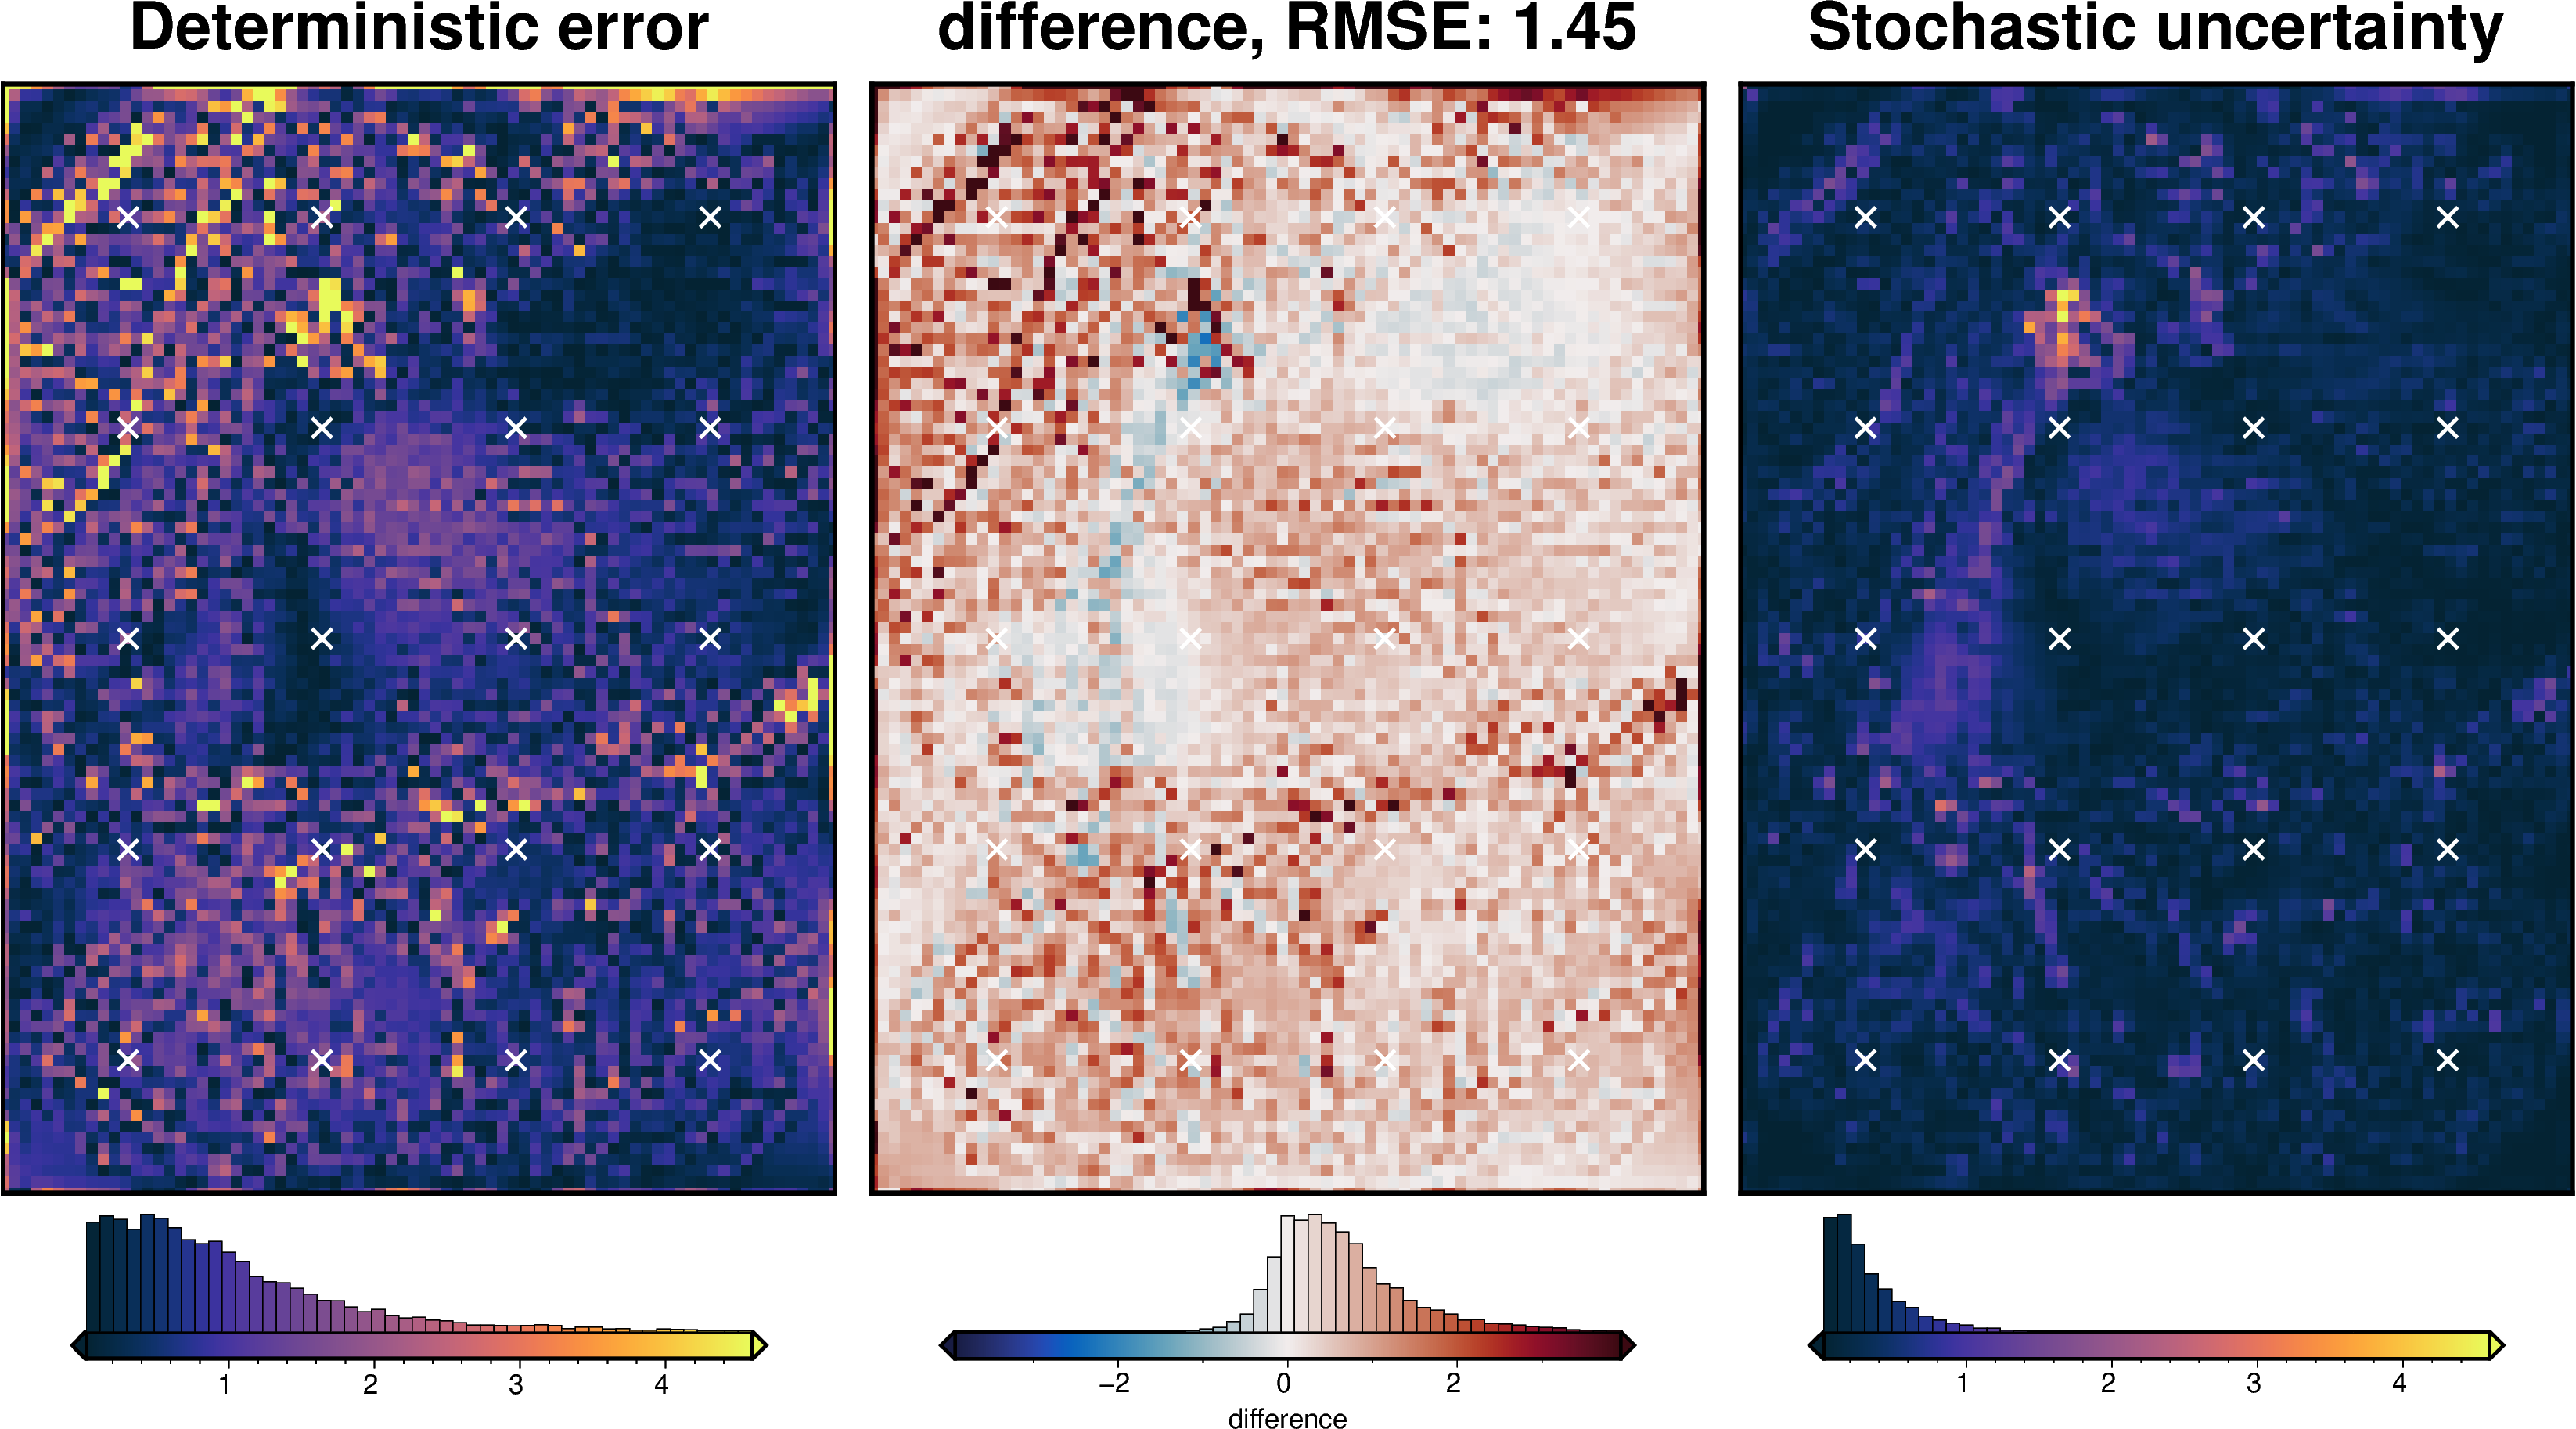

In [37]:
solver_dict = {
    "solver_damping": {
        "distribution": "normal",
        "loc": np.log10(best_damping),  # mean of base 10 exponent
        "scale": stdev,  # standard deviation of base 10 exponent
        "log": True,
    },
}
fname = "../../results/Ross_Sea_02_uncertainty_damping"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_damping_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=solver_dict,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_damping_results,
    # vd.pad_region(inversion_region, -3*spacing),
    inversion_region,
    spacing,
    bathymetry,
    deterministic_bathymetry=final_topography,
    constraint_points=constraint_points[constraint_points.inside],
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

## Density component

In [38]:
# load study
with pathlib.Path(
    "../../results/Ross_Sea_02_density_cv_zref_density_cv_study.pickle"
).open("rb") as f:
    study = pickle.load(f)

study_df = study.trials_dataframe()
study_df = study_df.sort_values("value")

# calculate zscores of values
study_df["value_zscore"] = sp.stats.zscore(study_df["value"])

# drop outliers (values with zscore > |2|)
study_df2 = study_df[(np.abs(study_df.value_zscore) < 2)]

stdev = study_df2.params_density_contrast.std()
print(f"calculated stdev: {stdev}")

# manually pick a stdev
stdev = 5
print(f"using stdev: {stdev}")

print(
    f"density estimation error: {np.abs(true_density_contrast - best_density_contrast)}"
)

calculated stdev: 54.94568024674713
using stdev: 5
density estimation error: 2


best: 1478 
std: 5 
+1std: 1483 
-1std: 1473


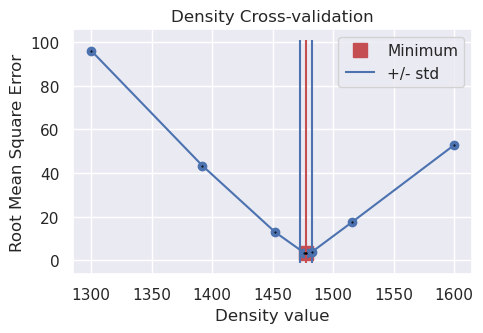

In [39]:
fig = plotting.plot_cv_scores(
    study.trials_dataframe().value.values,
    study.trials_dataframe().params_density_contrast.values,
    param_name="Density",
    logx=False,
    logy=False,
)
ax = fig.axes[0]

best = study_df2.params_density_contrast.iloc[0]
upper = best + stdev
lower = best - stdev

y_lims = ax.get_ylim()
ax.vlines(best, ymin=y_lims[0], ymax=y_lims[1], color="r")
ax.vlines(upper, ymin=y_lims[0], ymax=y_lims[1], label="+/- std")
ax.vlines(lower, ymin=y_lims[0], ymax=y_lims[1])

x_lims = ax.get_xlim()
ax.set_xlim(
    min(x_lims[0], lower),
    max(x_lims[1], upper),
)
ax.legend()
print("best:", best, "\nstd:", stdev, "\n+1std:", upper, "\n-1std:", lower)

INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 1478.0, min: 1469.7757318652427, max: 1486.2242681347573
INFO:invert4geom:No pickle files starting with '../../results/Ross_Sea_02_uncertainty_density' found, creating new files



stochastic ensemble:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 10
saving results to pickle files with prefix: '../../results/Ross_Sea_02_uncertainty_density'



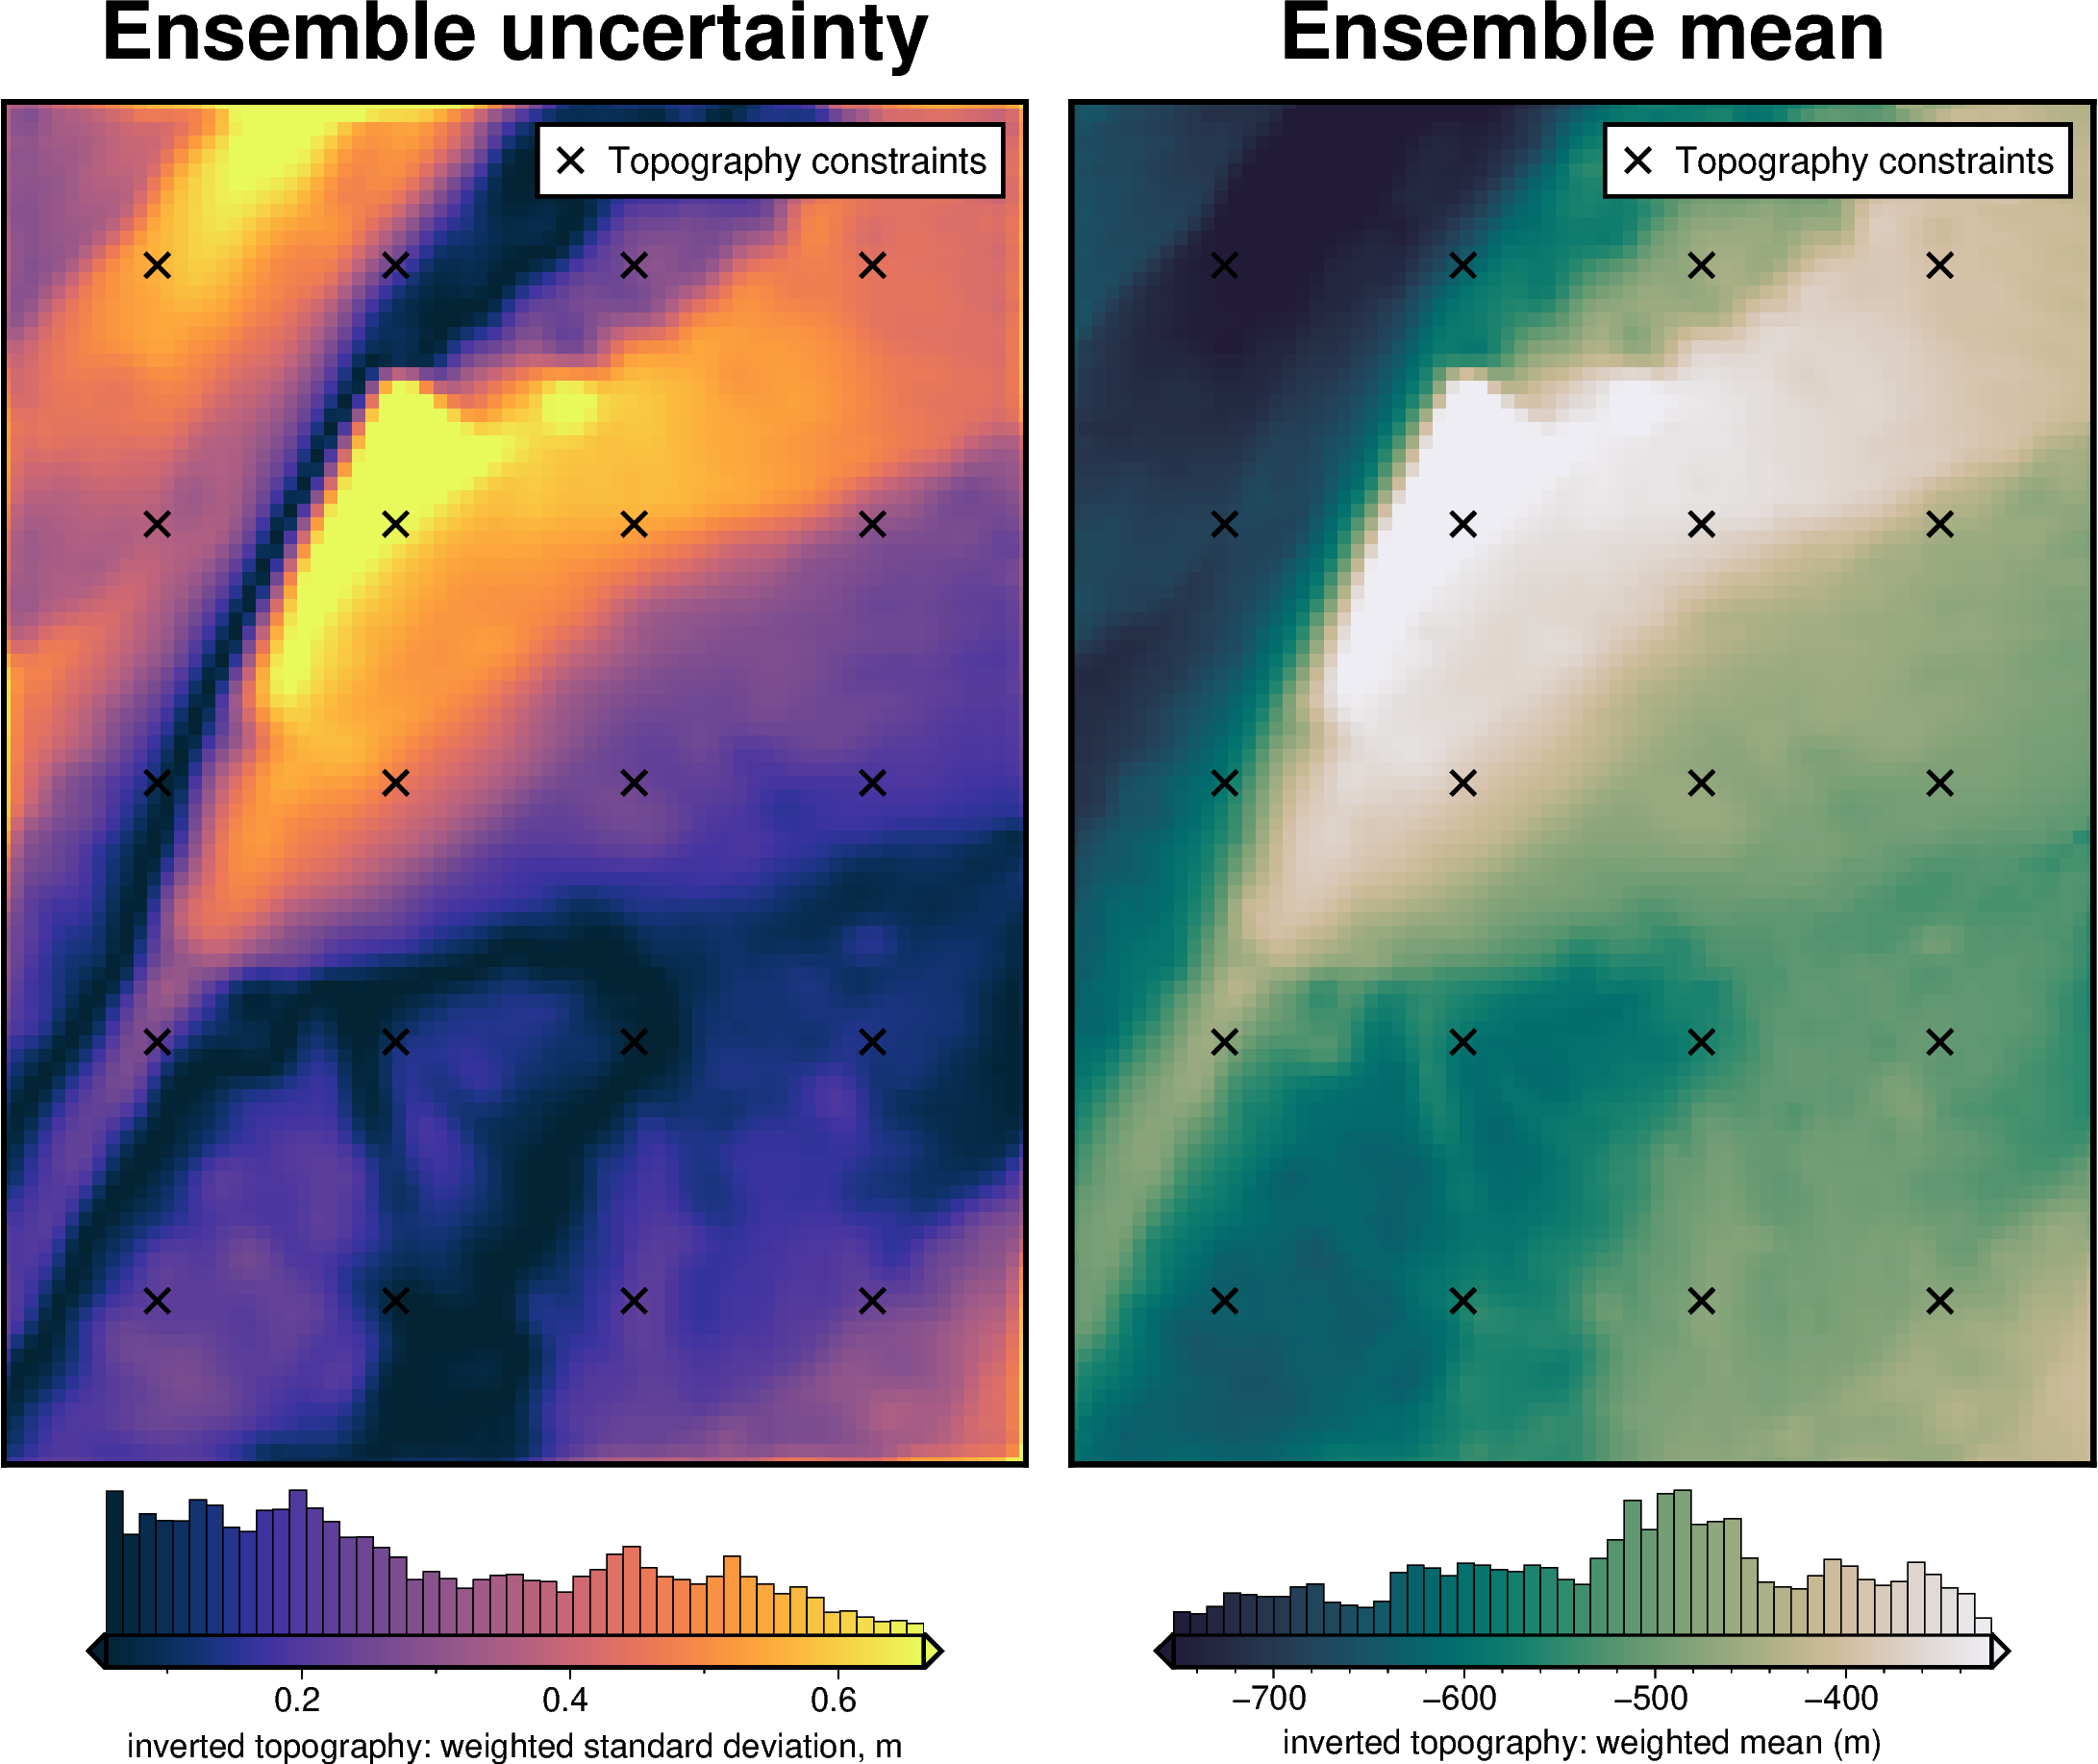

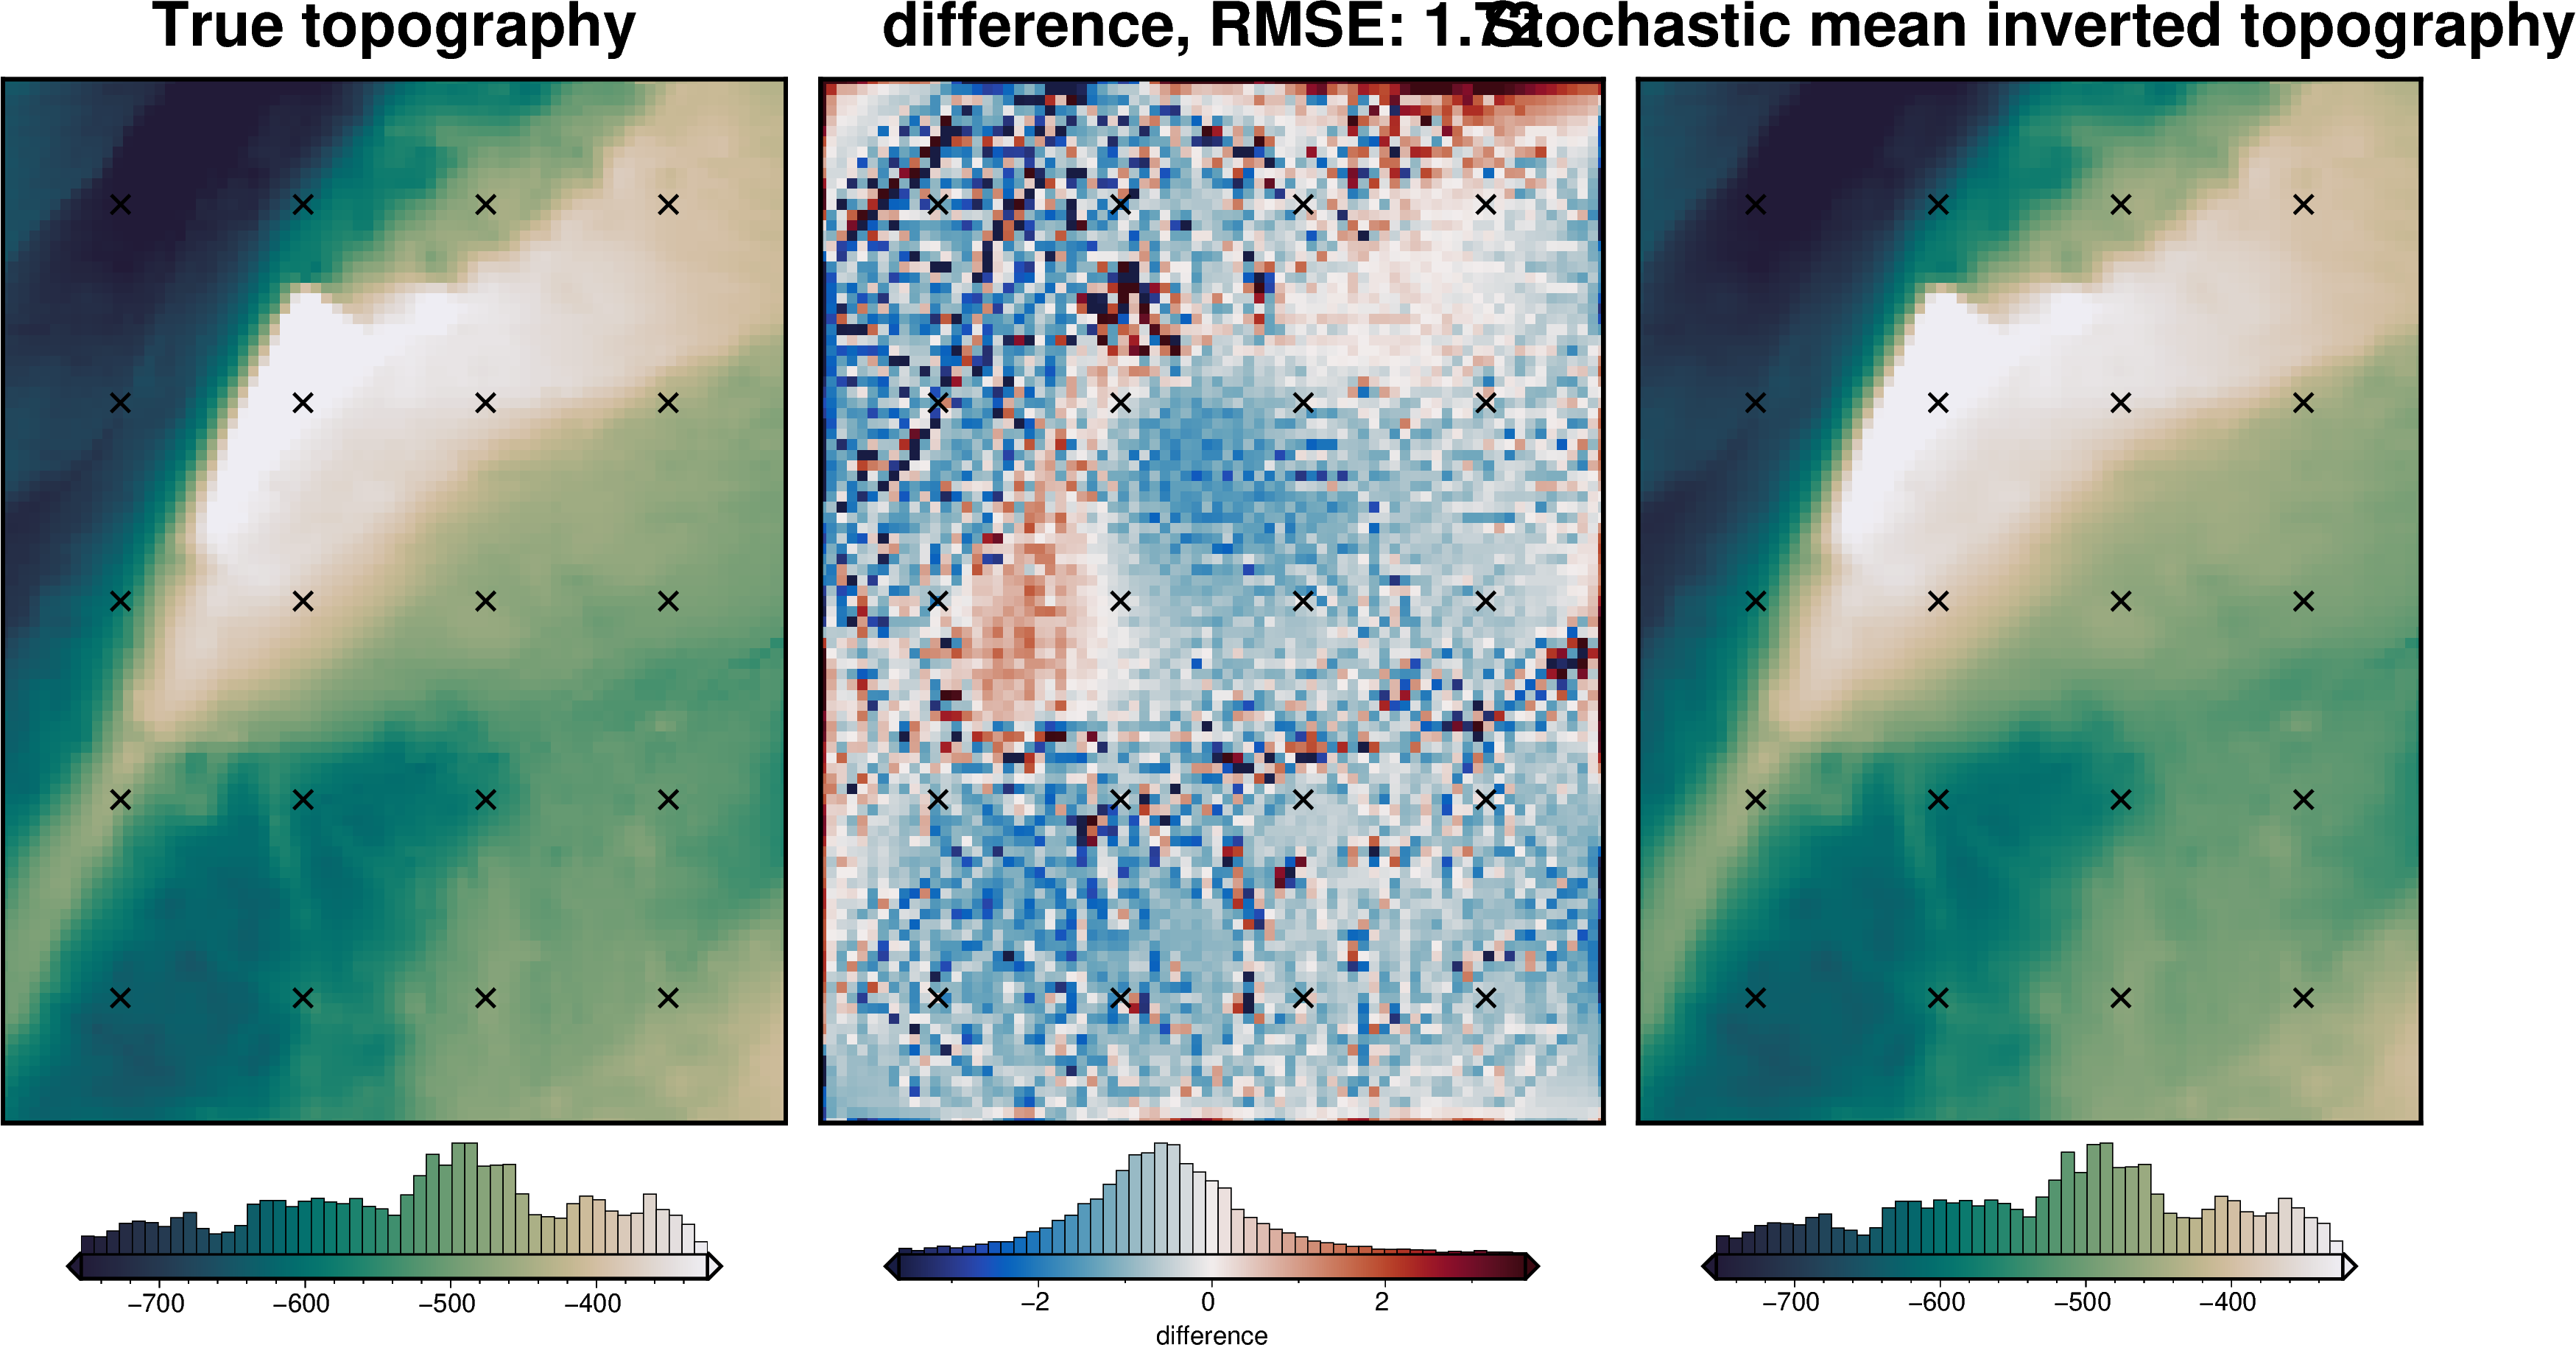

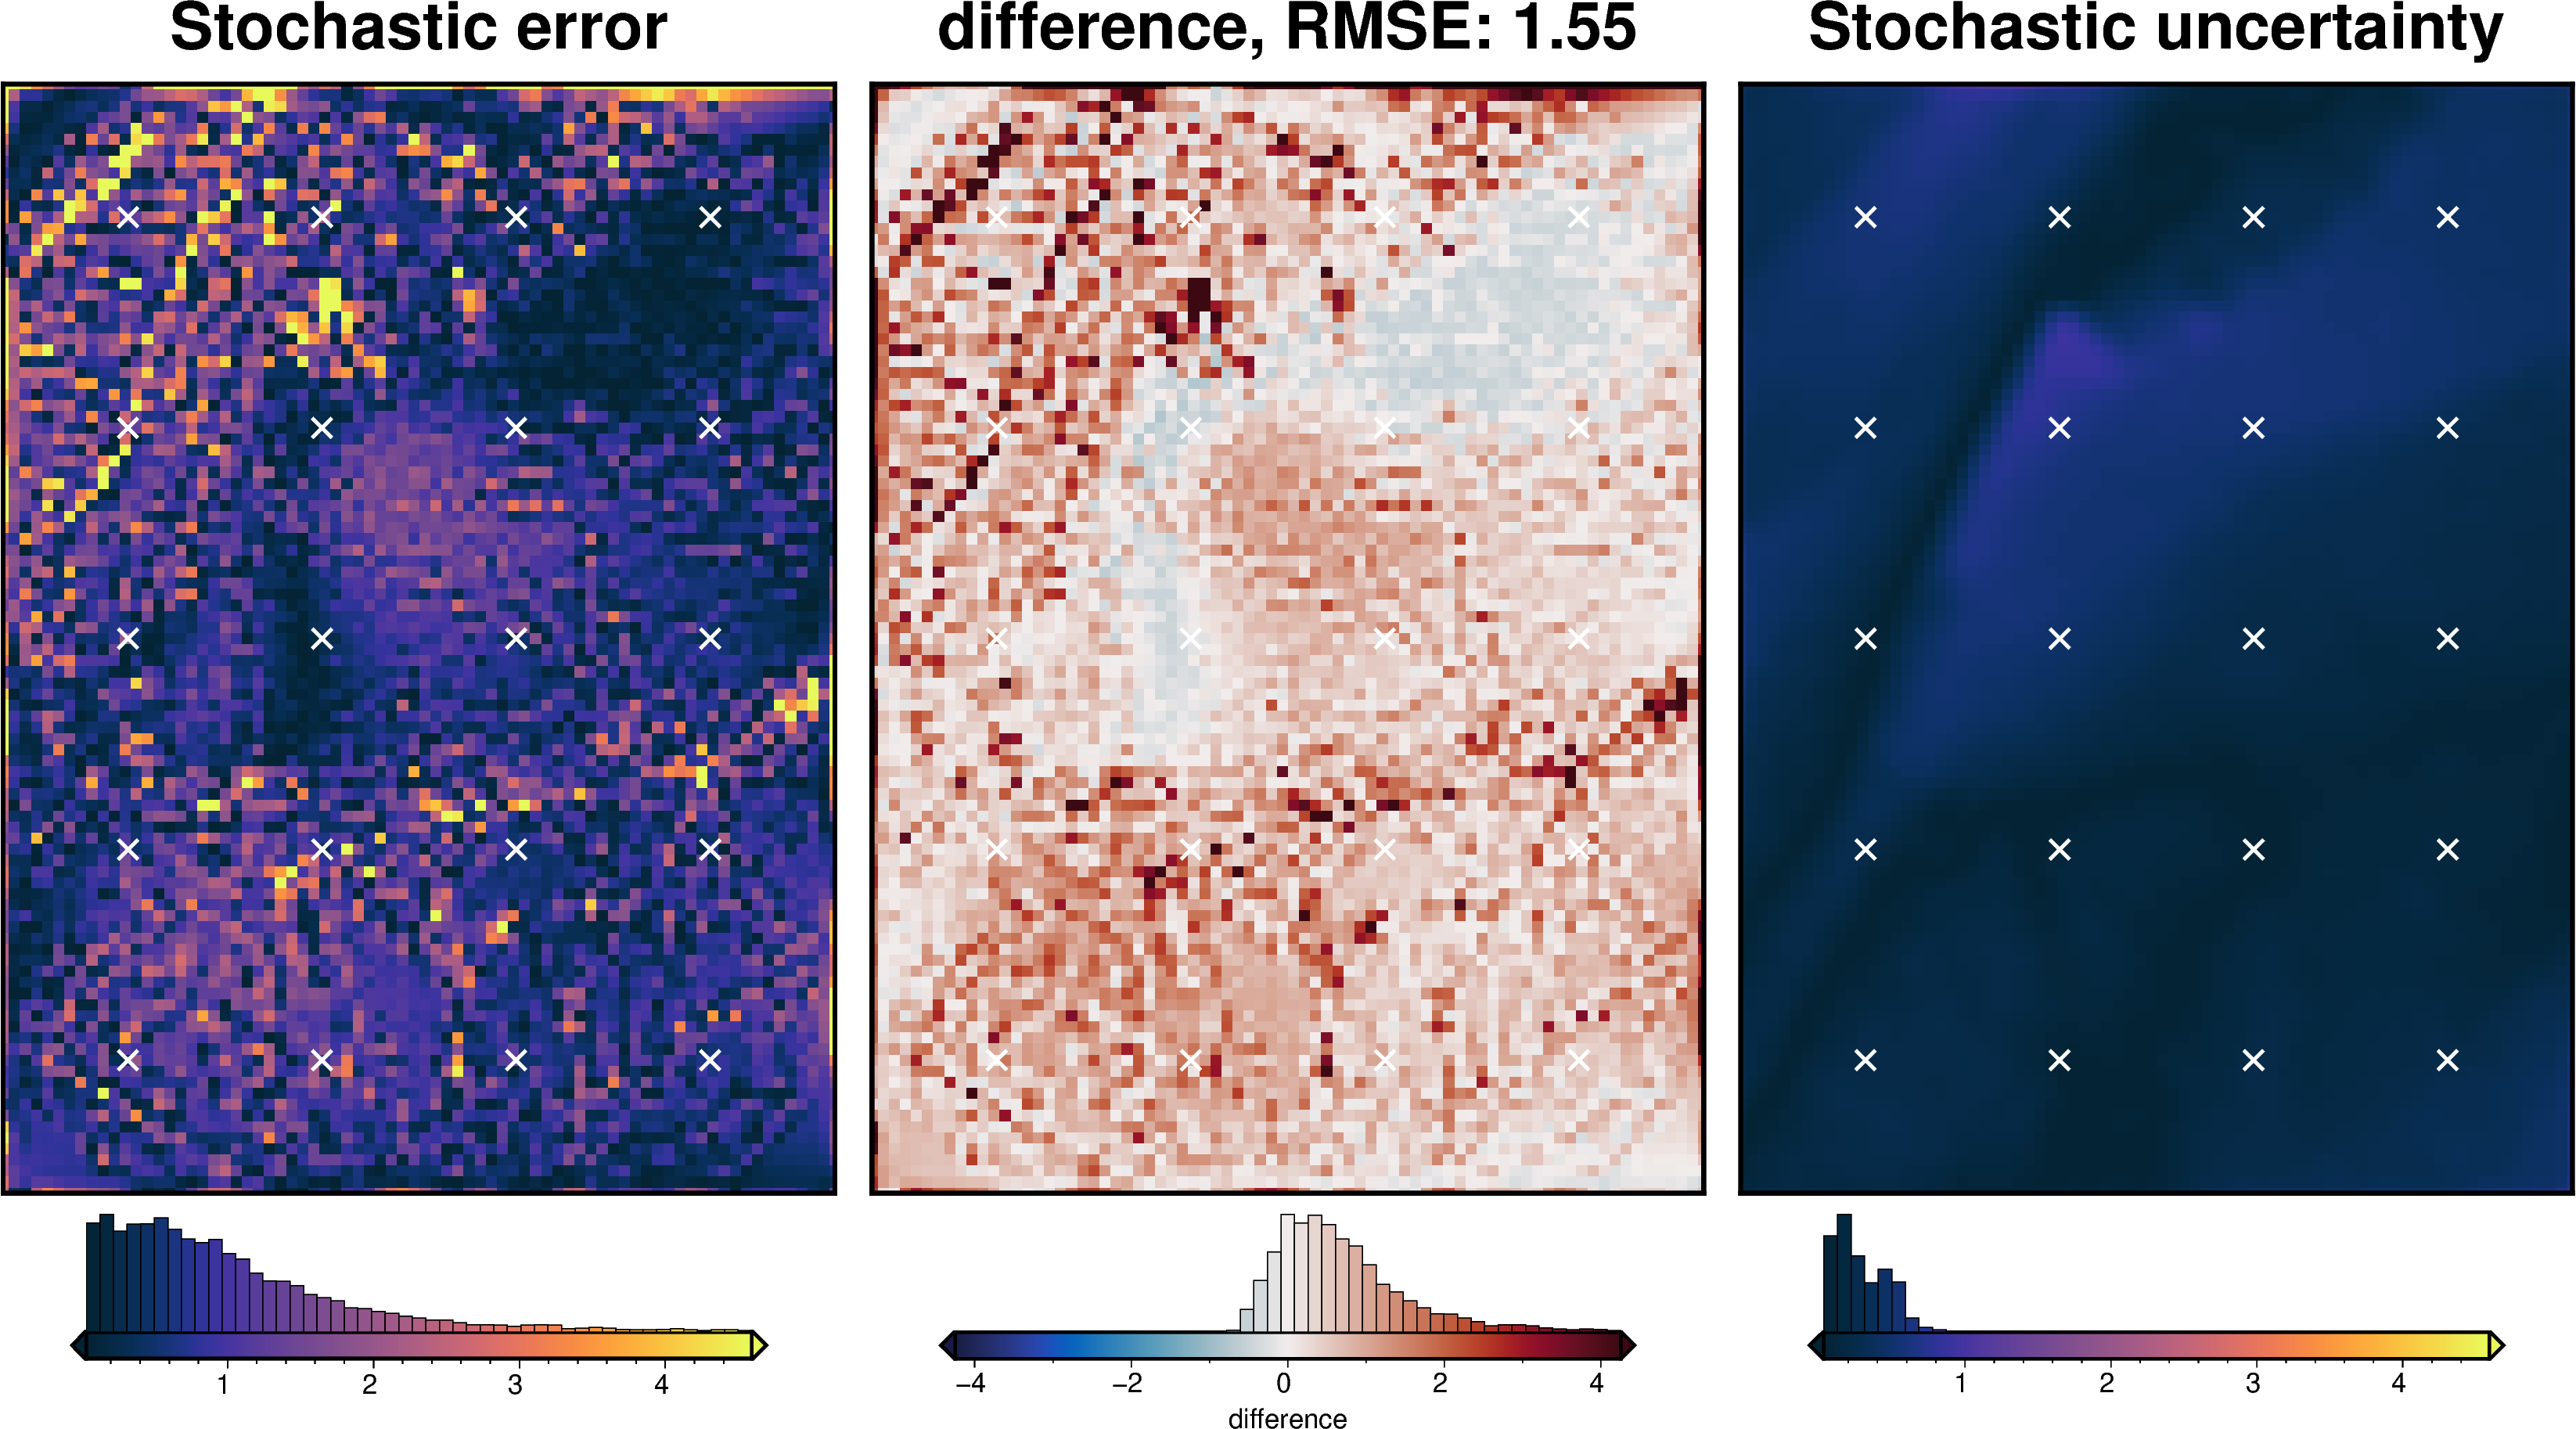

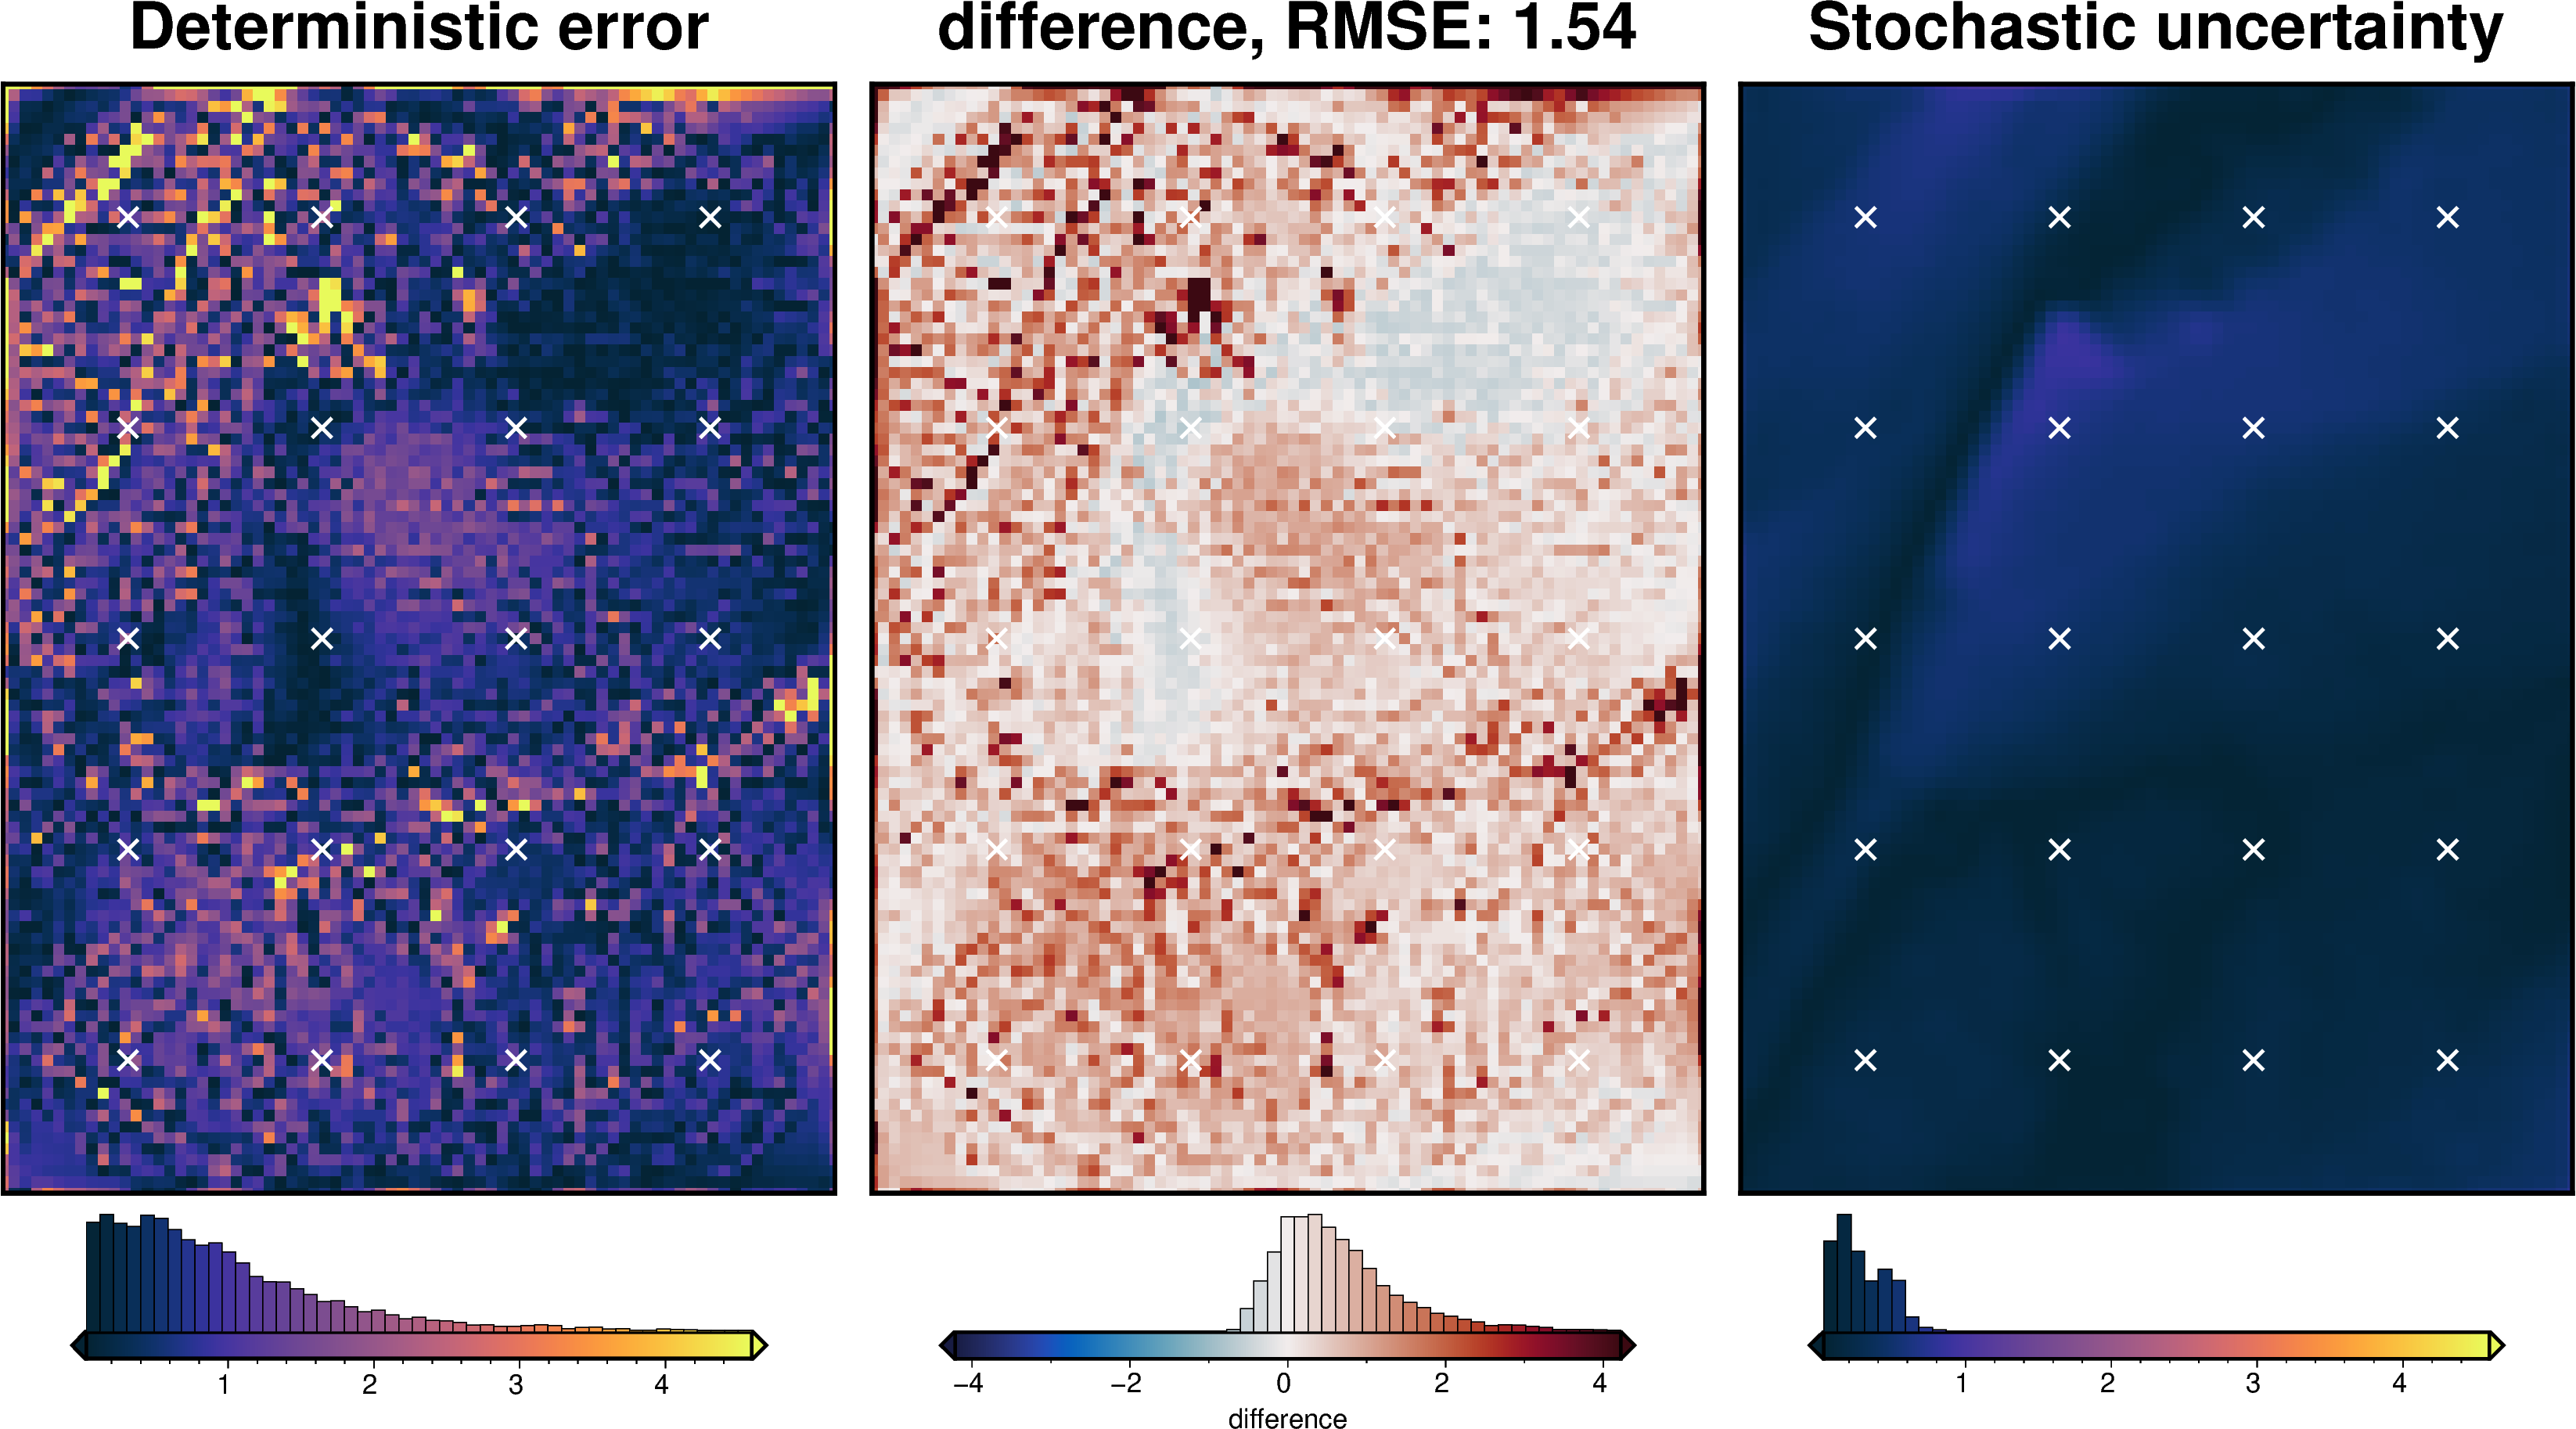

In [40]:
density_dict = {
    "density_contrast": {
        "distribution": "normal",
        "loc": best_density_contrast,
        "scale": stdev,
    },
}
fname = "../../results/Ross_Sea_02_uncertainty_density"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_density_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=10,
    parameter_dict=density_dict,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_density_results,
    # vd.pad_region(inversion_region, -3*spacing),
    inversion_region,
    spacing,
    bathymetry,
    deterministic_bathymetry=final_topography,
    constraint_points=constraint_points[constraint_points.inside],
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

## Total uncertainty

INFO:invert4geom:Sampled 'solver_damping' parameter values; mean: 0.013836588037939654, min: 0.007791710259737046, max: 0.022892940277730634
INFO:invert4geom:Sampled 'density_contrast' parameter values; mean: 1477.9999999999998, min: 1468.2001800772998, max: 1487.7998199227002
INFO:invert4geom:No pickle files starting with '../../results/Ross_Sea_02_uncertainty_full' found, creating new files



stochastic ensemble:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:starting stochastic uncertainty analysis at run 0 of 20
saving results to pickle files with prefix: '../../results/Ross_Sea_02_uncertainty_full'



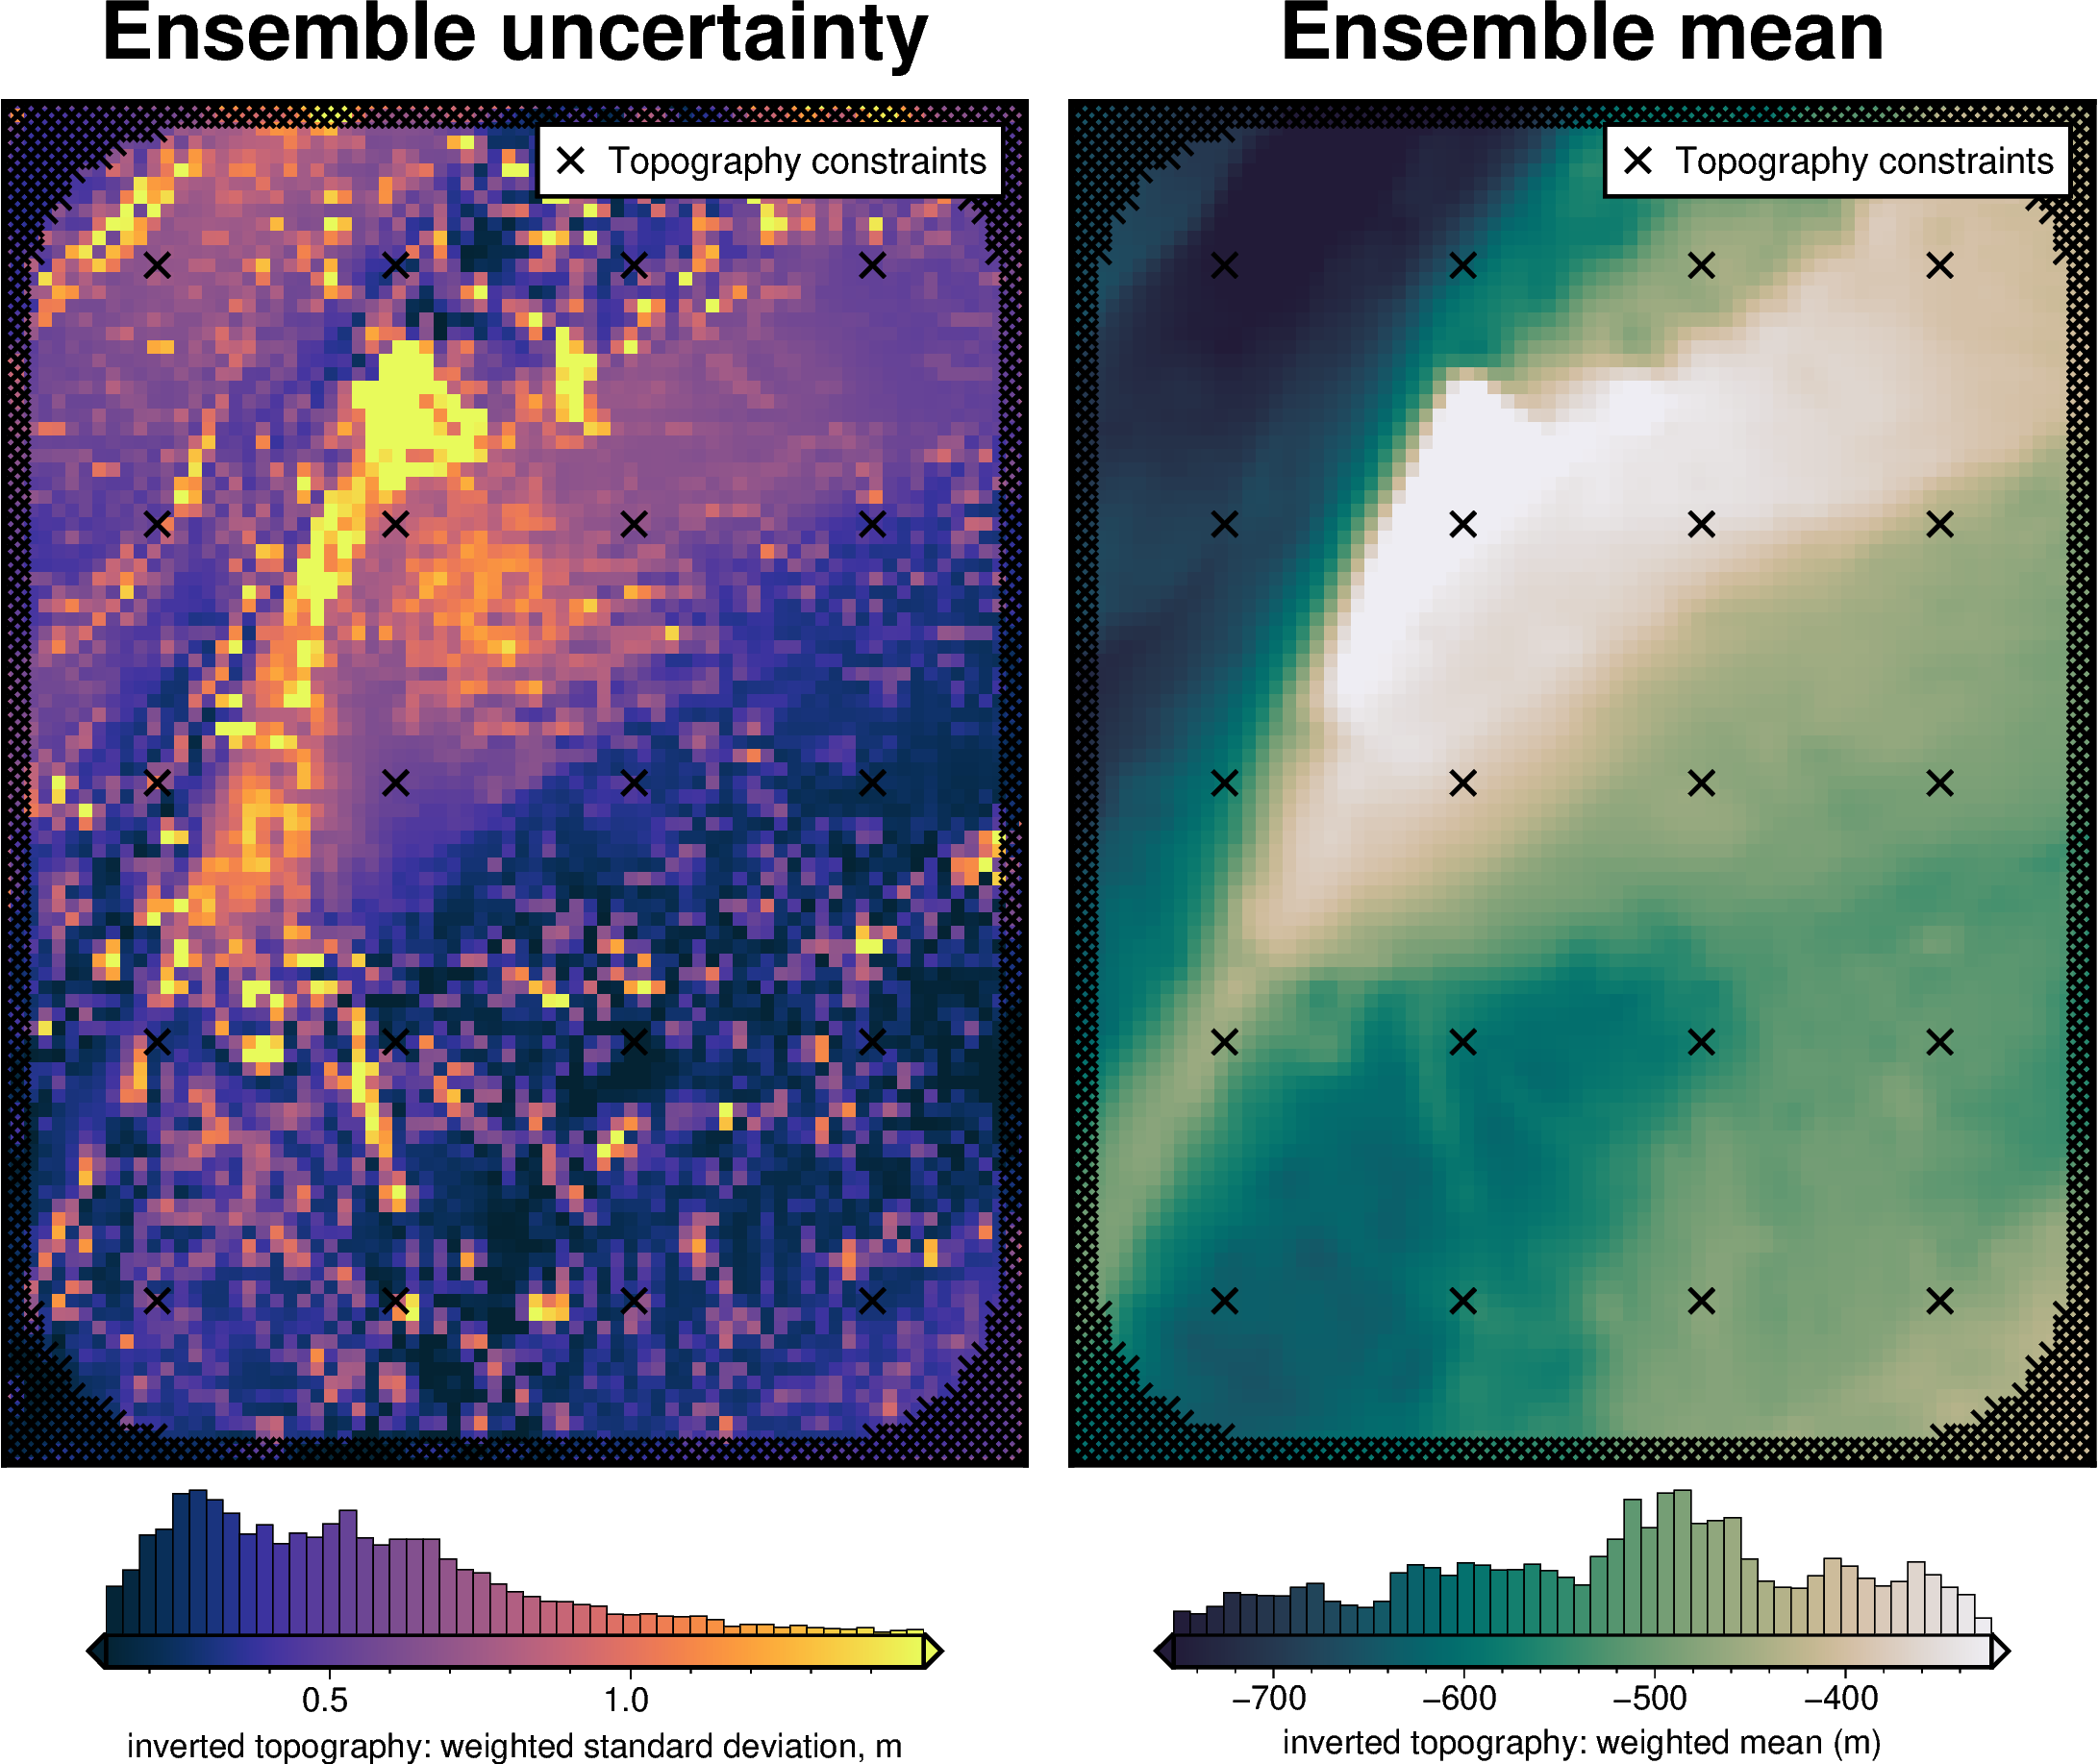

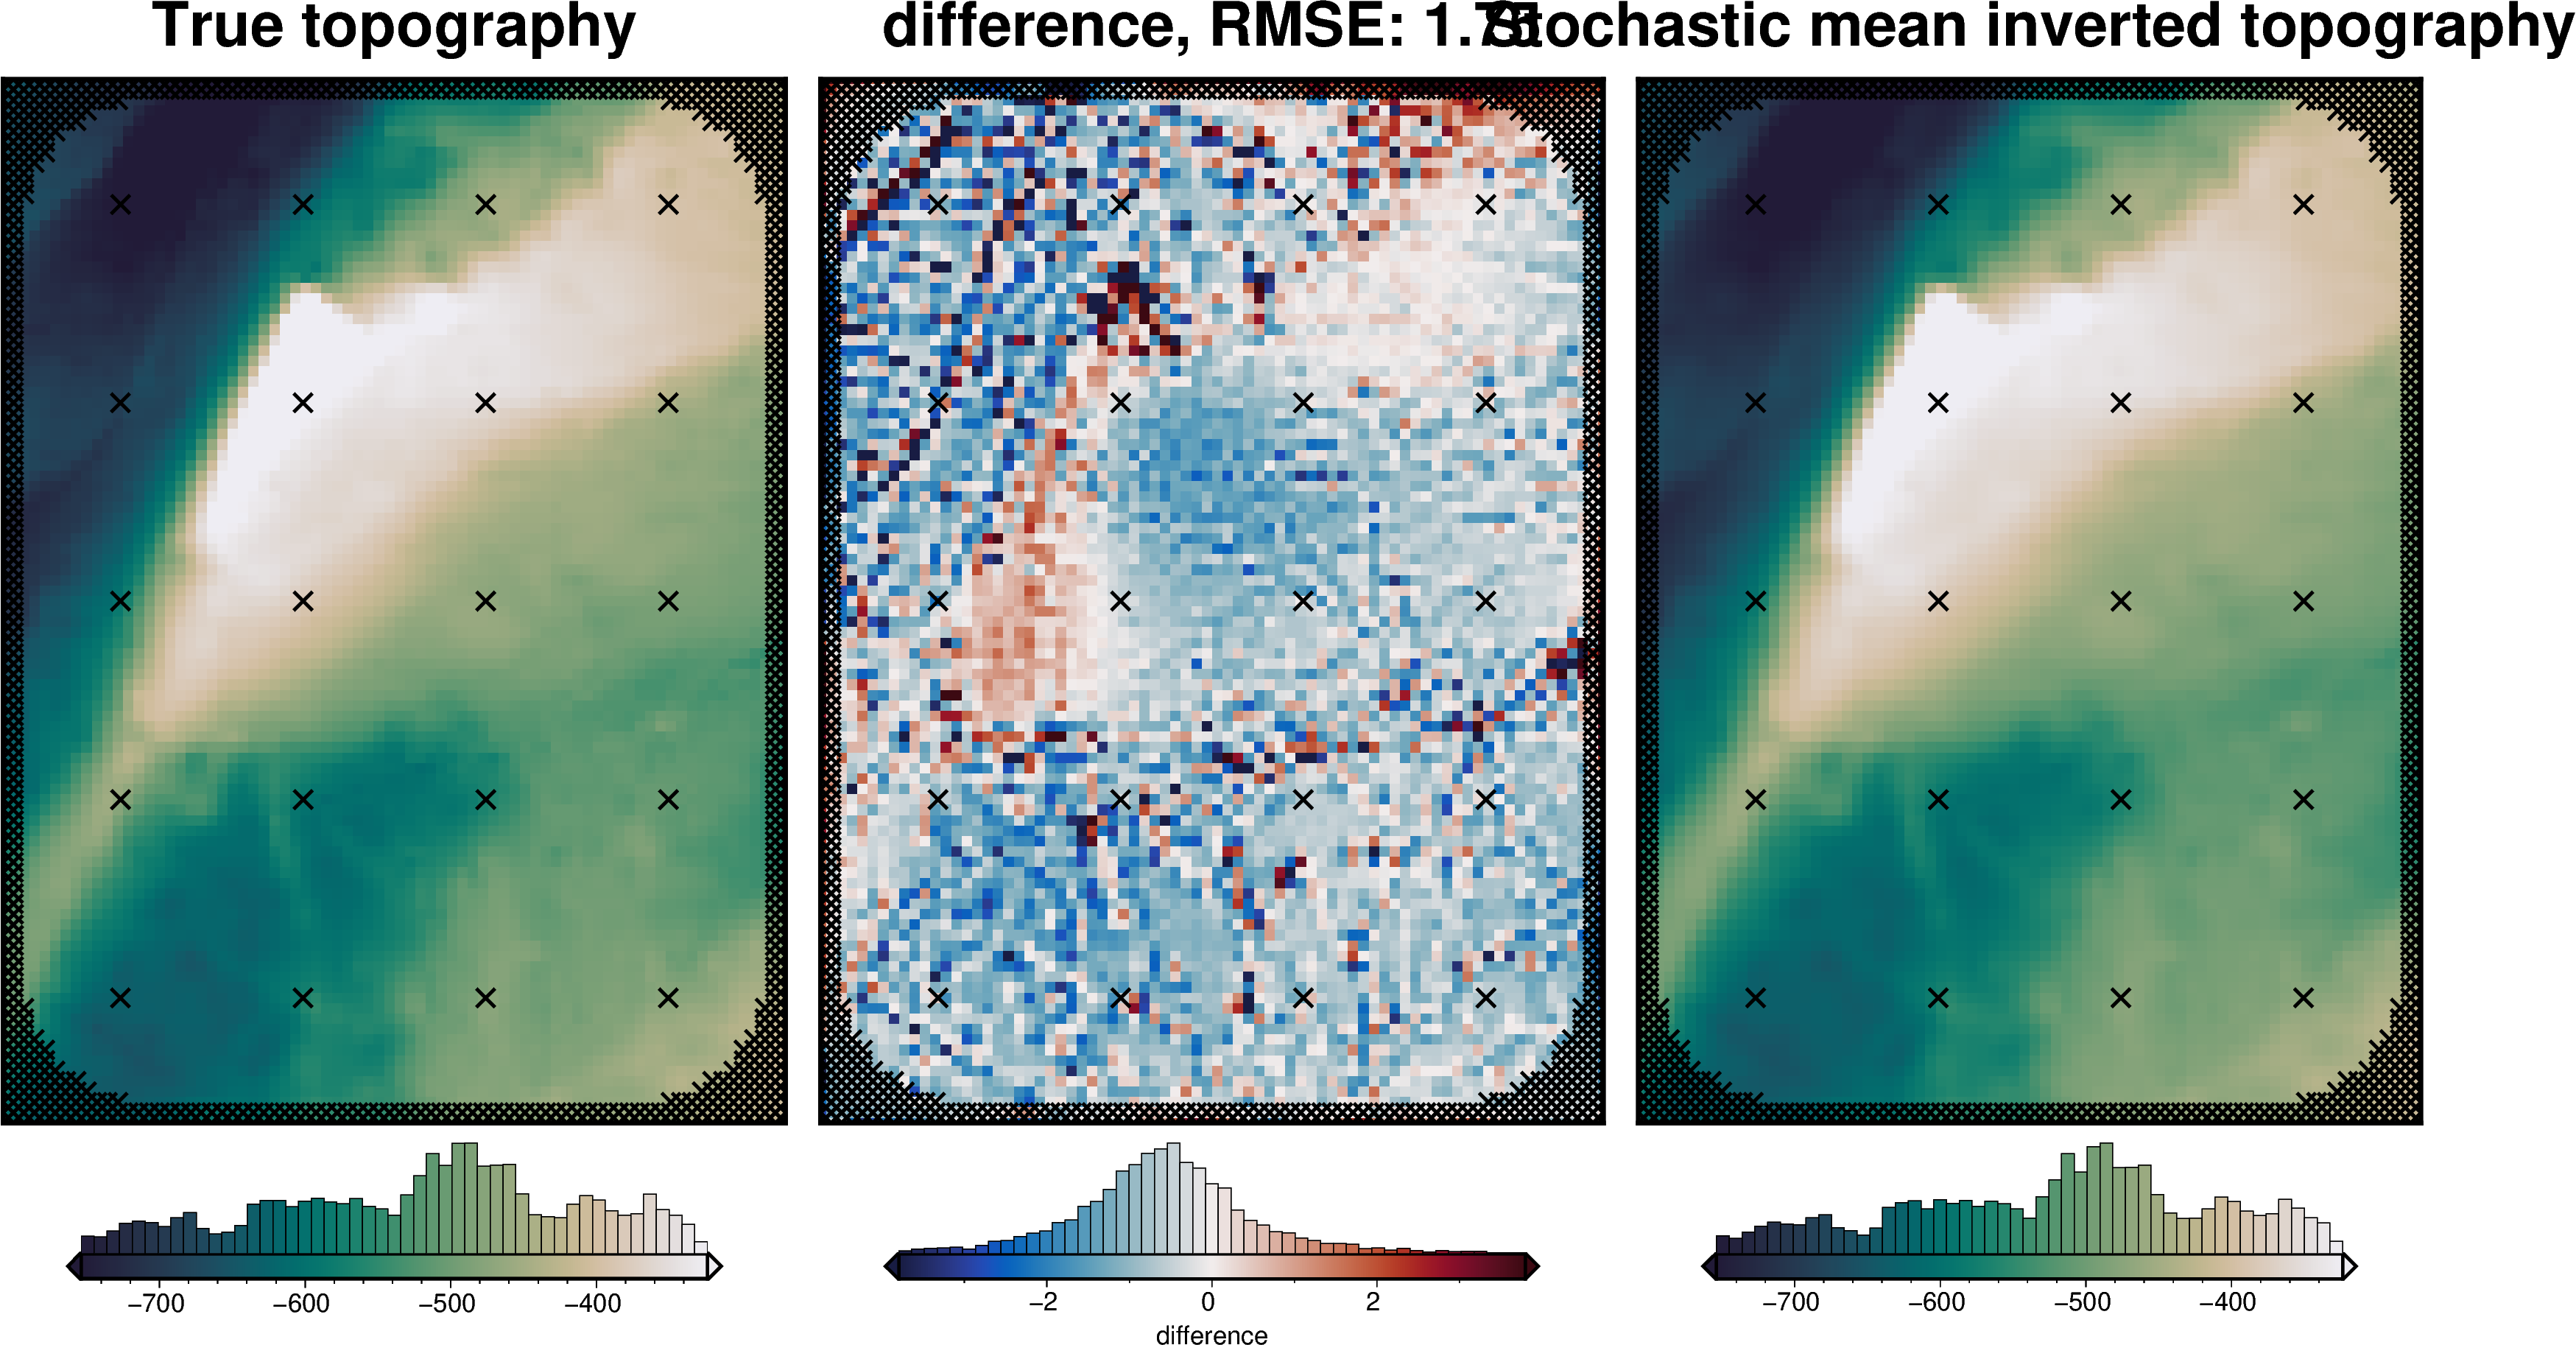

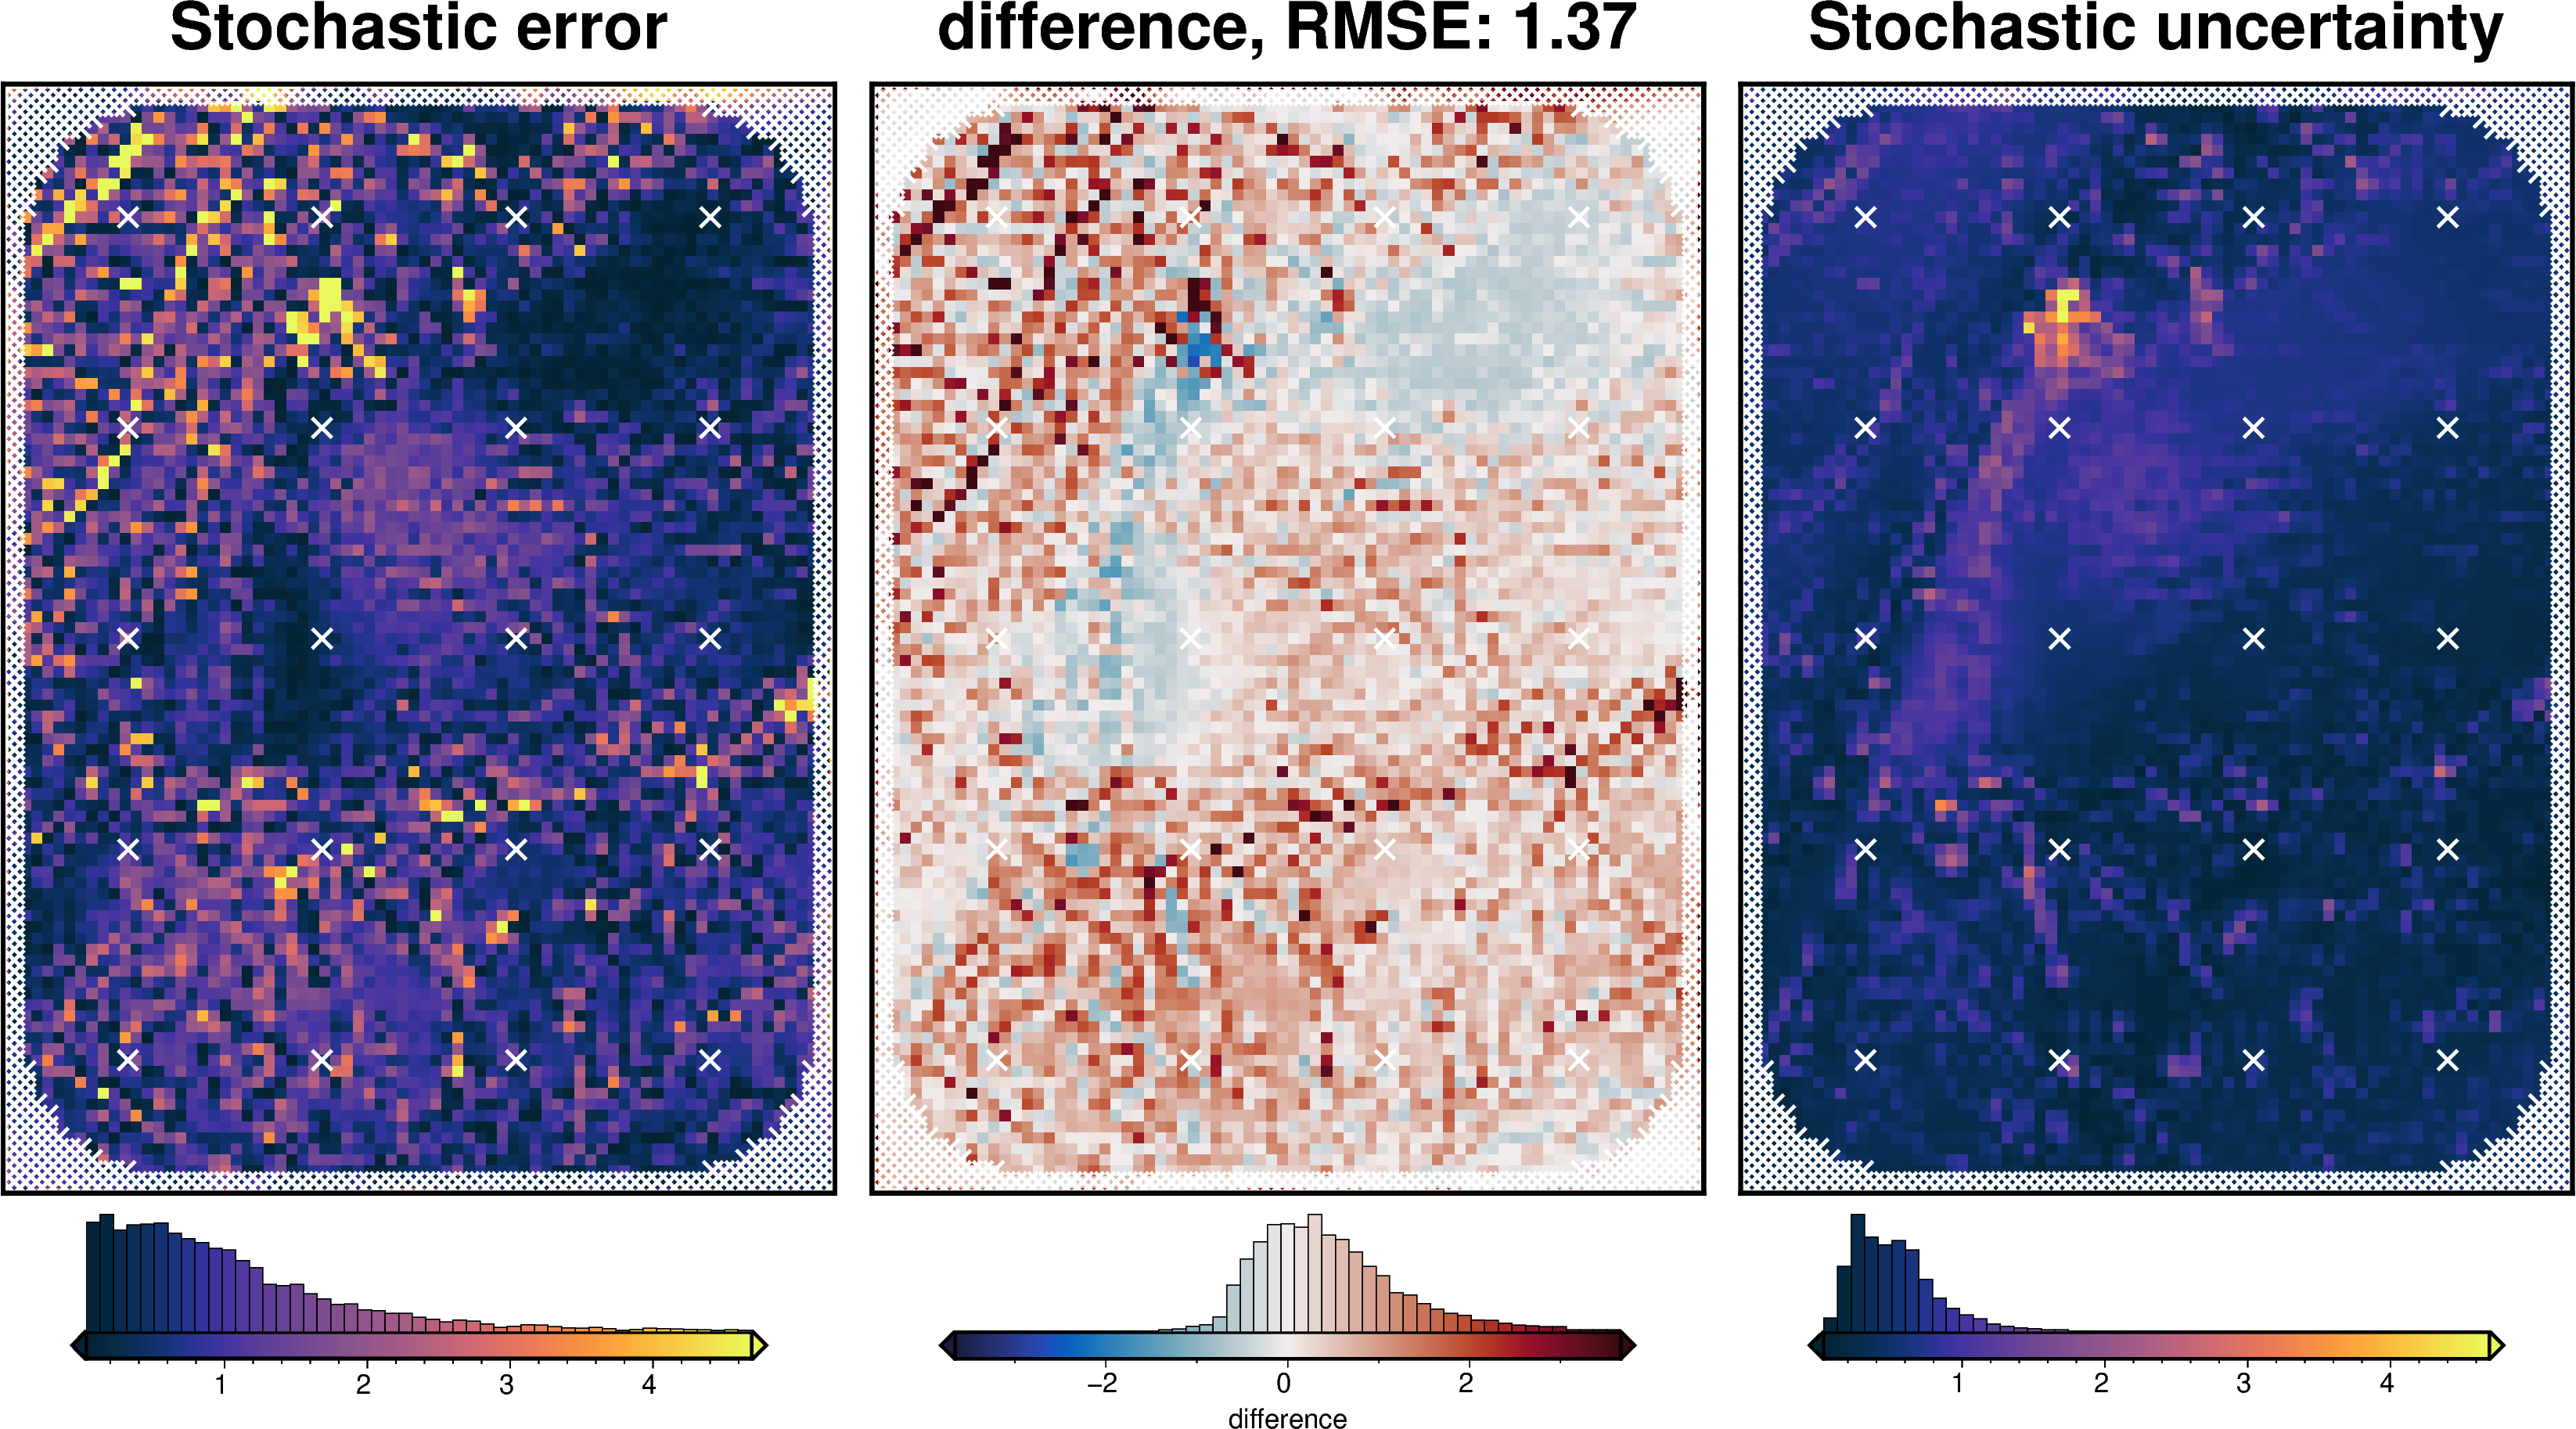

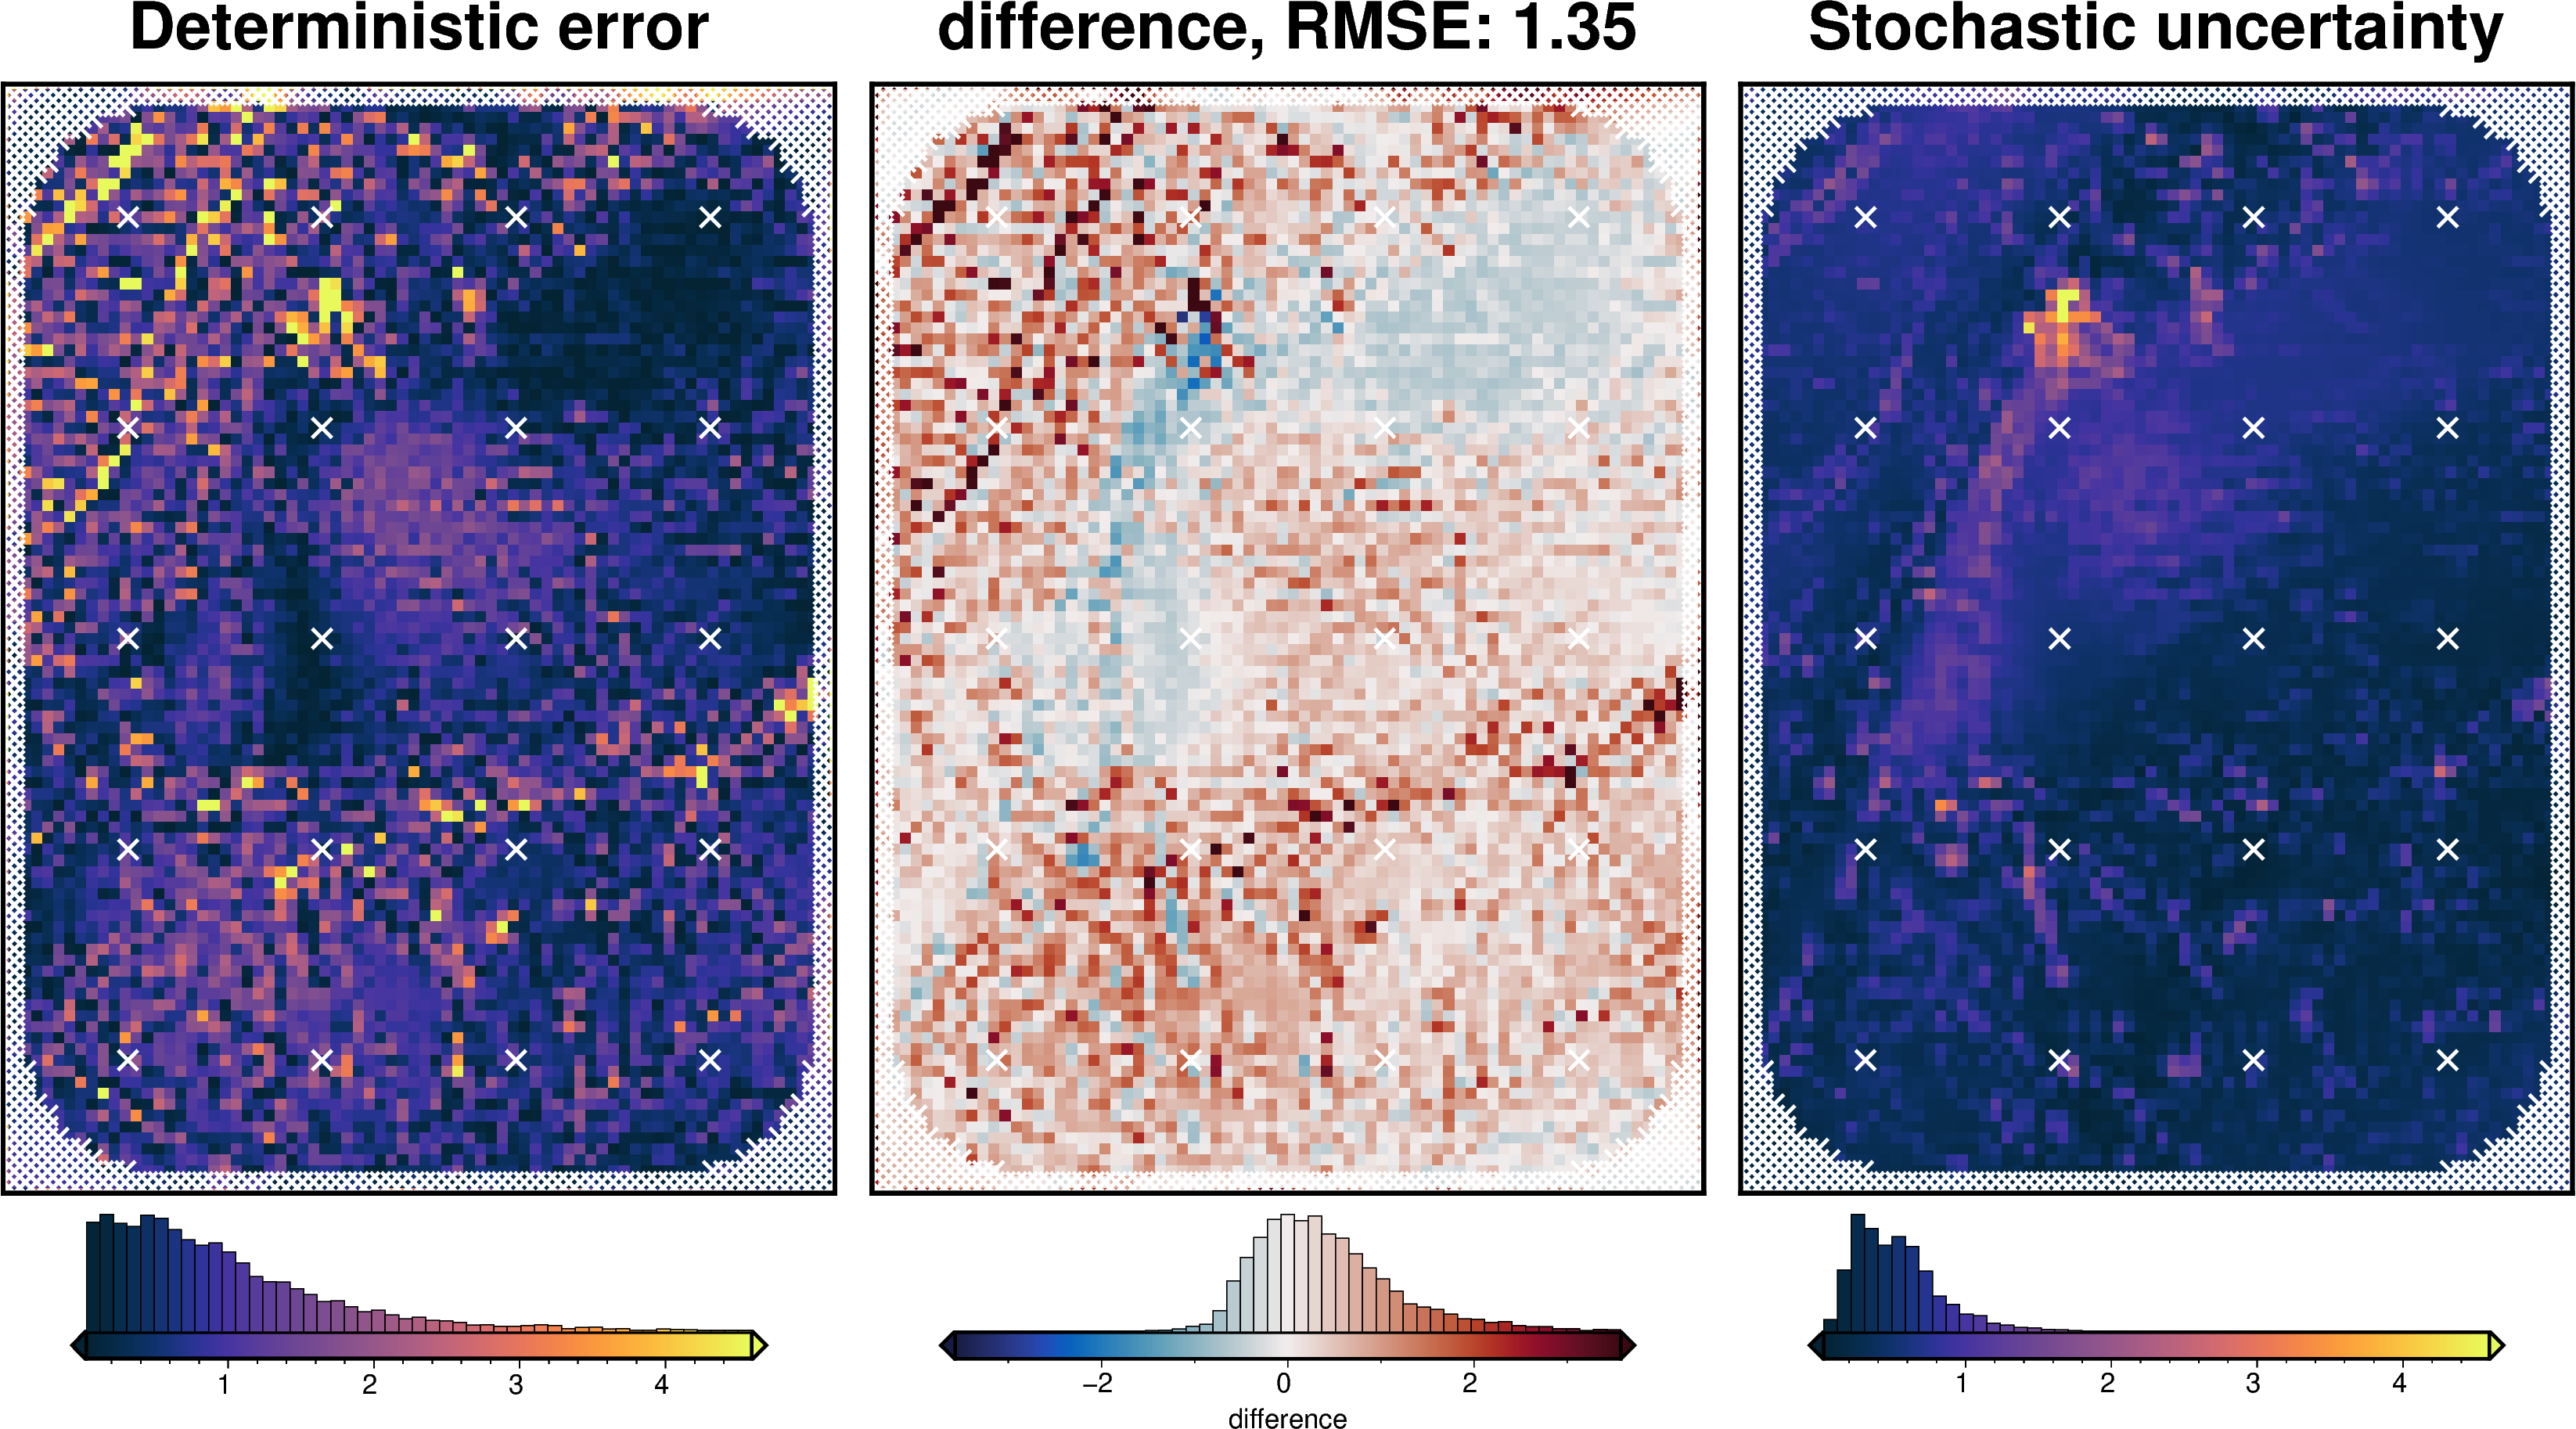

In [41]:
fname = "../../results/Ross_Sea_02_uncertainty_full"

# delete files if already exist
for p in pathlib.Path().glob(f"{fname}*"):
    p.unlink(missing_ok=True)

uncert_results = uncertainty.full_workflow_uncertainty_loop(
    fname=fname,
    runs=20,
    parameter_dict=solver_dict | density_dict,
    **uncert_kwargs,
)

stats_ds = RIS_plotting.uncert_plots(
    uncert_results,
    # vd.pad_region(inversion_region, -3*spacing),
    inversion_region,
    spacing,
    bathymetry,
    deterministic_bathymetry=final_topography,
    constraint_points=constraint_points,
    weight_by="constraints",
    # weight_by="residual",
    # weight_by=None,
)

### Comparing results

In [42]:
results = [
    uncert_results,
    uncert_density_results,
    uncert_damping_results,
]

# get cell-wise stats for each ensemble
stats = []
for r in results:
    ds = uncertainty.merged_stats(
        results=r,
        plot=False,
        constraints_df=constraint_points,
        weight_by="constraints",
        # region=vd.pad_region(inversion_region, -3*spacing),
        region=inversion_region,
    )
    stats.append(ds)

In [43]:
names = [
    "full",
    "density",
    "damping",
]

# get the standard deviation of the ensemble of ensembles
stdevs = []
for i, s in enumerate(stats):
    stdevs.append(s.weighted_stdev.rename(f"{names[i]}_stdev"))

merged = xr.merge(stdevs)
merged

<xarray.Dataset> Size: 186kB
Dimensions:        (northing: 101, easting: 76)
Coordinates:
  * northing       (northing) float64 808B -1.6e+06 -1.598e+06 ... -1.4e+06
  * easting        (easting) float64 608B -4e+04 -3.8e+04 ... 1.08e+05 1.1e+05
Data variables:
    full_stdev     (northing, easting) float64 61kB 0.3626 0.3608 ... 0.9528
    density_stdev  (northing, easting) float64 61kB 0.1816 0.2001 ... 0.6986
    damping_stdev  (northing, easting) float64 61kB 0.325 0.2474 ... 0.7763

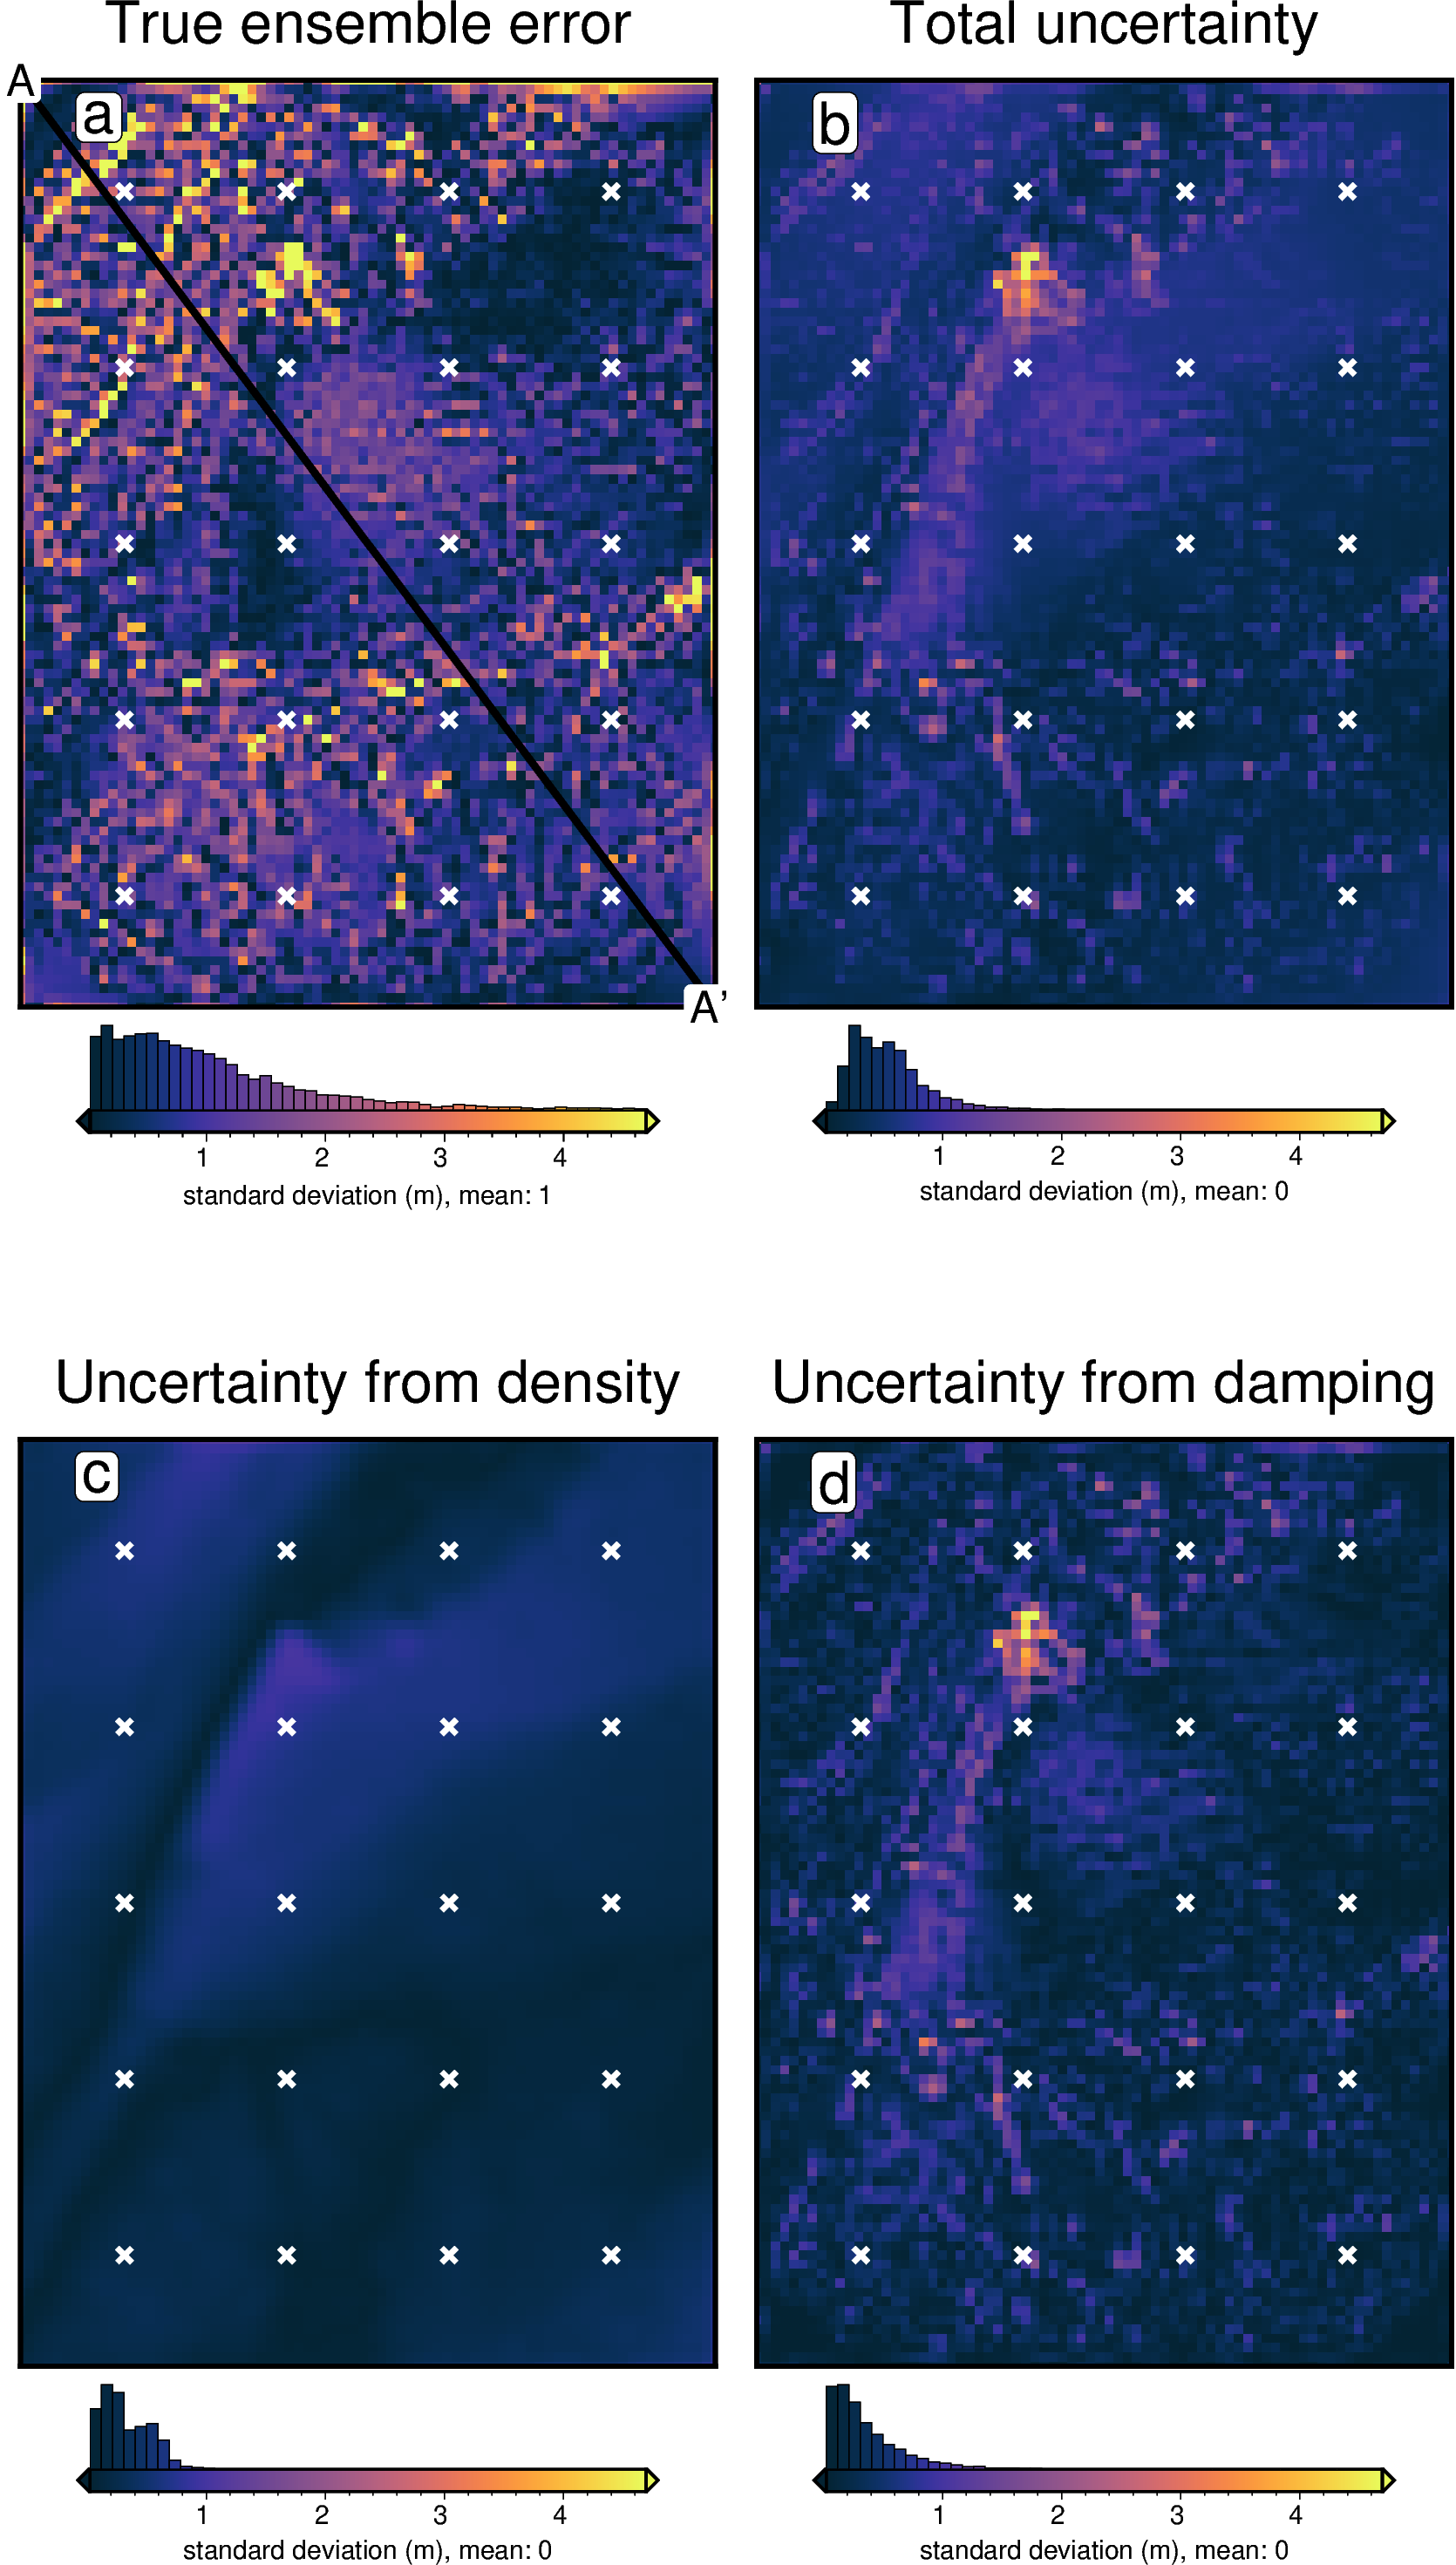

In [44]:
titles = [
    "True ensemble error",
    # "True indiv error",
    "Total uncertainty",
    "Uncertainty from density",
    "Uncertainty from damping",
]
grids = list(merged.data_vars.values())

grids.insert(0, np.abs(stats[0].weighted_mean - bathymetry))

# cpt_lims = polar_utils.get_min_max(grids[0], robust=True,)
cpt_lims = polar_utils.get_combined_min_max(grids, robust=True)

fig_height = 9
for i, g in enumerate(grids):
    xshift_amount = 1
    if i == 0:
        fig = None
        origin_shift = "initialize"
    elif i == 2:
        origin_shift = "both_shift"
        xshift_amount = -1
    else:
        origin_shift = "xshift"

    fig = maps.plot_grd(
        grid=g,
        fig_height=fig_height,
        title=titles[i],
        title_font="16p,Helvetica,black",
        cmap="thermal",
        cpt_lims=cpt_lims,
        robust=True,
        cbar_label=f"standard deviation (m), mean: {int(np.nanmean(g))}",
        hist=True,
        hist_bin_num=50,
        cbar_yoffset=1,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=xshift_amount,
        yshift_amount=-1.1,
    )
    fig.plot(
        x=constraint_points[constraint_points.inside].easting,
        y=constraint_points[constraint_points.inside].northing,
        style="x.2c",
        fill="white",
        pen="1.5p,white",
    )
    fig.text(
        position="TL",
        text=f"{string.ascii_lowercase[i]}",
        fill="white",
        pen=True,
        font="16p,Helvetica,black",
        offset="j.6/.2",
        clearance="+tO",
        no_clip=True,
    )
    if i == 0:
        # plot profiles location, and endpoints on map
        start = [inversion_region[0], inversion_region[3]]
        stop = [inversion_region[1], inversion_region[2]]
        fig.plot(
            vd.line_coordinates(start, stop, size=100),
            pen="2p,black",
        )
        fig.text(
            x=start[0],
            y=start[1],
            text="A",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
        fig.text(
            x=stop[0],
            y=stop[1],
            text="A' ",
            fill="white",
            font="12p,Helvetica,black",
            justify="CM",
            clearance="+tO",
            no_clip=True,
        )
fig.show()

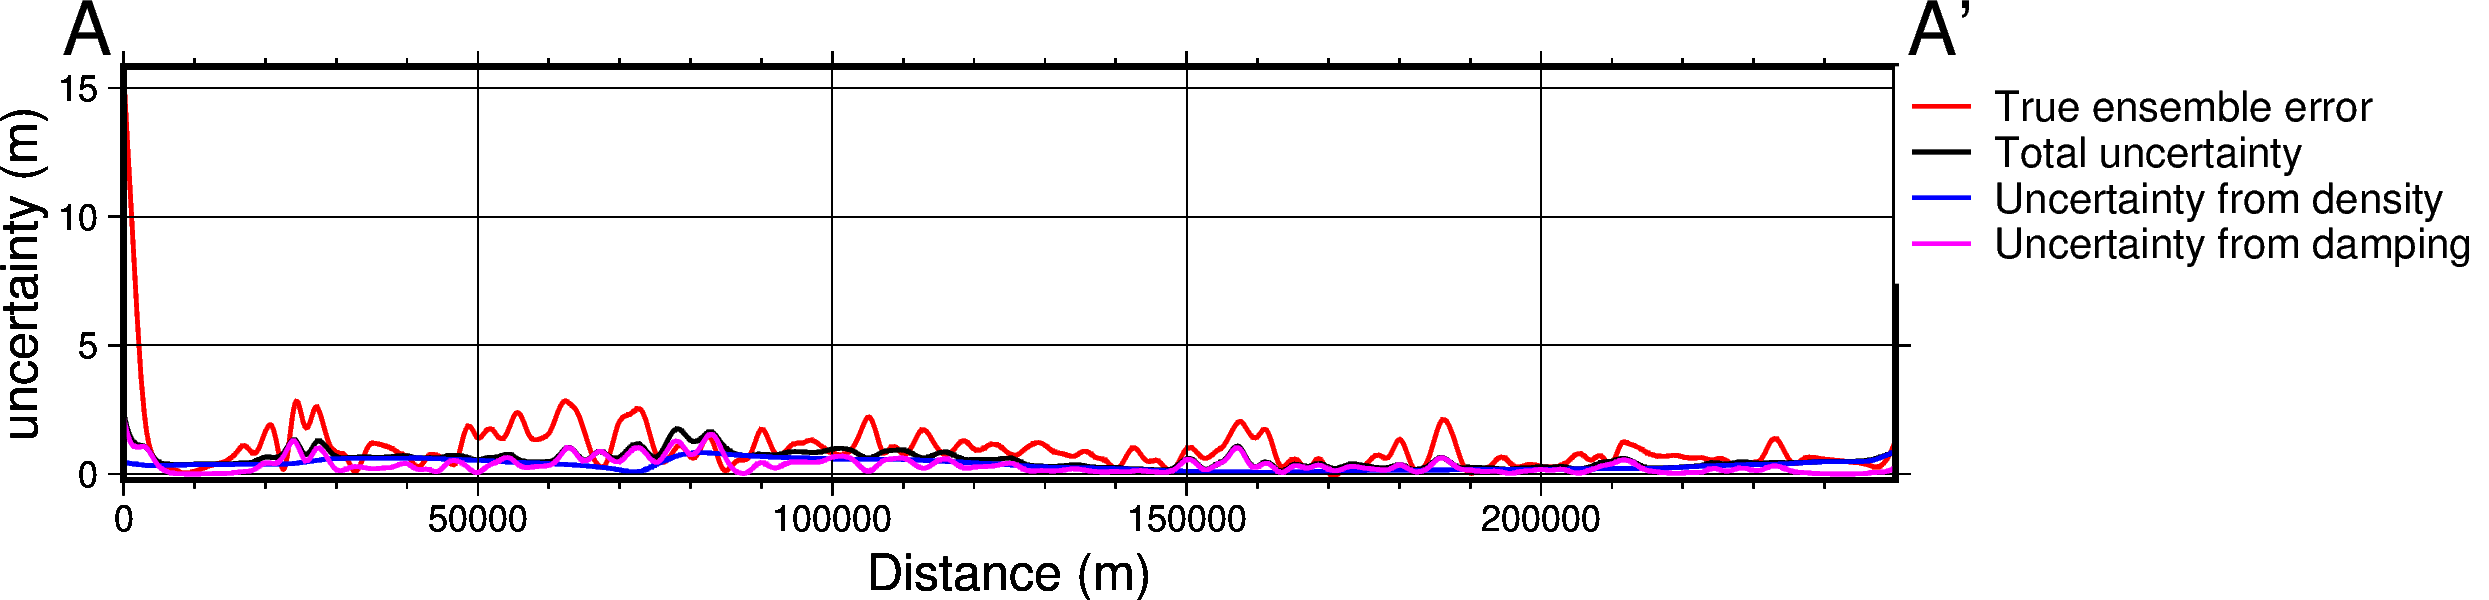

In [45]:
data_dict = profiles.make_data_dict(
    names=titles,
    grids=grids,
    colors=[
        "red",
        "black",
        "blue",
        "magenta",
        "cyan",
        "green",
        "purple",
    ],
)

fig, df_data = profiles.plot_data(
    "points",
    start=[inversion_region[0], inversion_region[3]],
    stop=[inversion_region[1], inversion_region[2]],
    num=10000,
    fig_height=4,
    fig_width=15,
    data_dict=data_dict,
    data_legend_loc="jTR+jTL",
    data_legend_box="+gwhite",
    data_buffer=0.01,
    data_frame=["neSW", "xafg+lDistance (m)", "yag+luncertainty (m)"],
    # data_pen_style=[None,None,"4_2:2p"],
    # data_pen_thickness=[1, 1.5, 1],
    share_yaxis=True,
    start_label="A",
    end_label="A' ",
)
fig.show()

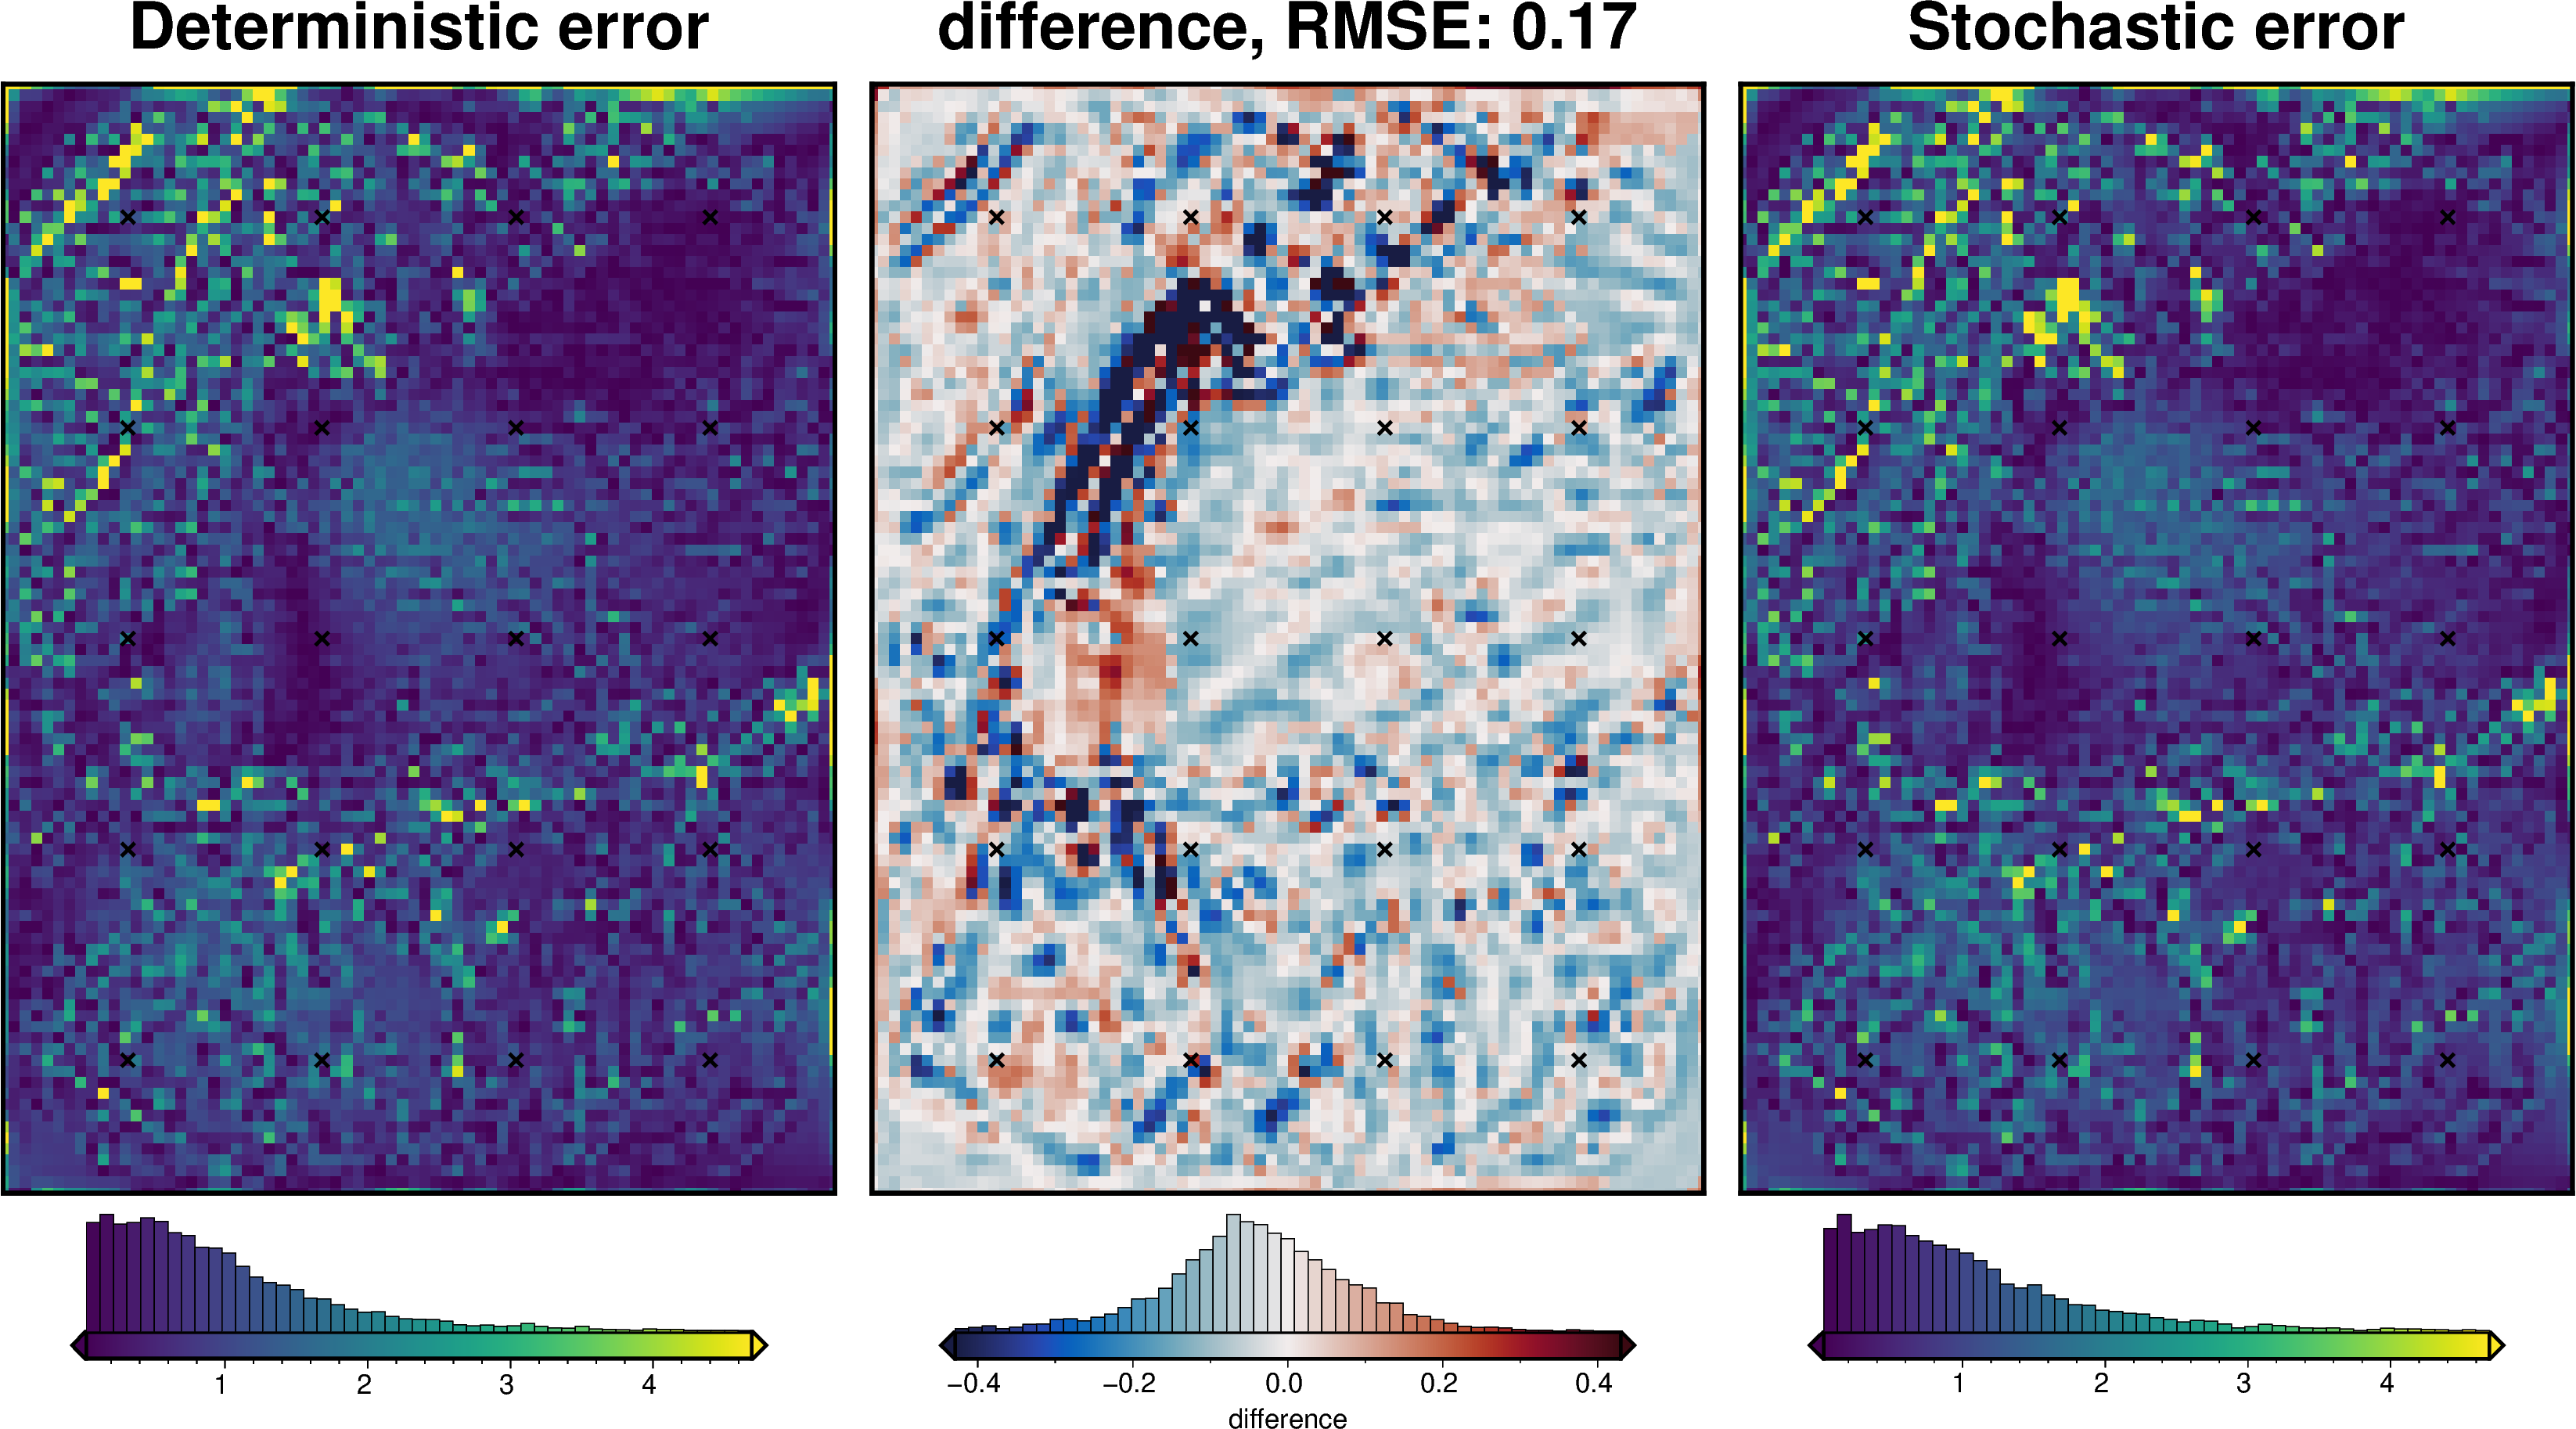

In [46]:
_ = polar_utils.grd_compare(
    inversion_error,
    np.abs(stats[0].weighted_mean - bathymetry),
    region=inversion_region,
    plot=True,
    grid1_name="Deterministic error",
    grid2_name="Stochastic error",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    points=constraint_points[constraint_points.inside],
    points_style="x.2c",
)

In [47]:
# save results
merged.to_netcdf("../../results/Ross_Sea_02_sensitivity.nc")

In [48]:
stats_ds.to_netcdf("../../results/Ross_Sea_02_uncertainty.nc")